In [1]:
import opendatasets as od
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
from torchvision.utils import save_image
from tqdm import tqdm
import torch.nn.functional as F
from IPython.display import Image

import cv2
import os

In [2]:
class Discriminator():
    def __init__(self, g1):
        self.g1 = g1
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

            nn.Flatten(),
            nn.Sigmoid())

class Generator():
    def __init__(self, g1):
        self.g1 = g1
        self.network = nn.Sequential(
        nn.ConvTranspose2d(g1.latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),

        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),

        nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

In [3]:
class DeviceDataLoader():
    def __init__(self, f1, dl, device):
        self.dl = dl
        self.device = device
        self.f1 = f1
        
    def __iter__(self):
        for b in self.dl: 
            yield self.f1.to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [4]:
class GAN():
    def __init__(self):
        print("constructor")
        
    def init_hyp(self):
        self.image_size = 64
        self.batch_size = 256
        self.stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        self.latent_size = 256
        self.lr = 0.002
        self.epoch = 3000
#         self.DATA_DIR = './data/face-ex-images/neetu/naruto-cropped-faces-all/'
        self.DATA_DIR = './data/images-big/'
    
    def init_obj(self):
        self.disc = Discriminator(self).network
        self.genr = Generator(self).network
        self.device = self.get_default_device()
        self.to_device(self.disc, self.device)
        self.to_device(self.genr, self.device)
        self.fixed_latent = torch.randn(64, self.latent_size, 1, 1, device=self.device)
        
    def get_data(self):
        dataset_url = 'https://www.kaggle.com/neetuk/naruto-face-dataset'
        od.download(dataset_url)
        
    def show_data(self):
#         self.DATA_DIR = './data/pokemon-images-dataset/pokemon_jpg/'
#         print(os.listdir(self.DATA_DIR+'/pokemon_jpg')[:10])
#         self.DATA_DIR = './data/face-ex-images/neetu/cropped-faces/'
        print(os.listdir(self.DATA_DIR)[:10])
    
    def init_data(self):
        self.init_hyp()
        self.init_obj()
        
        self.train_ds = ImageFolder(self.DATA_DIR, transform=T.Compose([
        T.Resize(self.image_size),
        T.CenterCrop(self.image_size),
        T.ToTensor(),
        T.Normalize(*self.stats)]))
        
#         print("shape", self.train_ds.size)
        self.train_dl = DataLoader(self.train_ds, self.batch_size, shuffle=True, num_workers=4, pin_memory=True)
        self.train_dl = DeviceDataLoader(self, self.train_dl, self.device)
        
    
    def denorm(self, img_tensors):
        return img_tensors * self.stats[1][0] + self.stats[0][0]
    
    def show_image(self):
        for i, l in self.train_dl:
            plt.imshow(i[49].cpu().permute(1, 2, 0))
            break
    
    def show_images(self, images, nmax=64):
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(self.denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

    def show_batch(self, nmax=64):
        for images, _ in self.train_dl:
            self.show_images(images.cpu(), nmax)
            break
    
    def get_default_device(self):
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')
    
    def to_device(self, data, device):
        if isinstance(data, (list,tuple)):
            return [self.to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)
    
    def train_discriminator(self, real_images, opt_d):
        opt_d.zero_grad()

        real_preds = self.disc(real_images)
#         print("real_preds", real_preds)
        
        real_targets = torch.ones(real_images.size(0), 1, device=self.device)
#         print("real_targets", real_targets)
        
        real_loss = F.binary_cross_entropy(real_preds, real_targets)
        real_score = torch.mean(real_preds).item()

        latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
        fake_images = self.genr(latent)

        fake_targets = torch.zeros(fake_images.size(0), 1, device=self.device)
        fake_preds = self.disc(fake_images)
        fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        fake_score = torch.mean(fake_preds).item()

        loss = real_loss + fake_loss
        loss.backward()
        opt_d.step()
        return loss.item(), real_score, fake_score
    
    def train_generator(self, opt_g):
        # Clear generator gradients
        opt_g.zero_grad()

        # Generate fake images
        latent = torch.randn(self.batch_size, self.latent_size, 1, 1, device=self.device)
        fake_images = self.genr(latent)

        # Try to fool the discriminator
        preds = self.disc(fake_images)
        targets = torch.ones(self.batch_size, 1, device=self.device)
        loss = F.binary_cross_entropy(preds, targets)

        # Update generator weights
        loss.backward()
        opt_g.step()

        return loss.item()
    
    def save_samples(self, index, latent_tensors, show=True):
        sample_dir = './data/face-ex-images/generated2/naruto'
        os.makedirs(sample_dir, exist_ok=True)
        
        fake_images = self.genr(latent_tensors)
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        save_image(self.denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
        print('Saving', fake_fname)
        if show:
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    
    def fit(self, start_idx=1):
        torch.cuda.empty_cache()

        # Losses & scores
        losses_g = []
        losses_d = []
        real_scores = []
        fake_scores = []

        # Create optimizers
        opt_d = torch.optim.Adam(self.disc.parameters(), lr=self.lr, betas=(0.5, 0.999))
        opt_g = torch.optim.Adam(self.genr.parameters(), lr=self.lr, betas=(0.5, 0.999))

        for epoch in range(self.epoch):
            for real_images, _ in tqdm(self.train_dl, position=0, leave=True):
                # Train discriminator
                loss_d, real_score, fake_score = self.train_discriminator(real_images, opt_d)
                # Train generator
                loss_g = self.train_generator(opt_g)

            # Record losses & scores
            losses_g.append(loss_g)
            losses_d.append(loss_d)
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            # Log losses & scores (last batch)
            print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, self.epoch, loss_g, loss_d, real_score, fake_score))

            # Save generated images
            if epoch%200 == 0:
                self.save_samples(epoch+start_idx, self.fixed_latent, show=False)

        return losses_g, losses_d, real_scores, fake_scores

In [5]:
gan = GAN()

constructor


In [ ]:
# open this to download the naruto dataset and place it inside data folder
# gan.get_data()

In [6]:
gan.init_data()

In [7]:
gan.show_data()

['45374.jpg', '37103.jpg', '23588.jpg', '11139.jpg', '17833.jpg', '46280.jpg', '10853.jpg', '12853.jpg', '37947.jpg', '20580.jpg']


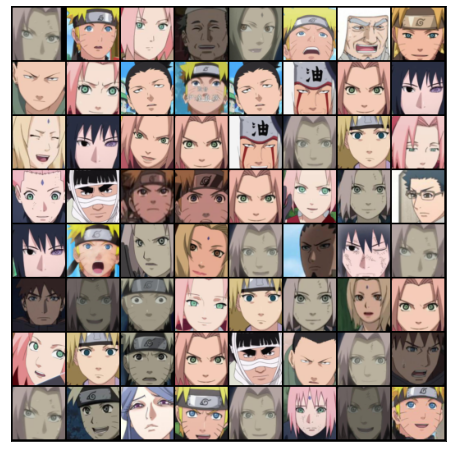

In [9]:
gan.show_batch()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


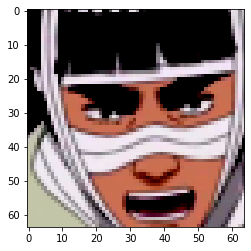

In [10]:
gan.show_image()

In [30]:
gan.train_dl

In [12]:
history = gan.fit()

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1/3000], loss_g: 14.7527, loss_d: 1.4687, real_score: 0.5262, fake_score: 0.5502
Saving generated-images-0001.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2/3000], loss_g: 17.8699, loss_d: 10.4151, real_score: 0.8913, fake_score: 1.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [3/3000], loss_g: 6.3479, loss_d: 6.8656, real_score: 0.0475, fake_score: 0.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [4/3000], loss_g: 7.7448, loss_d: 5.7237, real_score: 0.7396, fake_score: 0.9787


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [5/3000], loss_g: 4.7056, loss_d: 0.3353, real_score: 0.8382, fake_score: 0.0215


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [6/3000], loss_g: 4.0003, loss_d: 1.5905, real_score: 0.8190, fake_score: 0.4265


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [7/3000], loss_g: 4.5632, loss_d: 1.2456, real_score: 0.8349, fake_score: 0.3723


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [8/3000], loss_g: 3.7289, loss_d: 1.3264, real_score: 0.6681, fake_score: 0.3151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [9/3000], loss_g: 2.7127, loss_d: 1.0522, real_score: 0.6086, fake_score: 0.2230


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [10/3000], loss_g: 3.2510, loss_d: 0.9748, real_score: 0.7387, fake_score: 0.3817


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [11/3000], loss_g: 3.4371, loss_d: 0.5649, real_score: 0.7653, fake_score: 0.1869


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [12/3000], loss_g: 3.8493, loss_d: 0.4893, real_score: 0.8629, fake_score: 0.2399


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [13/3000], loss_g: 4.0616, loss_d: 0.4386, real_score: 0.8770, fake_score: 0.2261


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [14/3000], loss_g: 4.6426, loss_d: 0.3714, real_score: 0.8733, fake_score: 0.1743


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [15/3000], loss_g: 4.2812, loss_d: 0.2335, real_score: 0.8998, fake_score: 0.0968


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [16/3000], loss_g: 4.6085, loss_d: 0.1630, real_score: 0.9391, fake_score: 0.0834


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [17/3000], loss_g: 4.8401, loss_d: 0.1232, real_score: 0.9558, fake_score: 0.0683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [18/3000], loss_g: 5.9493, loss_d: 0.2400, real_score: 0.9649, fake_score: 0.1706


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [19/3000], loss_g: 5.3238, loss_d: 0.0945, real_score: 0.9426, fake_score: 0.0230


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [20/3000], loss_g: 4.3738, loss_d: 0.1310, real_score: 0.9548, fake_score: 0.0700


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [21/3000], loss_g: 6.5083, loss_d: 0.3689, real_score: 0.9629, fake_score: 0.2419


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [22/3000], loss_g: 4.8550, loss_d: 0.5156, real_score: 0.7447, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [23/3000], loss_g: 4.2940, loss_d: 0.9790, real_score: 0.7147, fake_score: 0.2482


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [24/3000], loss_g: 6.7011, loss_d: 1.0216, real_score: 0.8663, fake_score: 0.3796


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [25/3000], loss_g: 3.7606, loss_d: 0.7361, real_score: 0.6954, fake_score: 0.0687


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [26/3000], loss_g: 5.0405, loss_d: 0.3769, real_score: 0.9874, fake_score: 0.2561


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [27/3000], loss_g: 5.3065, loss_d: 0.1876, real_score: 0.9346, fake_score: 0.0708


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [28/3000], loss_g: 4.8904, loss_d: 0.1087, real_score: 0.9724, fake_score: 0.0704


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [29/3000], loss_g: 6.4563, loss_d: 0.3799, real_score: 0.9587, fake_score: 0.2399


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [30/3000], loss_g: 4.1369, loss_d: 0.3328, real_score: 0.7990, fake_score: 0.0218


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [31/3000], loss_g: 9.0583, loss_d: 0.7399, real_score: 0.9100, fake_score: 0.3854


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [32/3000], loss_g: 1.8124, loss_d: 4.2718, real_score: 0.0574, fake_score: 0.0021


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [33/3000], loss_g: 4.4582, loss_d: 2.5543, real_score: 0.9884, fake_score: 0.7236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [34/3000], loss_g: 5.1681, loss_d: 0.6993, real_score: 0.7910, fake_score: 0.1823


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [35/3000], loss_g: 2.5532, loss_d: 1.1502, real_score: 0.6408, fake_score: 0.1980


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [36/3000], loss_g: 7.6564, loss_d: 2.1543, real_score: 0.9367, fake_score: 0.7234


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [37/3000], loss_g: 4.2388, loss_d: 2.1470, real_score: 0.2138, fake_score: 0.0029


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [38/3000], loss_g: 4.0181, loss_d: 0.7582, real_score: 0.9015, fake_score: 0.3774


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [39/3000], loss_g: 5.0713, loss_d: 0.9332, real_score: 0.8103, fake_score: 0.3896


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [40/3000], loss_g: 1.2584, loss_d: 1.2510, real_score: 0.4766, fake_score: 0.1084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [41/3000], loss_g: 5.8808, loss_d: 1.5713, real_score: 0.9769, fake_score: 0.6835


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [42/3000], loss_g: 4.2782, loss_d: 1.0014, real_score: 0.5368, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [43/3000], loss_g: 3.9018, loss_d: 0.5892, real_score: 0.9041, fake_score: 0.2699


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [44/3000], loss_g: 6.9062, loss_d: 0.8964, real_score: 0.9120, fake_score: 0.4297


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [45/3000], loss_g: 1.6473, loss_d: 1.9700, real_score: 0.2715, fake_score: 0.0126


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [46/3000], loss_g: 9.1995, loss_d: 4.3621, real_score: 0.9698, fake_score: 0.9476


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [47/3000], loss_g: 6.0646, loss_d: 2.1538, real_score: 0.2966, fake_score: 0.0049


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [48/3000], loss_g: 2.5978, loss_d: 0.4262, real_score: 0.8162, fake_score: 0.0867


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [49/3000], loss_g: 4.1488, loss_d: 0.8563, real_score: 0.9666, fake_score: 0.4580


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [50/3000], loss_g: 4.6259, loss_d: 0.2472, real_score: 0.8919, fake_score: 0.0918


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [51/3000], loss_g: 3.7522, loss_d: 0.2801, real_score: 0.8769, fake_score: 0.1013


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [52/3000], loss_g: 5.5545, loss_d: 0.4529, real_score: 0.9255, fake_score: 0.2666


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [53/3000], loss_g: 5.3888, loss_d: 0.2113, real_score: 0.8752, fake_score: 0.0457


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [54/3000], loss_g: 5.3370, loss_d: 0.2678, real_score: 0.9356, fake_score: 0.1592


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [55/3000], loss_g: 6.3535, loss_d: 0.2898, real_score: 0.9393, fake_score: 0.1799


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [56/3000], loss_g: 5.3857, loss_d: 0.1891, real_score: 0.8963, fake_score: 0.0544


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [57/3000], loss_g: 7.1651, loss_d: 0.3575, real_score: 0.9479, fake_score: 0.2352


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [58/3000], loss_g: 6.4818, loss_d: 0.1481, real_score: 0.8963, fake_score: 0.0096


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [59/3000], loss_g: 4.9188, loss_d: 0.1668, real_score: 0.9366, fake_score: 0.0769


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [60/3000], loss_g: 17.3928, loss_d: 2.0111, real_score: 0.9630, fake_score: 0.7700


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [61/3000], loss_g: 7.2016, loss_d: 11.4985, real_score: 0.0027, fake_score: 0.0000


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [62/3000], loss_g: 0.6252, loss_d: 4.5350, real_score: 0.0629, fake_score: 0.0166


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [63/3000], loss_g: 3.5407, loss_d: 2.1434, real_score: 0.9074, fake_score: 0.6877


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [64/3000], loss_g: 4.6261, loss_d: 0.3737, real_score: 0.8468, fake_score: 0.1439


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [65/3000], loss_g: 4.1117, loss_d: 0.2738, real_score: 0.8949, fake_score: 0.1133


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [66/3000], loss_g: 4.3092, loss_d: 0.2723, real_score: 0.9511, fake_score: 0.1653


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [67/3000], loss_g: 4.9065, loss_d: 0.3422, real_score: 0.9493, fake_score: 0.1977


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [68/3000], loss_g: 5.7847, loss_d: 0.5006, real_score: 0.9072, fake_score: 0.2636


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [69/3000], loss_g: 5.9081, loss_d: 0.4428, real_score: 0.8505, fake_score: 0.1873


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [70/3000], loss_g: 5.8962, loss_d: 0.2368, real_score: 0.9467, fake_score: 0.1289


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [71/3000], loss_g: 5.5451, loss_d: 0.2546, real_score: 0.9569, fake_score: 0.1595


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [72/3000], loss_g: 4.6257, loss_d: 0.1542, real_score: 0.9421, fake_score: 0.0699


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [73/3000], loss_g: 4.7571, loss_d: 0.0822, real_score: 0.9578, fake_score: 0.0261


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [74/3000], loss_g: 4.5331, loss_d: 0.0655, real_score: 0.9745, fake_score: 0.0313


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [75/3000], loss_g: 4.3833, loss_d: 0.1089, real_score: 0.9817, fake_score: 0.0793


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [76/3000], loss_g: 6.7190, loss_d: 0.2757, real_score: 0.9813, fake_score: 0.2017


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [77/3000], loss_g: 5.0917, loss_d: 0.1965, real_score: 0.8771, fake_score: 0.0397


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [78/3000], loss_g: 8.3590, loss_d: 0.3376, real_score: 0.9425, fake_score: 0.2128


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [79/3000], loss_g: 5.8908, loss_d: 0.1960, real_score: 0.8567, fake_score: 0.0078


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [80/3000], loss_g: 4.1781, loss_d: 0.0803, real_score: 0.9808, fake_score: 0.0563


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [81/3000], loss_g: 12.0149, loss_d: 0.8090, real_score: 0.9811, fake_score: 0.4946


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [82/3000], loss_g: 6.2410, loss_d: 8.0794, real_score: 0.0022, fake_score: 0.0004


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [83/3000], loss_g: 2.8485, loss_d: 0.1990, real_score: 0.8680, fake_score: 0.0186


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [84/3000], loss_g: 3.1180, loss_d: 0.5754, real_score: 0.9941, fake_score: 0.3822


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [85/3000], loss_g: 4.4560, loss_d: 0.5337, real_score: 0.9737, fake_score: 0.3620


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [86/3000], loss_g: 4.3415, loss_d: 0.2796, real_score: 0.8777, fake_score: 0.1057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [87/3000], loss_g: 4.8808, loss_d: 0.3540, real_score: 0.9391, fake_score: 0.1999


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [88/3000], loss_g: 7.1196, loss_d: 0.3866, real_score: 0.9525, fake_score: 0.2550


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [89/3000], loss_g: 5.5495, loss_d: 0.1970, real_score: 0.8711, fake_score: 0.0325


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [90/3000], loss_g: 4.8497, loss_d: 0.1410, real_score: 0.9425, fake_score: 0.0630


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [91/3000], loss_g: 6.0128, loss_d: 0.2330, real_score: 0.9804, fake_score: 0.1655


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [92/3000], loss_g: 5.2309, loss_d: 0.2356, real_score: 0.8740, fake_score: 0.0629


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [93/3000], loss_g: 2.1461, loss_d: 1.6874, real_score: 0.4181, fake_score: 0.2128


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [94/3000], loss_g: 6.5701, loss_d: 0.7271, real_score: 0.9298, fake_score: 0.4331


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [95/3000], loss_g: 1.9917, loss_d: 3.3303, real_score: 0.1455, fake_score: 0.0100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [96/3000], loss_g: 3.5704, loss_d: 0.9845, real_score: 0.9255, fake_score: 0.5228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [97/3000], loss_g: 5.2657, loss_d: 0.8042, real_score: 0.9023, fake_score: 0.2543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [98/3000], loss_g: 4.7175, loss_d: 0.1654, real_score: 0.9106, fake_score: 0.0549


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [99/3000], loss_g: 5.4245, loss_d: 0.5943, real_score: 0.8989, fake_score: 0.3043


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [100/3000], loss_g: 6.4738, loss_d: 0.9054, real_score: 0.7731, fake_score: 0.2711


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [101/3000], loss_g: 3.6149, loss_d: 0.9414, real_score: 0.6548, fake_score: 0.0418


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [102/3000], loss_g: 8.5784, loss_d: 1.3683, real_score: 0.9825, fake_score: 0.5798


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [103/3000], loss_g: 5.2369, loss_d: 1.0375, real_score: 0.4980, fake_score: 0.0057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [104/3000], loss_g: 3.0089, loss_d: 0.2420, real_score: 0.9411, fake_score: 0.1360


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [105/3000], loss_g: 5.5801, loss_d: 1.0902, real_score: 0.9812, fake_score: 0.5162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [106/3000], loss_g: 4.3550, loss_d: 0.7599, real_score: 0.6382, fake_score: 0.0348


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [107/3000], loss_g: 5.3653, loss_d: 0.4674, real_score: 0.9327, fake_score: 0.2132


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [108/3000], loss_g: 6.8370, loss_d: 0.3139, real_score: 0.9597, fake_score: 0.2036


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [109/3000], loss_g: 4.9738, loss_d: 0.3743, real_score: 0.8374, fake_score: 0.1144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [110/3000], loss_g: 11.2928, loss_d: 1.4949, real_score: 0.9198, fake_score: 0.6622


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [111/3000], loss_g: 7.2516, loss_d: 5.2857, real_score: 0.0274, fake_score: 0.0010


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [112/3000], loss_g: 3.8464, loss_d: 0.5953, real_score: 0.7861, fake_score: 0.0383


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [113/3000], loss_g: 4.2132, loss_d: 1.0820, real_score: 0.9715, fake_score: 0.4833


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [114/3000], loss_g: 5.6202, loss_d: 0.4554, real_score: 0.9179, fake_score: 0.1989


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [115/3000], loss_g: 5.0813, loss_d: 0.2441, real_score: 0.8901, fake_score: 0.0808


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [116/3000], loss_g: 6.2214, loss_d: 0.5877, real_score: 0.8760, fake_score: 0.2873


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [117/3000], loss_g: 3.1911, loss_d: 0.5893, real_score: 0.6909, fake_score: 0.0926


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [118/3000], loss_g: 17.4007, loss_d: 2.4323, real_score: 0.9671, fake_score: 0.8413


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [119/3000], loss_g: 10.3556, loss_d: 5.6533, real_score: 0.0417, fake_score: 0.0001


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [120/3000], loss_g: 3.6228, loss_d: 1.1672, real_score: 0.5566, fake_score: 0.0194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [121/3000], loss_g: 3.6683, loss_d: 0.6305, real_score: 0.9873, fake_score: 0.3419


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [122/3000], loss_g: 5.6267, loss_d: 0.5151, real_score: 0.9771, fake_score: 0.2807


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [123/3000], loss_g: 5.6723, loss_d: 0.1763, real_score: 0.9596, fake_score: 0.1012


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [124/3000], loss_g: 5.1032, loss_d: 0.2927, real_score: 0.9364, fake_score: 0.1544


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [125/3000], loss_g: 8.6077, loss_d: 0.7782, real_score: 0.9415, fake_score: 0.2896


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [126/3000], loss_g: 6.0703, loss_d: 0.3742, real_score: 0.7906, fake_score: 0.0145


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [127/3000], loss_g: 4.7255, loss_d: 0.0770, real_score: 0.9734, fake_score: 0.0397


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [128/3000], loss_g: 4.4019, loss_d: 0.3252, real_score: 0.9831, fake_score: 0.2224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [129/3000], loss_g: 6.4388, loss_d: 0.4083, real_score: 0.9726, fake_score: 0.2711


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [130/3000], loss_g: 6.3909, loss_d: 0.4711, real_score: 0.8049, fake_score: 0.0956


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [131/3000], loss_g: 4.2646, loss_d: 1.6475, real_score: 0.7461, fake_score: 0.1275


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [132/3000], loss_g: 9.6941, loss_d: 1.6748, real_score: 0.9493, fake_score: 0.5072


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [133/3000], loss_g: 5.9060, loss_d: 1.6857, real_score: 0.4108, fake_score: 0.0008


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [134/3000], loss_g: 3.0859, loss_d: 0.0762, real_score: 0.9834, fake_score: 0.0516


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [135/3000], loss_g: 6.5015, loss_d: 0.9402, real_score: 0.9847, fake_score: 0.5159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [136/3000], loss_g: 6.3762, loss_d: 0.3431, real_score: 0.8312, fake_score: 0.0217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [137/3000], loss_g: 5.4557, loss_d: 0.0835, real_score: 0.9656, fake_score: 0.0320


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [138/3000], loss_g: 4.3066, loss_d: 0.1397, real_score: 0.9815, fake_score: 0.1039


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [139/3000], loss_g: 12.1494, loss_d: 0.9449, real_score: 0.9826, fake_score: 0.4906


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [140/3000], loss_g: 7.4969, loss_d: 1.5521, real_score: 0.3817, fake_score: 0.0004


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [141/3000], loss_g: 4.4635, loss_d: 0.1278, real_score: 0.9204, fake_score: 0.0055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [142/3000], loss_g: 3.2434, loss_d: 0.0581, real_score: 0.9861, fake_score: 0.0399


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [143/3000], loss_g: 3.1189, loss_d: 0.2596, real_score: 0.9953, fake_score: 0.2010


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [144/3000], loss_g: 4.1573, loss_d: 0.3413, real_score: 0.9899, fake_score: 0.2667


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [145/3000], loss_g: 4.5519, loss_d: 0.3143, real_score: 0.9128, fake_score: 0.1452


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [146/3000], loss_g: 7.3479, loss_d: 0.4330, real_score: 0.9922, fake_score: 0.2971


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [147/3000], loss_g: 5.9214, loss_d: 0.1338, real_score: 0.9153, fake_score: 0.0225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [148/3000], loss_g: 4.6871, loss_d: 0.1515, real_score: 0.9138, fake_score: 0.0342


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [149/3000], loss_g: 3.6055, loss_d: 0.1074, real_score: 0.9823, fake_score: 0.0797


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [150/3000], loss_g: 6.9181, loss_d: 0.3890, real_score: 0.9915, fake_score: 0.2877


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [151/3000], loss_g: 6.9626, loss_d: 0.0450, real_score: 0.9683, fake_score: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [152/3000], loss_g: 6.4467, loss_d: 0.0349, real_score: 0.9732, fake_score: 0.0056


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [153/3000], loss_g: 4.9476, loss_d: 0.0387, real_score: 0.9861, fake_score: 0.0237


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [154/3000], loss_g: 4.2715, loss_d: 0.1267, real_score: 0.9914, fake_score: 0.1068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [155/3000], loss_g: 4.1311, loss_d: 0.1215, real_score: 0.9909, fake_score: 0.1043


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [156/3000], loss_g: 5.9587, loss_d: 0.3413, real_score: 0.9888, fake_score: 0.2319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [157/3000], loss_g: 5.5875, loss_d: 0.0803, real_score: 0.9451, fake_score: 0.0183


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [158/3000], loss_g: 4.1501, loss_d: 0.0783, real_score: 0.9632, fake_score: 0.0373


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [159/3000], loss_g: 14.6587, loss_d: 1.2022, real_score: 0.9822, fake_score: 0.5666


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [160/3000], loss_g: 8.0647, loss_d: 7.3130, real_score: 0.0058, fake_score: 0.0001


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [161/3000], loss_g: 3.0089, loss_d: 1.5595, real_score: 0.4612, fake_score: 0.0048


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [162/3000], loss_g: 1.9724, loss_d: 0.2226, real_score: 0.9942, fake_score: 0.1781


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [163/3000], loss_g: 4.5603, loss_d: 0.9518, real_score: 0.9941, fake_score: 0.5338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [164/3000], loss_g: 5.0813, loss_d: 0.0908, real_score: 0.9738, fake_score: 0.0558


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [165/3000], loss_g: 3.9080, loss_d: 0.1765, real_score: 0.9167, fake_score: 0.0560


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [166/3000], loss_g: 2.9811, loss_d: 0.2731, real_score: 0.9495, fake_score: 0.1688


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [167/3000], loss_g: 5.1315, loss_d: 0.8804, real_score: 0.9653, fake_score: 0.4933


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [168/3000], loss_g: 2.9347, loss_d: 0.7253, real_score: 0.6144, fake_score: 0.0474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [169/3000], loss_g: 15.4314, loss_d: 3.9390, real_score: 0.9938, fake_score: 0.9312


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [170/3000], loss_g: 7.0631, loss_d: 3.5383, real_score: 0.1169, fake_score: 0.0002


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [171/3000], loss_g: 4.0839, loss_d: 0.3247, real_score: 0.8068, fake_score: 0.0173


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [172/3000], loss_g: 3.2170, loss_d: 0.1781, real_score: 0.9850, fake_score: 0.1178


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [173/3000], loss_g: 4.3003, loss_d: 0.3290, real_score: 0.9925, fake_score: 0.2420


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [174/3000], loss_g: 5.6474, loss_d: 0.2105, real_score: 0.9923, fake_score: 0.1702


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [175/3000], loss_g: 5.7538, loss_d: 0.0989, real_score: 0.9872, fake_score: 0.0771


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [176/3000], loss_g: 5.1683, loss_d: 0.0724, real_score: 0.9779, fake_score: 0.0451


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [177/3000], loss_g: 5.0306, loss_d: 0.1622, real_score: 0.9734, fake_score: 0.1162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [178/3000], loss_g: 5.2158, loss_d: 0.1639, real_score: 0.9583, fake_score: 0.1062


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [179/3000], loss_g: 5.1186, loss_d: 0.0981, real_score: 0.9371, fake_score: 0.0263


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [180/3000], loss_g: 6.3251, loss_d: 0.2689, real_score: 0.9734, fake_score: 0.1956


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [181/3000], loss_g: 5.0658, loss_d: 0.2263, real_score: 0.8767, fake_score: 0.0682


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [182/3000], loss_g: 5.6839, loss_d: 0.1780, real_score: 0.9599, fake_score: 0.1170


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [183/3000], loss_g: 8.0411, loss_d: 0.3265, real_score: 0.9353, fake_score: 0.2066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [184/3000], loss_g: 1.3668, loss_d: 2.9908, real_score: 0.0824, fake_score: 0.0078


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [185/3000], loss_g: 6.8867, loss_d: 3.4138, real_score: 0.3752, fake_score: 0.8290


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [186/3000], loss_g: 2.9055, loss_d: 0.9486, real_score: 0.5072, fake_score: 0.0629


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [187/3000], loss_g: 4.5789, loss_d: 1.2803, real_score: 0.9782, fake_score: 0.6304


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [188/3000], loss_g: 4.5429, loss_d: 0.6116, real_score: 0.8263, fake_score: 0.2247


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [189/3000], loss_g: 3.3332, loss_d: 1.1635, real_score: 0.7123, fake_score: 0.3354


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [190/3000], loss_g: 3.8551, loss_d: 1.1191, real_score: 0.7340, fake_score: 0.4380


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [191/3000], loss_g: 3.9230, loss_d: 1.1257, real_score: 0.7218, fake_score: 0.2856


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [192/3000], loss_g: 4.9202, loss_d: 0.8702, real_score: 0.7773, fake_score: 0.2950


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [193/3000], loss_g: 5.9509, loss_d: 0.2063, real_score: 0.9290, fake_score: 0.0839


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [194/3000], loss_g: 5.0895, loss_d: 0.1341, real_score: 0.9254, fake_score: 0.0275


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [195/3000], loss_g: 4.4616, loss_d: 0.1462, real_score: 0.9697, fake_score: 0.0884


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [196/3000], loss_g: 5.7039, loss_d: 0.3374, real_score: 0.9776, fake_score: 0.2318


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [197/3000], loss_g: 4.6527, loss_d: 0.2356, real_score: 0.8662, fake_score: 0.0427


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [198/3000], loss_g: 4.4516, loss_d: 0.3057, real_score: 0.9251, fake_score: 0.1643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [199/3000], loss_g: 6.3690, loss_d: 0.6759, real_score: 0.8813, fake_score: 0.3572


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [200/3000], loss_g: 2.3992, loss_d: 0.8656, real_score: 0.5290, fake_score: 0.0294


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [201/3000], loss_g: 7.6970, loss_d: 1.4327, real_score: 0.9817, fake_score: 0.6494
Saving generated-images-0201.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [202/3000], loss_g: 3.9109, loss_d: 1.7664, real_score: 0.3903, fake_score: 0.0095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [203/3000], loss_g: 3.4312, loss_d: 0.6253, real_score: 0.9233, fake_score: 0.2575


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [204/3000], loss_g: 6.8694, loss_d: 0.7997, real_score: 0.9471, fake_score: 0.4240


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [205/3000], loss_g: 4.4117, loss_d: 0.7758, real_score: 0.5876, fake_score: 0.0298


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [206/3000], loss_g: 9.8019, loss_d: 0.8976, real_score: 0.9285, fake_score: 0.4563


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [207/3000], loss_g: 5.4680, loss_d: 0.7215, real_score: 0.6047, fake_score: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [208/3000], loss_g: 6.3956, loss_d: 0.7853, real_score: 0.9686, fake_score: 0.4441


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [209/3000], loss_g: 4.8932, loss_d: 0.5172, real_score: 0.8166, fake_score: 0.1538


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [210/3000], loss_g: 5.4187, loss_d: 0.8695, real_score: 0.8372, fake_score: 0.3987


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [211/3000], loss_g: 1.7235, loss_d: 0.8997, real_score: 0.5652, fake_score: 0.1080


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [212/3000], loss_g: 8.9430, loss_d: 2.0585, real_score: 0.9832, fake_score: 0.8031


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [213/3000], loss_g: 5.6506, loss_d: 2.8912, real_score: 0.1283, fake_score: 0.0015


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [214/3000], loss_g: 2.4873, loss_d: 0.1723, real_score: 0.9297, fake_score: 0.0761


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [215/3000], loss_g: 6.9713, loss_d: 2.0118, real_score: 0.9844, fake_score: 0.7609


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [216/3000], loss_g: 3.3211, loss_d: 2.2423, real_score: 0.1984, fake_score: 0.0068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [217/3000], loss_g: 1.7236, loss_d: 0.5703, real_score: 0.9099, fake_score: 0.2396


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [218/3000], loss_g: 5.7326, loss_d: 1.5244, real_score: 0.9349, fake_score: 0.6546


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [219/3000], loss_g: 4.3165, loss_d: 0.8054, real_score: 0.5590, fake_score: 0.0354


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [220/3000], loss_g: 3.5529, loss_d: 0.4844, real_score: 0.8638, fake_score: 0.2244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [221/3000], loss_g: 6.0896, loss_d: 1.1562, real_score: 0.8466, fake_score: 0.4698


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [222/3000], loss_g: 3.1992, loss_d: 1.9387, real_score: 0.4116, fake_score: 0.1285


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [223/3000], loss_g: 4.4591, loss_d: 1.2093, real_score: 0.8392, fake_score: 0.4535


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [224/3000], loss_g: 4.2489, loss_d: 0.7764, real_score: 0.7234, fake_score: 0.1879


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [225/3000], loss_g: 3.7071, loss_d: 0.8551, real_score: 0.7430, fake_score: 0.2937


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [226/3000], loss_g: 4.7150, loss_d: 0.8634, real_score: 0.7022, fake_score: 0.2758


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [227/3000], loss_g: 2.8756, loss_d: 1.3032, real_score: 0.6571, fake_score: 0.2410


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [228/3000], loss_g: 8.8758, loss_d: 2.3047, real_score: 0.8135, fake_score: 0.5828


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [229/3000], loss_g: 3.2340, loss_d: 2.3745, real_score: 0.2445, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [230/3000], loss_g: 5.4645, loss_d: 1.2896, real_score: 0.9186, fake_score: 0.5298


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [231/3000], loss_g: 5.2373, loss_d: 0.7227, real_score: 0.7199, fake_score: 0.1348


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [232/3000], loss_g: 2.5911, loss_d: 0.5808, real_score: 0.7602, fake_score: 0.0859


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [233/3000], loss_g: 6.4062, loss_d: 1.0128, real_score: 0.9418, fake_score: 0.4782


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [234/3000], loss_g: 3.0848, loss_d: 1.1429, real_score: 0.5394, fake_score: 0.0532


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [235/3000], loss_g: 5.2315, loss_d: 1.0121, real_score: 0.8938, fake_score: 0.4304


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [236/3000], loss_g: 3.0808, loss_d: 0.8003, real_score: 0.6514, fake_score: 0.1288


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [237/3000], loss_g: 6.0669, loss_d: 1.0608, real_score: 0.8803, fake_score: 0.5079


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [238/3000], loss_g: 1.9382, loss_d: 1.0077, real_score: 0.4543, fake_score: 0.0485


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [239/3000], loss_g: 7.7844, loss_d: 1.7182, real_score: 0.9788, fake_score: 0.7607


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [240/3000], loss_g: 4.3601, loss_d: 1.5289, real_score: 0.2944, fake_score: 0.0054


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [241/3000], loss_g: 2.9351, loss_d: 0.3276, real_score: 0.9505, fake_score: 0.1713


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [242/3000], loss_g: 7.3725, loss_d: 1.2042, real_score: 0.9762, fake_score: 0.5407


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [243/3000], loss_g: 5.2057, loss_d: 0.9050, real_score: 0.5434, fake_score: 0.0167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [244/3000], loss_g: 4.0838, loss_d: 0.5560, real_score: 0.8775, fake_score: 0.2770


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [245/3000], loss_g: 6.1529, loss_d: 1.6785, real_score: 0.7507, fake_score: 0.5487


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [246/3000], loss_g: 3.3244, loss_d: 2.5611, real_score: 0.3276, fake_score: 0.1625


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [247/3000], loss_g: 5.5840, loss_d: 1.4859, real_score: 0.8659, fake_score: 0.6247


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [248/3000], loss_g: 3.0927, loss_d: 0.8927, real_score: 0.5885, fake_score: 0.1070


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [249/3000], loss_g: 5.5182, loss_d: 1.0798, real_score: 0.8945, fake_score: 0.4931


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [250/3000], loss_g: 2.9847, loss_d: 1.0138, real_score: 0.5534, fake_score: 0.0768


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [251/3000], loss_g: 5.2668, loss_d: 0.8018, real_score: 0.8981, fake_score: 0.3987


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [252/3000], loss_g: 3.2870, loss_d: 0.5837, real_score: 0.6792, fake_score: 0.0757


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [253/3000], loss_g: 5.0196, loss_d: 0.6873, real_score: 0.8771, fake_score: 0.3587


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [254/3000], loss_g: 2.6471, loss_d: 0.6460, real_score: 0.6442, fake_score: 0.0921


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [255/3000], loss_g: 7.6454, loss_d: 1.0671, real_score: 0.9235, fake_score: 0.5711


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [256/3000], loss_g: 2.2691, loss_d: 1.9909, real_score: 0.2070, fake_score: 0.0051


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [257/3000], loss_g: 5.4357, loss_d: 1.3048, real_score: 0.9630, fake_score: 0.5479


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [258/3000], loss_g: 4.2953, loss_d: 0.4707, real_score: 0.7760, fake_score: 0.0777


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [259/3000], loss_g: 3.6112, loss_d: 0.3955, real_score: 0.8821, fake_score: 0.1823


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [260/3000], loss_g: 3.6552, loss_d: 0.4694, real_score: 0.8594, fake_score: 0.2354


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [261/3000], loss_g: 4.2639, loss_d: 0.5229, real_score: 0.8284, fake_score: 0.2474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [262/3000], loss_g: 3.2228, loss_d: 0.5485, real_score: 0.7418, fake_score: 0.1684


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [263/3000], loss_g: 5.5581, loss_d: 0.7392, real_score: 0.8531, fake_score: 0.3860


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [264/3000], loss_g: 2.8905, loss_d: 0.7619, real_score: 0.5916, fake_score: 0.0896


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [265/3000], loss_g: 9.2559, loss_d: 1.7275, real_score: 0.9168, fake_score: 0.7310


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [266/3000], loss_g: 4.2707, loss_d: 3.0267, real_score: 0.1153, fake_score: 0.0052


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [267/3000], loss_g: 1.9999, loss_d: 0.4112, real_score: 0.8935, fake_score: 0.2019


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [268/3000], loss_g: 6.4756, loss_d: 1.4010, real_score: 0.9661, fake_score: 0.6710


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [269/3000], loss_g: 4.3793, loss_d: 1.1269, real_score: 0.5154, fake_score: 0.0228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [270/3000], loss_g: 2.9845, loss_d: 0.5366, real_score: 0.8419, fake_score: 0.2069


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [271/3000], loss_g: 6.1021, loss_d: 0.9609, real_score: 0.9038, fake_score: 0.5167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [272/3000], loss_g: 1.9406, loss_d: 1.3941, real_score: 0.3557, fake_score: 0.0458


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [273/3000], loss_g: 8.3398, loss_d: 2.0740, real_score: 0.9098, fake_score: 0.7863


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [274/3000], loss_g: 3.8823, loss_d: 2.7315, real_score: 0.1041, fake_score: 0.0045


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [275/3000], loss_g: 2.7497, loss_d: 0.6656, real_score: 0.9164, fake_score: 0.3545


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [276/3000], loss_g: 5.9569, loss_d: 1.0025, real_score: 0.9222, fake_score: 0.5245


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [277/3000], loss_g: 3.0265, loss_d: 1.1710, real_score: 0.3940, fake_score: 0.0416


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [278/3000], loss_g: 4.9458, loss_d: 0.9699, real_score: 0.8810, fake_score: 0.4629


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [279/3000], loss_g: 3.6868, loss_d: 1.5768, real_score: 0.6136, fake_score: 0.2412


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [280/3000], loss_g: 3.5181, loss_d: 0.9350, real_score: 0.7316, fake_score: 0.2909


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [281/3000], loss_g: 3.8252, loss_d: 0.8474, real_score: 0.7215, fake_score: 0.2833


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [282/3000], loss_g: 3.7755, loss_d: 0.7017, real_score: 0.7583, fake_score: 0.2167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [283/3000], loss_g: 4.8555, loss_d: 0.7493, real_score: 0.7814, fake_score: 0.3110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [284/3000], loss_g: 3.3621, loss_d: 0.7642, real_score: 0.6802, fake_score: 0.1832


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [285/3000], loss_g: 7.5421, loss_d: 1.3327, real_score: 0.7972, fake_score: 0.5343


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [286/3000], loss_g: 3.1884, loss_d: 2.0898, real_score: 0.2979, fake_score: 0.0408


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [287/3000], loss_g: 3.8601, loss_d: 0.9606, real_score: 0.8869, fake_score: 0.4481


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [288/3000], loss_g: 3.6410, loss_d: 0.9647, real_score: 0.7455, fake_score: 0.2912


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [289/3000], loss_g: 3.8211, loss_d: 0.5963, real_score: 0.8425, fake_score: 0.2496


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [290/3000], loss_g: 3.4830, loss_d: 0.5615, real_score: 0.7825, fake_score: 0.2196


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [291/3000], loss_g: 3.2366, loss_d: 0.7557, real_score: 0.7322, fake_score: 0.2719


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [292/3000], loss_g: 4.0960, loss_d: 0.6840, real_score: 0.8019, fake_score: 0.2938


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [293/3000], loss_g: 3.2235, loss_d: 0.5877, real_score: 0.7203, fake_score: 0.1544


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [294/3000], loss_g: 5.8092, loss_d: 0.7430, real_score: 0.8852, fake_score: 0.4121


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [295/3000], loss_g: 3.2440, loss_d: 0.6253, real_score: 0.6320, fake_score: 0.0598


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [296/3000], loss_g: 4.6619, loss_d: 0.6600, real_score: 0.9312, fake_score: 0.3800


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [297/3000], loss_g: 3.8437, loss_d: 0.5106, real_score: 0.7647, fake_score: 0.1268


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [298/3000], loss_g: 4.3570, loss_d: 0.6354, real_score: 0.8583, fake_score: 0.3031


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [299/3000], loss_g: 2.3455, loss_d: 0.6895, real_score: 0.6622, fake_score: 0.1489


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [300/3000], loss_g: 7.9844, loss_d: 1.3816, real_score: 0.9099, fake_score: 0.6315


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [301/3000], loss_g: 2.6759, loss_d: 3.3610, real_score: 0.0609, fake_score: 0.0028


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [302/3000], loss_g: 2.4440, loss_d: 0.5305, real_score: 0.9228, fake_score: 0.3253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [303/3000], loss_g: 5.0355, loss_d: 0.7929, real_score: 0.8847, fake_score: 0.4276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [304/3000], loss_g: 2.8180, loss_d: 0.7831, real_score: 0.5558, fake_score: 0.0596


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [305/3000], loss_g: 4.1087, loss_d: 0.6249, real_score: 0.9277, fake_score: 0.3732


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [306/3000], loss_g: 3.5165, loss_d: 0.6763, real_score: 0.7195, fake_score: 0.2095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [307/3000], loss_g: 4.1462, loss_d: 0.9754, real_score: 0.7356, fake_score: 0.3085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [308/3000], loss_g: 3.2268, loss_d: 1.0257, real_score: 0.6303, fake_score: 0.2485


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [309/3000], loss_g: 4.9465, loss_d: 0.9835, real_score: 0.7976, fake_score: 0.3720


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [310/3000], loss_g: 1.7266, loss_d: 0.9705, real_score: 0.5790, fake_score: 0.1110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [311/3000], loss_g: 8.2085, loss_d: 1.5093, real_score: 0.9364, fake_score: 0.7088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [312/3000], loss_g: 2.9511, loss_d: 2.7235, real_score: 0.1422, fake_score: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [313/3000], loss_g: 2.3504, loss_d: 0.7148, real_score: 0.8389, fake_score: 0.3564


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [314/3000], loss_g: 5.6873, loss_d: 0.9980, real_score: 0.8336, fake_score: 0.4703


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [315/3000], loss_g: 2.0640, loss_d: 1.1655, real_score: 0.4043, fake_score: 0.0332


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [316/3000], loss_g: 6.0229, loss_d: 1.4204, real_score: 0.9661, fake_score: 0.6299


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [317/3000], loss_g: 3.8111, loss_d: 0.9816, real_score: 0.4927, fake_score: 0.0235


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [318/3000], loss_g: 3.0805, loss_d: 0.3857, real_score: 0.9120, fake_score: 0.1835


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [319/3000], loss_g: 3.8095, loss_d: 0.4202, real_score: 0.9378, fake_score: 0.2670


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [320/3000], loss_g: 3.7662, loss_d: 0.4668, real_score: 0.8209, fake_score: 0.1848


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [321/3000], loss_g: 3.0560, loss_d: 0.4092, real_score: 0.8196, fake_score: 0.1543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [322/3000], loss_g: 3.8257, loss_d: 0.4925, real_score: 0.8734, fake_score: 0.2740


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [323/3000], loss_g: 3.5142, loss_d: 0.5747, real_score: 0.7553, fake_score: 0.2141


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [324/3000], loss_g: 4.5530, loss_d: 0.6016, real_score: 0.8161, fake_score: 0.2891


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [325/3000], loss_g: 3.6775, loss_d: 0.5316, real_score: 0.7374, fake_score: 0.1550


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [326/3000], loss_g: 6.7573, loss_d: 0.5830, real_score: 0.9165, fake_score: 0.3490


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [327/3000], loss_g: 3.3204, loss_d: 0.6652, real_score: 0.6040, fake_score: 0.0226


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [328/3000], loss_g: 5.9820, loss_d: 0.7031, real_score: 0.9733, fake_score: 0.4153


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [329/3000], loss_g: 4.9765, loss_d: 0.2811, real_score: 0.8119, fake_score: 0.0374


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [330/3000], loss_g: 3.7073, loss_d: 0.2735, real_score: 0.8944, fake_score: 0.1239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [331/3000], loss_g: 7.0829, loss_d: 0.6765, real_score: 0.9190, fake_score: 0.3633


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [332/3000], loss_g: 2.2442, loss_d: 1.0939, real_score: 0.4302, fake_score: 0.0160


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [333/3000], loss_g: 10.2499, loss_d: 2.4372, real_score: 0.9736, fake_score: 0.8323


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [334/3000], loss_g: 4.8210, loss_d: 3.5108, real_score: 0.0851, fake_score: 0.0032


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [335/3000], loss_g: 1.7843, loss_d: 0.7468, real_score: 0.6985, fake_score: 0.1756


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [336/3000], loss_g: 5.6107, loss_d: 1.7281, real_score: 0.8930, fake_score: 0.6617


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [337/3000], loss_g: 3.6521, loss_d: 0.8402, real_score: 0.5508, fake_score: 0.0529


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [338/3000], loss_g: 4.2144, loss_d: 0.9691, real_score: 0.8559, fake_score: 0.3787


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [339/3000], loss_g: 3.8719, loss_d: 1.4449, real_score: 0.6563, fake_score: 0.3715


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [340/3000], loss_g: 4.1103, loss_d: 1.3437, real_score: 0.6579, fake_score: 0.3148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [341/3000], loss_g: 3.3108, loss_d: 0.8579, real_score: 0.6624, fake_score: 0.2598


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [342/3000], loss_g: 4.4260, loss_d: 0.7932, real_score: 0.7702, fake_score: 0.3520


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [343/3000], loss_g: 2.7679, loss_d: 0.5785, real_score: 0.6613, fake_score: 0.0992


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [344/3000], loss_g: 5.2099, loss_d: 0.6436, real_score: 0.9149, fake_score: 0.3889


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [345/3000], loss_g: 3.3502, loss_d: 0.5524, real_score: 0.6821, fake_score: 0.0616


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [346/3000], loss_g: 4.4894, loss_d: 0.5646, real_score: 0.9260, fake_score: 0.3343


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [347/3000], loss_g: 3.8302, loss_d: 0.4389, real_score: 0.7940, fake_score: 0.1455


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [348/3000], loss_g: 4.0928, loss_d: 0.5188, real_score: 0.8368, fake_score: 0.2474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [349/3000], loss_g: 3.6388, loss_d: 0.4794, real_score: 0.7860, fake_score: 0.1644


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [350/3000], loss_g: 5.0034, loss_d: 0.4913, real_score: 0.8698, fake_score: 0.2627


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [351/3000], loss_g: 3.3452, loss_d: 0.4204, real_score: 0.7513, fake_score: 0.0780


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [352/3000], loss_g: 6.6571, loss_d: 0.5275, real_score: 0.9371, fake_score: 0.3206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [353/3000], loss_g: 3.8570, loss_d: 0.5600, real_score: 0.6592, fake_score: 0.0264


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [354/3000], loss_g: 5.8818, loss_d: 0.4975, real_score: 0.9583, fake_score: 0.2954


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [355/3000], loss_g: 4.2629, loss_d: 0.3753, real_score: 0.7991, fake_score: 0.0550


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [356/3000], loss_g: 5.4724, loss_d: 0.5605, real_score: 0.9191, fake_score: 0.2561


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [357/3000], loss_g: 2.7557, loss_d: 0.6914, real_score: 0.6762, fake_score: 0.0807


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [358/3000], loss_g: 9.7670, loss_d: 1.5027, real_score: 0.9486, fake_score: 0.6590


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [359/3000], loss_g: 4.1886, loss_d: 6.1014, real_score: 0.0139, fake_score: 0.0008


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [360/3000], loss_g: 0.6046, loss_d: 1.8691, real_score: 0.3930, fake_score: 0.1689


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [361/3000], loss_g: 2.5275, loss_d: 3.3509, real_score: 0.9225, fake_score: 0.8201


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [362/3000], loss_g: 3.6919, loss_d: 0.7405, real_score: 0.7400, fake_score: 0.2653


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [363/3000], loss_g: 3.0853, loss_d: 1.1186, real_score: 0.5847, fake_score: 0.1793


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [364/3000], loss_g: 2.0167, loss_d: 0.6791, real_score: 0.7414, fake_score: 0.2412


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [365/3000], loss_g: 3.0144, loss_d: 0.8111, real_score: 0.8482, fake_score: 0.4289


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [366/3000], loss_g: 2.3294, loss_d: 0.7357, real_score: 0.6379, fake_score: 0.1846


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [367/3000], loss_g: 3.1644, loss_d: 0.8557, real_score: 0.7617, fake_score: 0.3743


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [368/3000], loss_g: 2.1320, loss_d: 0.8537, real_score: 0.6151, fake_score: 0.2066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [369/3000], loss_g: 4.1140, loss_d: 1.0239, real_score: 0.8154, fake_score: 0.4485


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [370/3000], loss_g: 2.1607, loss_d: 1.0378, real_score: 0.5544, fake_score: 0.1547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [371/3000], loss_g: 4.0730, loss_d: 0.8460, real_score: 0.8669, fake_score: 0.4286


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [372/3000], loss_g: 2.4629, loss_d: 0.6857, real_score: 0.6267, fake_score: 0.1092


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [373/3000], loss_g: 4.2466, loss_d: 0.6758, real_score: 0.8894, fake_score: 0.3793


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [374/3000], loss_g: 3.0160, loss_d: 0.5334, real_score: 0.7111, fake_score: 0.1111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [375/3000], loss_g: 3.7653, loss_d: 0.5361, real_score: 0.8805, fake_score: 0.3002


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [376/3000], loss_g: 3.1999, loss_d: 0.4456, real_score: 0.7731, fake_score: 0.1424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [377/3000], loss_g: 3.9388, loss_d: 0.5146, real_score: 0.8396, fake_score: 0.2569


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [378/3000], loss_g: 3.2293, loss_d: 0.4982, real_score: 0.7560, fake_score: 0.1587


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [379/3000], loss_g: 4.9692, loss_d: 0.5595, real_score: 0.8493, fake_score: 0.2889


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [380/3000], loss_g: 1.6118, loss_d: 0.6314, real_score: 0.6221, fake_score: 0.0591


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [381/3000], loss_g: 9.3989, loss_d: 1.4397, real_score: 0.9568, fake_score: 0.6654


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [382/3000], loss_g: 3.9143, loss_d: 2.9462, real_score: 0.1399, fake_score: 0.0050


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [383/3000], loss_g: 1.6947, loss_d: 0.4968, real_score: 0.8693, fake_score: 0.2448


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [384/3000], loss_g: 5.4725, loss_d: 1.0738, real_score: 0.9376, fake_score: 0.5734


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [385/3000], loss_g: 2.4775, loss_d: 1.5302, real_score: 0.3286, fake_score: 0.0296


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [386/3000], loss_g: 3.9550, loss_d: 0.8311, real_score: 0.9433, fake_score: 0.4379


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [387/3000], loss_g: 4.3304, loss_d: 0.3926, real_score: 0.8463, fake_score: 0.1640


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [388/3000], loss_g: 3.0814, loss_d: 0.4584, real_score: 0.7902, fake_score: 0.1549


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [389/3000], loss_g: 4.1309, loss_d: 0.6955, real_score: 0.8578, fake_score: 0.3565


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [390/3000], loss_g: 2.7008, loss_d: 0.8682, real_score: 0.6010, fake_score: 0.1978


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [391/3000], loss_g: 5.3133, loss_d: 0.9790, real_score: 0.8308, fake_score: 0.4447


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [392/3000], loss_g: 2.4819, loss_d: 0.9217, real_score: 0.5306, fake_score: 0.0863


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [393/3000], loss_g: 6.7514, loss_d: 1.1549, real_score: 0.9108, fake_score: 0.5608


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [394/3000], loss_g: 3.4180, loss_d: 1.0914, real_score: 0.4241, fake_score: 0.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [395/3000], loss_g: 4.9881, loss_d: 0.7091, real_score: 0.9408, fake_score: 0.4018


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [396/3000], loss_g: 3.9568, loss_d: 0.4068, real_score: 0.7935, fake_score: 0.1100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [397/3000], loss_g: 3.5647, loss_d: 0.5067, real_score: 0.8334, fake_score: 0.2283


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [398/3000], loss_g: 4.7794, loss_d: 0.6577, real_score: 0.8241, fake_score: 0.3121


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [399/3000], loss_g: 1.7271, loss_d: 0.8014, real_score: 0.5571, fake_score: 0.1033


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [400/3000], loss_g: 7.9587, loss_d: 1.3740, real_score: 0.9332, fake_score: 0.6619


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [401/3000], loss_g: 3.8283, loss_d: 2.0068, real_score: 0.2060, fake_score: 0.0064
Saving generated-images-0401.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [402/3000], loss_g: 2.5156, loss_d: 0.6067, real_score: 0.8774, fake_score: 0.2775


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [403/3000], loss_g: 4.4403, loss_d: 0.8663, real_score: 0.8626, fake_score: 0.4208


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [404/3000], loss_g: 3.7257, loss_d: 0.8358, real_score: 0.6780, fake_score: 0.1720


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [405/3000], loss_g: 3.2161, loss_d: 0.7605, real_score: 0.8134, fake_score: 0.2627


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [406/3000], loss_g: 4.0367, loss_d: 0.6292, real_score: 0.8564, fake_score: 0.2917


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [407/3000], loss_g: 2.7871, loss_d: 0.5614, real_score: 0.7138, fake_score: 0.1086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [408/3000], loss_g: 3.9444, loss_d: 0.5044, real_score: 0.8925, fake_score: 0.2920


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [409/3000], loss_g: 2.8215, loss_d: 0.4814, real_score: 0.7357, fake_score: 0.1153


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [410/3000], loss_g: 4.5571, loss_d: 0.5547, real_score: 0.8782, fake_score: 0.3079


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [411/3000], loss_g: 1.6091, loss_d: 0.7049, real_score: 0.5786, fake_score: 0.0723


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [412/3000], loss_g: 7.9288, loss_d: 1.1928, real_score: 0.9558, fake_score: 0.6138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [413/3000], loss_g: 2.2965, loss_d: 2.4998, real_score: 0.1175, fake_score: 0.0039


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [414/3000], loss_g: 4.1088, loss_d: 0.8832, real_score: 0.9207, fake_score: 0.4647


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [415/3000], loss_g: 2.4333, loss_d: 1.0271, real_score: 0.6032, fake_score: 0.1704


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [416/3000], loss_g: 3.5906, loss_d: 1.0695, real_score: 0.8184, fake_score: 0.4129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [417/3000], loss_g: 3.9247, loss_d: 0.5888, real_score: 0.7787, fake_score: 0.2252


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [418/3000], loss_g: 3.3731, loss_d: 0.6597, real_score: 0.7545, fake_score: 0.2350


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [419/3000], loss_g: 4.1219, loss_d: 0.7376, real_score: 0.7528, fake_score: 0.2920


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [420/3000], loss_g: 3.4312, loss_d: 0.6778, real_score: 0.7196, fake_score: 0.2135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [421/3000], loss_g: 4.4098, loss_d: 0.6013, real_score: 0.8442, fake_score: 0.2847


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [422/3000], loss_g: 3.0566, loss_d: 0.4951, real_score: 0.7363, fake_score: 0.1223


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [423/3000], loss_g: 3.8269, loss_d: 0.5055, real_score: 0.8851, fake_score: 0.2762


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [424/3000], loss_g: 3.2178, loss_d: 0.5021, real_score: 0.7622, fake_score: 0.1496


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [425/3000], loss_g: 3.7961, loss_d: 0.5081, real_score: 0.8616, fake_score: 0.2482


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [426/3000], loss_g: 3.0035, loss_d: 0.5346, real_score: 0.7489, fake_score: 0.1627


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [427/3000], loss_g: 4.1634, loss_d: 0.5554, real_score: 0.8577, fake_score: 0.2730


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [428/3000], loss_g: 1.7165, loss_d: 0.6199, real_score: 0.6547, fake_score: 0.1058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [429/3000], loss_g: 8.5453, loss_d: 1.0606, real_score: 0.9532, fake_score: 0.5679


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [430/3000], loss_g: 2.6774, loss_d: 2.4432, real_score: 0.1501, fake_score: 0.0031


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [431/3000], loss_g: 3.0945, loss_d: 0.6129, real_score: 0.9563, fake_score: 0.3474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [432/3000], loss_g: 3.7225, loss_d: 0.5519, real_score: 0.8630, fake_score: 0.2202


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [433/3000], loss_g: 3.8905, loss_d: 0.5741, real_score: 0.8228, fake_score: 0.2307


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [434/3000], loss_g: 2.8283, loss_d: 0.6443, real_score: 0.7414, fake_score: 0.1824


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [435/3000], loss_g: 5.5910, loss_d: 0.7907, real_score: 0.8600, fake_score: 0.3839


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [436/3000], loss_g: 2.2595, loss_d: 0.8478, real_score: 0.5349, fake_score: 0.0434


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [437/3000], loss_g: 5.6543, loss_d: 0.9140, real_score: 0.9547, fake_score: 0.4985


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [438/3000], loss_g: 3.3497, loss_d: 0.6700, real_score: 0.6238, fake_score: 0.0452


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [439/3000], loss_g: 3.9541, loss_d: 0.5415, real_score: 0.9125, fake_score: 0.3012


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [440/3000], loss_g: 3.8929, loss_d: 0.4590, real_score: 0.8132, fake_score: 0.1621


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [441/3000], loss_g: 3.9381, loss_d: 0.3983, real_score: 0.8461, fake_score: 0.1474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [442/3000], loss_g: 6.3497, loss_d: 0.6576, real_score: 0.8926, fake_score: 0.3718


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [443/3000], loss_g: 2.5356, loss_d: 0.8711, real_score: 0.5164, fake_score: 0.0515


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [444/3000], loss_g: 6.7435, loss_d: 1.0087, real_score: 0.9569, fake_score: 0.5374


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [445/3000], loss_g: 4.3156, loss_d: 0.7266, real_score: 0.5832, fake_score: 0.0280


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [446/3000], loss_g: 4.0912, loss_d: 0.4947, real_score: 0.9223, fake_score: 0.2682


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [447/3000], loss_g: 5.6790, loss_d: 0.5606, real_score: 0.8499, fake_score: 0.2701


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [448/3000], loss_g: 3.5845, loss_d: 0.5082, real_score: 0.6850, fake_score: 0.0690


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [449/3000], loss_g: 7.1556, loss_d: 0.5179, real_score: 0.9378, fake_score: 0.3152


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [450/3000], loss_g: 4.2108, loss_d: 0.3637, real_score: 0.7608, fake_score: 0.0339


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [451/3000], loss_g: 5.4155, loss_d: 0.4642, real_score: 0.9176, fake_score: 0.2746


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [452/3000], loss_g: 3.7234, loss_d: 0.5489, real_score: 0.6943, fake_score: 0.0772


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [453/3000], loss_g: 6.5004, loss_d: 0.9108, real_score: 0.8675, fake_score: 0.4033


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [454/3000], loss_g: 1.5344, loss_d: 1.9460, real_score: 0.3759, fake_score: 0.0470


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [455/3000], loss_g: 8.7001, loss_d: 1.2846, real_score: 0.9799, fake_score: 0.6358


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [456/3000], loss_g: 2.6371, loss_d: 3.0656, real_score: 0.1131, fake_score: 0.0075


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [457/3000], loss_g: 3.0305, loss_d: 0.7917, real_score: 0.9776, fake_score: 0.4252


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [458/3000], loss_g: 4.4202, loss_d: 0.5800, real_score: 0.8557, fake_score: 0.2671


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [459/3000], loss_g: 2.8294, loss_d: 0.6102, real_score: 0.6998, fake_score: 0.1229


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [460/3000], loss_g: 3.0982, loss_d: 0.5035, real_score: 0.8988, fake_score: 0.2862


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [461/3000], loss_g: 3.4567, loss_d: 0.4313, real_score: 0.8479, fake_score: 0.2053


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [462/3000], loss_g: 3.3131, loss_d: 0.5684, real_score: 0.7797, fake_score: 0.2205


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [463/3000], loss_g: 3.9256, loss_d: 0.6725, real_score: 0.7745, fake_score: 0.2833


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [464/3000], loss_g: 2.5948, loss_d: 0.5602, real_score: 0.7031, fake_score: 0.1394


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [465/3000], loss_g: 5.6630, loss_d: 0.8491, real_score: 0.8995, fake_score: 0.4592


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [466/3000], loss_g: 1.9046, loss_d: 1.0697, real_score: 0.4375, fake_score: 0.0468


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [467/3000], loss_g: 5.1478, loss_d: 0.9333, real_score: 0.9642, fake_score: 0.5215


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [468/3000], loss_g: 3.5240, loss_d: 0.5425, real_score: 0.6702, fake_score: 0.0552


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [469/3000], loss_g: 3.3834, loss_d: 0.4446, real_score: 0.8758, fake_score: 0.2149


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [470/3000], loss_g: 3.9742, loss_d: 0.4858, real_score: 0.8643, fake_score: 0.2490


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [471/3000], loss_g: 3.0322, loss_d: 0.5407, real_score: 0.7355, fake_score: 0.1615


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [472/3000], loss_g: 6.4876, loss_d: 0.8094, real_score: 0.8376, fake_score: 0.4058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [473/3000], loss_g: 1.1801, loss_d: 1.3155, real_score: 0.3467, fake_score: 0.0351


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [474/3000], loss_g: 9.7299, loss_d: 1.8854, real_score: 0.9760, fake_score: 0.7639


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [475/3000], loss_g: 4.1166, loss_d: 2.3626, real_score: 0.1585, fake_score: 0.0030


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [476/3000], loss_g: 2.9212, loss_d: 0.6147, real_score: 0.9158, fake_score: 0.3204


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [477/3000], loss_g: 3.5420, loss_d: 0.7644, real_score: 0.8543, fake_score: 0.3573


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [478/3000], loss_g: 2.6544, loss_d: 0.6790, real_score: 0.6880, fake_score: 0.1827


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [479/3000], loss_g: 4.2796, loss_d: 0.6271, real_score: 0.8699, fake_score: 0.3391


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [480/3000], loss_g: 2.5997, loss_d: 0.6082, real_score: 0.6742, fake_score: 0.1267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [481/3000], loss_g: 5.0880, loss_d: 0.6982, real_score: 0.8987, fake_score: 0.3928


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [482/3000], loss_g: 1.7773, loss_d: 0.8684, real_score: 0.5454, fake_score: 0.0612


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [483/3000], loss_g: 5.8108, loss_d: 0.9848, real_score: 0.9505, fake_score: 0.5183


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [484/3000], loss_g: 3.0849, loss_d: 0.7195, real_score: 0.5653, fake_score: 0.0435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [485/3000], loss_g: 4.2638, loss_d: 0.5845, real_score: 0.9326, fake_score: 0.3435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [486/3000], loss_g: 4.1020, loss_d: 0.3610, real_score: 0.8286, fake_score: 0.1248


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [487/3000], loss_g: 3.0948, loss_d: 0.4008, real_score: 0.8167, fake_score: 0.1435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [488/3000], loss_g: 4.4666, loss_d: 0.4874, real_score: 0.8744, fake_score: 0.2540


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [489/3000], loss_g: 2.9052, loss_d: 0.4762, real_score: 0.7430, fake_score: 0.1157


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [490/3000], loss_g: 6.2432, loss_d: 0.6189, real_score: 0.9034, fake_score: 0.3485


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [491/3000], loss_g: 2.1133, loss_d: 0.8582, real_score: 0.5454, fake_score: 0.0509


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [492/3000], loss_g: 6.8103, loss_d: 1.1517, real_score: 0.9562, fake_score: 0.5622


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [493/3000], loss_g: 3.4790, loss_d: 1.0002, real_score: 0.4629, fake_score: 0.0232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [494/3000], loss_g: 4.2918, loss_d: 0.6103, real_score: 0.9284, fake_score: 0.3561


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [495/3000], loss_g: 3.2770, loss_d: 0.4674, real_score: 0.7542, fake_score: 0.1115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [496/3000], loss_g: 4.9924, loss_d: 0.5507, real_score: 0.8954, fake_score: 0.2852


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [497/3000], loss_g: 3.2262, loss_d: 0.6299, real_score: 0.7058, fake_score: 0.0833


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [498/3000], loss_g: 5.7850, loss_d: 0.9126, real_score: 0.8956, fake_score: 0.4163


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [499/3000], loss_g: 2.2845, loss_d: 1.0478, real_score: 0.4910, fake_score: 0.0465


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [500/3000], loss_g: 7.3010, loss_d: 0.9763, real_score: 0.9369, fake_score: 0.5228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [501/3000], loss_g: 1.7460, loss_d: 1.6703, real_score: 0.2535, fake_score: 0.0090


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [502/3000], loss_g: 6.3806, loss_d: 1.2045, real_score: 0.9851, fake_score: 0.6266


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [503/3000], loss_g: 2.7427, loss_d: 1.2513, real_score: 0.4596, fake_score: 0.0604


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [504/3000], loss_g: 5.2783, loss_d: 0.8674, real_score: 0.9489, fake_score: 0.4610


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [505/3000], loss_g: 2.8770, loss_d: 0.6913, real_score: 0.6493, fake_score: 0.0738


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [506/3000], loss_g: 4.0222, loss_d: 0.7054, real_score: 0.9018, fake_score: 0.3687


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [507/3000], loss_g: 3.1192, loss_d: 0.7696, real_score: 0.7149, fake_score: 0.1839


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [508/3000], loss_g: 3.4977, loss_d: 0.8349, real_score: 0.7585, fake_score: 0.3025


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [509/3000], loss_g: 3.2935, loss_d: 0.6551, real_score: 0.7506, fake_score: 0.2129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [510/3000], loss_g: 3.7472, loss_d: 0.5288, real_score: 0.8087, fake_score: 0.2144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [511/3000], loss_g: 4.3059, loss_d: 0.5111, real_score: 0.8237, fake_score: 0.2295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [512/3000], loss_g: 3.4444, loss_d: 0.4710, real_score: 0.7704, fake_score: 0.1551


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [513/3000], loss_g: 5.4975, loss_d: 0.5634, real_score: 0.8648, fake_score: 0.2990


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [514/3000], loss_g: 2.5691, loss_d: 0.5515, real_score: 0.6444, fake_score: 0.0506


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [515/3000], loss_g: 5.6226, loss_d: 0.7025, real_score: 0.9555, fake_score: 0.4298


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [516/3000], loss_g: 3.0157, loss_d: 0.5124, real_score: 0.6677, fake_score: 0.0502


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [517/3000], loss_g: 4.5841, loss_d: 0.5322, real_score: 0.9175, fake_score: 0.3234


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [518/3000], loss_g: 3.4481, loss_d: 0.4541, real_score: 0.7477, fake_score: 0.1220


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [519/3000], loss_g: 4.5447, loss_d: 0.4498, real_score: 0.8751, fake_score: 0.2426


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [520/3000], loss_g: 3.3557, loss_d: 0.4065, real_score: 0.7719, fake_score: 0.1076


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [521/3000], loss_g: 4.7386, loss_d: 0.5127, real_score: 0.8936, fake_score: 0.2747


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [522/3000], loss_g: 4.1485, loss_d: 0.7314, real_score: 0.7014, fake_score: 0.1649


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [523/3000], loss_g: 4.6126, loss_d: 1.0295, real_score: 0.7579, fake_score: 0.2945


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [524/3000], loss_g: 4.1611, loss_d: 0.8707, real_score: 0.7067, fake_score: 0.1800


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [525/3000], loss_g: 4.3534, loss_d: 0.5026, real_score: 0.8703, fake_score: 0.2317


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [526/3000], loss_g: 4.0510, loss_d: 0.4214, real_score: 0.8235, fake_score: 0.1656


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [527/3000], loss_g: 3.1422, loss_d: 0.4445, real_score: 0.8074, fake_score: 0.1626


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [528/3000], loss_g: 5.4733, loss_d: 0.4972, real_score: 0.8646, fake_score: 0.2620


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [529/3000], loss_g: 0.7513, loss_d: 0.7912, real_score: 0.5405, fake_score: 0.0427


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [530/3000], loss_g: 10.6430, loss_d: 1.9483, real_score: 0.9876, fake_score: 0.7553


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [531/3000], loss_g: 3.6906, loss_d: 3.6154, real_score: 0.0652, fake_score: 0.0015


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [532/3000], loss_g: 3.0023, loss_d: 0.7747, real_score: 0.8970, fake_score: 0.3421


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [533/3000], loss_g: 3.5643, loss_d: 1.1844, real_score: 0.7917, fake_score: 0.3673


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [534/3000], loss_g: 2.9062, loss_d: 0.6344, real_score: 0.7215, fake_score: 0.1462


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [535/3000], loss_g: 3.6826, loss_d: 0.4786, real_score: 0.9023, fake_score: 0.2750


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [536/3000], loss_g: 3.5025, loss_d: 0.5383, real_score: 0.8001, fake_score: 0.2004


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [537/3000], loss_g: 3.0047, loss_d: 0.4853, real_score: 0.8069, fake_score: 0.1796


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [538/3000], loss_g: 4.5384, loss_d: 0.5459, real_score: 0.8576, fake_score: 0.2852


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [539/3000], loss_g: 1.9092, loss_d: 0.6347, real_score: 0.6323, fake_score: 0.0902


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [540/3000], loss_g: 5.9116, loss_d: 0.8322, real_score: 0.9563, fake_score: 0.4984


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [541/3000], loss_g: 3.2649, loss_d: 0.7298, real_score: 0.5498, fake_score: 0.0229


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [542/3000], loss_g: 3.2902, loss_d: 0.4022, real_score: 0.9423, fake_score: 0.2537


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [543/3000], loss_g: 4.5836, loss_d: 0.4537, real_score: 0.8977, fake_score: 0.2505


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [544/3000], loss_g: 3.1798, loss_d: 0.4780, real_score: 0.7358, fake_score: 0.1060


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [545/3000], loss_g: 4.2905, loss_d: 0.5218, real_score: 0.8795, fake_score: 0.2867


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [546/3000], loss_g: 3.4694, loss_d: 0.5182, real_score: 0.7374, fake_score: 0.1530


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [547/3000], loss_g: 5.5711, loss_d: 0.5568, real_score: 0.8702, fake_score: 0.2988


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [548/3000], loss_g: 2.5829, loss_d: 0.5602, real_score: 0.6473, fake_score: 0.0537


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [549/3000], loss_g: 7.3731, loss_d: 0.8548, real_score: 0.9624, fake_score: 0.4816


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [550/3000], loss_g: 3.5429, loss_d: 1.0537, real_score: 0.5127, fake_score: 0.0227


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [551/3000], loss_g: 4.8253, loss_d: 0.6015, real_score: 0.9476, fake_score: 0.3449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [552/3000], loss_g: 4.5963, loss_d: 0.5035, real_score: 0.7712, fake_score: 0.1329


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [553/3000], loss_g: 3.1230, loss_d: 0.3431, real_score: 0.8396, fake_score: 0.1209


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [554/3000], loss_g: 5.6718, loss_d: 0.5042, real_score: 0.8907, fake_score: 0.2734


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [555/3000], loss_g: 2.9180, loss_d: 0.6086, real_score: 0.6635, fake_score: 0.0862


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [556/3000], loss_g: 7.2311, loss_d: 0.7231, real_score: 0.8993, fake_score: 0.3638


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [557/3000], loss_g: 2.9007, loss_d: 1.0081, real_score: 0.5367, fake_score: 0.0593


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [558/3000], loss_g: 5.9285, loss_d: 0.7176, real_score: 0.9396, fake_score: 0.3897


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [559/3000], loss_g: 3.8191, loss_d: 0.4071, real_score: 0.7216, fake_score: 0.0377


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [560/3000], loss_g: 5.4709, loss_d: 0.5481, real_score: 0.9417, fake_score: 0.2943


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [561/3000], loss_g: 1.6411, loss_d: 0.8595, real_score: 0.6053, fake_score: 0.0708


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [562/3000], loss_g: 8.5661, loss_d: 1.2664, real_score: 0.9600, fake_score: 0.5834


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [563/3000], loss_g: 2.7953, loss_d: 2.2110, real_score: 0.2503, fake_score: 0.0088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [564/3000], loss_g: 3.6493, loss_d: 0.6268, real_score: 0.9529, fake_score: 0.3726


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [565/3000], loss_g: 3.7393, loss_d: 0.6800, real_score: 0.7335, fake_score: 0.2087


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [566/3000], loss_g: 3.4186, loss_d: 0.6064, real_score: 0.8022, fake_score: 0.1940


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [567/3000], loss_g: 4.7764, loss_d: 0.5963, real_score: 0.8734, fake_score: 0.2892


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [568/3000], loss_g: 2.7993, loss_d: 0.5280, real_score: 0.7302, fake_score: 0.0980


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [569/3000], loss_g: 5.6242, loss_d: 0.6144, real_score: 0.9417, fake_score: 0.3651


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [570/3000], loss_g: 2.3271, loss_d: 0.7552, real_score: 0.6080, fake_score: 0.0551


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [571/3000], loss_g: 5.4710, loss_d: 0.6618, real_score: 0.9616, fake_score: 0.4199


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [572/3000], loss_g: 4.4161, loss_d: 0.4332, real_score: 0.7321, fake_score: 0.0484


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [573/3000], loss_g: 3.6165, loss_d: 0.3022, real_score: 0.8915, fake_score: 0.1479


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [574/3000], loss_g: 5.5561, loss_d: 0.4539, real_score: 0.9092, fake_score: 0.2616


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [575/3000], loss_g: 2.7879, loss_d: 0.5423, real_score: 0.6757, fake_score: 0.0417


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [576/3000], loss_g: 6.4427, loss_d: 0.6932, real_score: 0.9503, fake_score: 0.3841


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [577/3000], loss_g: 3.0210, loss_d: 0.7684, real_score: 0.5697, fake_score: 0.0187


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [578/3000], loss_g: 5.6602, loss_d: 0.5581, real_score: 0.9677, fake_score: 0.3620


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [579/3000], loss_g: 4.1354, loss_d: 0.3140, real_score: 0.7878, fake_score: 0.0485


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [580/3000], loss_g: 4.4744, loss_d: 0.3210, real_score: 0.9016, fake_score: 0.1710


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [581/3000], loss_g: 4.0645, loss_d: 0.3179, real_score: 0.8557, fake_score: 0.1312


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [582/3000], loss_g: 3.5157, loss_d: 0.3579, real_score: 0.8340, fake_score: 0.1380


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [583/3000], loss_g: 4.4794, loss_d: 0.3682, real_score: 0.8804, fake_score: 0.1900


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [584/3000], loss_g: 2.5925, loss_d: 0.3848, real_score: 0.7634, fake_score: 0.0822


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [585/3000], loss_g: 7.1638, loss_d: 0.5559, real_score: 0.9497, fake_score: 0.3453


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [586/3000], loss_g: 1.3756, loss_d: 1.0087, real_score: 0.4581, fake_score: 0.0153


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [587/3000], loss_g: 8.7102, loss_d: 1.1095, real_score: 0.9886, fake_score: 0.5941


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [588/3000], loss_g: 3.5808, loss_d: 1.4000, real_score: 0.4124, fake_score: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [589/3000], loss_g: 4.7986, loss_d: 0.5753, real_score: 0.9692, fake_score: 0.3476


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [590/3000], loss_g: 3.4816, loss_d: 0.8604, real_score: 0.6324, fake_score: 0.1752


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [591/3000], loss_g: 6.1101, loss_d: 0.5258, real_score: 0.9191, fake_score: 0.2785


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [592/3000], loss_g: 1.4836, loss_d: 0.7623, real_score: 0.6020, fake_score: 0.0430


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [593/3000], loss_g: 8.6476, loss_d: 1.5039, real_score: 0.9848, fake_score: 0.6627


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [594/3000], loss_g: 3.2594, loss_d: 2.0895, real_score: 0.2267, fake_score: 0.0065


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [595/3000], loss_g: 3.1472, loss_d: 0.4302, real_score: 0.9694, fake_score: 0.2740


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [596/3000], loss_g: 5.6814, loss_d: 0.5272, real_score: 0.9154, fake_score: 0.2979


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [597/3000], loss_g: 0.9644, loss_d: 1.1472, real_score: 0.4255, fake_score: 0.0399


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [598/3000], loss_g: 7.1670, loss_d: 1.6629, real_score: 0.9911, fake_score: 0.7357


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [599/3000], loss_g: 5.0190, loss_d: 0.8436, real_score: 0.5389, fake_score: 0.0278


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [600/3000], loss_g: 2.9447, loss_d: 0.3610, real_score: 0.8790, fake_score: 0.1551


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [601/3000], loss_g: 4.7950, loss_d: 0.6461, real_score: 0.9170, fake_score: 0.3531
Saving generated-images-0601.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [602/3000], loss_g: 4.0919, loss_d: 0.5489, real_score: 0.7296, fake_score: 0.1233


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [603/3000], loss_g: 3.3060, loss_d: 0.4613, real_score: 0.8263, fake_score: 0.1659


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [604/3000], loss_g: 4.5996, loss_d: 0.4609, real_score: 0.8983, fake_score: 0.2534


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [605/3000], loss_g: 3.3941, loss_d: 0.4548, real_score: 0.7498, fake_score: 0.0914


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [606/3000], loss_g: 4.2074, loss_d: 0.4217, real_score: 0.9160, fake_score: 0.2396


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [607/3000], loss_g: 4.3548, loss_d: 0.3547, real_score: 0.8389, fake_score: 0.1347


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [608/3000], loss_g: 3.1220, loss_d: 0.3214, real_score: 0.8276, fake_score: 0.1014


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [609/3000], loss_g: 5.0043, loss_d: 0.3514, real_score: 0.9220, fake_score: 0.2141


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [610/3000], loss_g: 3.8158, loss_d: 0.3419, real_score: 0.8188, fake_score: 0.1086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [611/3000], loss_g: 3.8739, loss_d: 0.3527, real_score: 0.8604, fake_score: 0.1549


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [612/3000], loss_g: 4.7778, loss_d: 0.3508, real_score: 0.8762, fake_score: 0.1690


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [613/3000], loss_g: 3.6815, loss_d: 0.3094, real_score: 0.8262, fake_score: 0.0807


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [614/3000], loss_g: 6.1241, loss_d: 0.4293, real_score: 0.9222, fake_score: 0.2556


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [615/3000], loss_g: 2.8304, loss_d: 0.5018, real_score: 0.6821, fake_score: 0.0347


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [616/3000], loss_g: 7.7013, loss_d: 0.5839, real_score: 0.9712, fake_score: 0.3707


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [617/3000], loss_g: 3.7213, loss_d: 0.6025, real_score: 0.6217, fake_score: 0.0160


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [618/3000], loss_g: 4.2555, loss_d: 0.3575, real_score: 0.9418, fake_score: 0.2151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [619/3000], loss_g: 6.0417, loss_d: 0.3988, real_score: 0.9028, fake_score: 0.1940


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [620/3000], loss_g: 3.1329, loss_d: 0.4461, real_score: 0.7357, fake_score: 0.0511


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [621/3000], loss_g: 8.1081, loss_d: 0.5637, real_score: 0.9529, fake_score: 0.3590


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [622/3000], loss_g: 2.8588, loss_d: 1.0396, real_score: 0.4630, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [623/3000], loss_g: 7.9616, loss_d: 0.8366, real_score: 0.9747, fake_score: 0.4575


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [624/3000], loss_g: 3.6584, loss_d: 0.6539, real_score: 0.5833, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [625/3000], loss_g: 5.0353, loss_d: 0.5582, real_score: 0.9802, fake_score: 0.3144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [626/3000], loss_g: 4.7296, loss_d: 0.3263, real_score: 0.8572, fake_score: 0.0867


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [627/3000], loss_g: 3.5987, loss_d: 0.2864, real_score: 0.8704, fake_score: 0.1071


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [628/3000], loss_g: 4.0632, loss_d: 0.3496, real_score: 0.9024, fake_score: 0.1885


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [629/3000], loss_g: 3.5467, loss_d: 0.4156, real_score: 0.8173, fake_score: 0.1450


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [630/3000], loss_g: 3.8974, loss_d: 0.3385, real_score: 0.8799, fake_score: 0.1613


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [631/3000], loss_g: 4.1302, loss_d: 0.3120, real_score: 0.8719, fake_score: 0.1354


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [632/3000], loss_g: 3.7936, loss_d: 0.2969, real_score: 0.8602, fake_score: 0.1165


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [633/3000], loss_g: 4.8107, loss_d: 0.2838, real_score: 0.8984, fake_score: 0.1451


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [634/3000], loss_g: 3.5461, loss_d: 0.2387, real_score: 0.8511, fake_score: 0.0638


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [635/3000], loss_g: 4.9385, loss_d: 0.2852, real_score: 0.9432, fake_score: 0.1725


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [636/3000], loss_g: 3.7173, loss_d: 0.2311, real_score: 0.8441, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [637/3000], loss_g: 6.5361, loss_d: 0.4121, real_score: 0.9574, fake_score: 0.2787


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [638/3000], loss_g: 2.4840, loss_d: 0.5403, real_score: 0.6442, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [639/3000], loss_g: 6.2930, loss_d: 0.5391, real_score: 0.9819, fake_score: 0.3444


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [640/3000], loss_g: 4.8010, loss_d: 0.3308, real_score: 0.7979, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [641/3000], loss_g: 3.6886, loss_d: 0.1801, real_score: 0.9266, fake_score: 0.0841


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [642/3000], loss_g: 3.6717, loss_d: 0.1608, real_score: 0.9546, fake_score: 0.1017


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [643/3000], loss_g: 4.5625, loss_d: 0.1376, real_score: 0.9329, fake_score: 0.0590


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [644/3000], loss_g: 5.1516, loss_d: 0.3042, real_score: 0.9234, fake_score: 0.1808


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [645/3000], loss_g: 2.0916, loss_d: 0.4436, real_score: 0.7096, fake_score: 0.0312


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [646/3000], loss_g: 10.7737, loss_d: 0.7246, real_score: 0.9807, fake_score: 0.4417


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [647/3000], loss_g: 2.8323, loss_d: 1.7184, real_score: 0.3048, fake_score: 0.0020


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [648/3000], loss_g: 4.3043, loss_d: 0.5152, real_score: 0.9747, fake_score: 0.3104


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [649/3000], loss_g: 4.1288, loss_d: 0.3445, real_score: 0.8551, fake_score: 0.1311


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [650/3000], loss_g: 3.2102, loss_d: 0.4601, real_score: 0.8322, fake_score: 0.1753


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [651/3000], loss_g: 5.4355, loss_d: 0.5051, real_score: 0.8956, fake_score: 0.2800


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [652/3000], loss_g: 1.4099, loss_d: 0.8476, real_score: 0.5694, fake_score: 0.0642


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [653/3000], loss_g: 11.5719, loss_d: 2.2531, real_score: 0.9920, fake_score: 0.7715


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [654/3000], loss_g: 4.1078, loss_d: 3.6150, real_score: 0.1139, fake_score: 0.0022


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [655/3000], loss_g: 2.4014, loss_d: 0.5237, real_score: 0.8980, fake_score: 0.2681


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [656/3000], loss_g: 5.2726, loss_d: 0.8868, real_score: 0.9136, fake_score: 0.4453


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [657/3000], loss_g: 2.1291, loss_d: 0.9791, real_score: 0.4886, fake_score: 0.0450


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [658/3000], loss_g: 4.5712, loss_d: 0.7790, real_score: 0.9719, fake_score: 0.4466


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [659/3000], loss_g: 3.6427, loss_d: 0.4324, real_score: 0.7673, fake_score: 0.0967


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [660/3000], loss_g: 4.3006, loss_d: 0.7036, real_score: 0.8495, fake_score: 0.2896


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [661/3000], loss_g: 3.8047, loss_d: 0.7167, real_score: 0.7377, fake_score: 0.2042


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [662/3000], loss_g: 4.1959, loss_d: 0.6937, real_score: 0.8139, fake_score: 0.2372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [663/3000], loss_g: 4.4278, loss_d: 0.5231, real_score: 0.8239, fake_score: 0.1705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [664/3000], loss_g: 3.6835, loss_d: 0.3273, real_score: 0.8522, fake_score: 0.1181


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [665/3000], loss_g: 4.7363, loss_d: 0.3798, real_score: 0.9188, fake_score: 0.2277


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [666/3000], loss_g: 3.0041, loss_d: 0.4590, real_score: 0.7484, fake_score: 0.0960


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [667/3000], loss_g: 5.5529, loss_d: 0.5265, real_score: 0.9138, fake_score: 0.3101


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [668/3000], loss_g: 2.9676, loss_d: 0.5775, real_score: 0.6693, fake_score: 0.0719


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [669/3000], loss_g: 5.8613, loss_d: 0.5672, real_score: 0.9314, fake_score: 0.3289


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [670/3000], loss_g: 4.1530, loss_d: 0.3330, real_score: 0.7697, fake_score: 0.0428


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [671/3000], loss_g: 4.1683, loss_d: 0.2642, real_score: 0.9207, fake_score: 0.1450


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [672/3000], loss_g: 4.7606, loss_d: 0.3174, real_score: 0.9169, fake_score: 0.1797


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [673/3000], loss_g: 3.9007, loss_d: 0.3998, real_score: 0.7992, fake_score: 0.1085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [674/3000], loss_g: 4.1900, loss_d: 0.3705, real_score: 0.8684, fake_score: 0.1639


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [675/3000], loss_g: 4.8303, loss_d: 0.3173, real_score: 0.8802, fake_score: 0.1449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [676/3000], loss_g: 4.0474, loss_d: 0.2623, real_score: 0.8523, fake_score: 0.0794


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [677/3000], loss_g: 4.4704, loss_d: 0.2559, real_score: 0.9247, fake_score: 0.1444


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [678/3000], loss_g: 4.3537, loss_d: 0.2590, real_score: 0.8698, fake_score: 0.0912


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [679/3000], loss_g: 4.1513, loss_d: 0.2501, real_score: 0.8939, fake_score: 0.1119


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [680/3000], loss_g: 4.0661, loss_d: 0.2370, real_score: 0.8933, fake_score: 0.0977


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [681/3000], loss_g: 4.5839, loss_d: 0.2659, real_score: 0.9001, fake_score: 0.1306


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [682/3000], loss_g: 3.2067, loss_d: 0.2608, real_score: 0.8414, fake_score: 0.0532


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [683/3000], loss_g: 6.9779, loss_d: 0.3791, real_score: 0.9502, fake_score: 0.2396


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [684/3000], loss_g: 2.8572, loss_d: 0.5356, real_score: 0.6632, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [685/3000], loss_g: 5.2321, loss_d: 0.4113, real_score: 0.9846, fake_score: 0.2883


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [686/3000], loss_g: 4.8439, loss_d: 0.1787, real_score: 0.8860, fake_score: 0.0424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [687/3000], loss_g: 4.0151, loss_d: 0.1956, real_score: 0.8943, fake_score: 0.0657


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [688/3000], loss_g: 4.1556, loss_d: 0.1632, real_score: 0.9350, fake_score: 0.0819


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [689/3000], loss_g: 4.2414, loss_d: 0.1512, real_score: 0.9390, fake_score: 0.0765


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [690/3000], loss_g: 4.8158, loss_d: 0.2120, real_score: 0.9268, fake_score: 0.1146


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [691/3000], loss_g: 4.0813, loss_d: 0.2454, real_score: 0.8643, fake_score: 0.0787


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [692/3000], loss_g: 4.3190, loss_d: 0.1823, real_score: 0.9245, fake_score: 0.0898


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [693/3000], loss_g: 4.7330, loss_d: 0.2004, real_score: 0.9267, fake_score: 0.1073


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [694/3000], loss_g: 3.8145, loss_d: 0.2060, real_score: 0.8799, fake_score: 0.0572


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [695/3000], loss_g: 4.6073, loss_d: 0.1996, real_score: 0.9370, fake_score: 0.1057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [696/3000], loss_g: 4.5806, loss_d: 0.1774, real_score: 0.9063, fake_score: 0.0603


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [697/3000], loss_g: 4.3155, loss_d: 0.1528, real_score: 0.9392, fake_score: 0.0770


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [698/3000], loss_g: 4.4713, loss_d: 0.1820, real_score: 0.9356, fake_score: 0.0974


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [699/3000], loss_g: 3.6791, loss_d: 0.1964, real_score: 0.8881, fake_score: 0.0614


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [700/3000], loss_g: 4.8790, loss_d: 0.2183, real_score: 0.9379, fake_score: 0.1270


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [701/3000], loss_g: 3.4674, loss_d: 0.2269, real_score: 0.8569, fake_score: 0.0539


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [702/3000], loss_g: 5.1231, loss_d: 0.1941, real_score: 0.9533, fake_score: 0.1183


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [703/3000], loss_g: 4.8847, loss_d: 0.1168, real_score: 0.9181, fake_score: 0.0246


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [704/3000], loss_g: 5.4122, loss_d: 0.2335, real_score: 0.9635, fake_score: 0.1494


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [705/3000], loss_g: 2.7765, loss_d: 0.4449, real_score: 0.7672, fake_score: 0.0427


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [706/3000], loss_g: 7.7343, loss_d: 0.8240, real_score: 0.9598, fake_score: 0.3606


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [707/3000], loss_g: 3.5895, loss_d: 0.7798, real_score: 0.5612, fake_score: 0.0079


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [708/3000], loss_g: 7.9842, loss_d: 0.6801, real_score: 0.9556, fake_score: 0.3699


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [709/3000], loss_g: 0.7340, loss_d: 3.2195, real_score: 0.1048, fake_score: 0.0162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [710/3000], loss_g: 10.3826, loss_d: 2.8855, real_score: 0.9979, fake_score: 0.8312


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [711/3000], loss_g: 1.7084, loss_d: 4.2775, real_score: 0.0569, fake_score: 0.0033


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [712/3000], loss_g: 3.5334, loss_d: 1.2290, real_score: 0.9776, fake_score: 0.5808


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [713/3000], loss_g: 2.8460, loss_d: 0.8086, real_score: 0.6582, fake_score: 0.2022


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [714/3000], loss_g: 3.7382, loss_d: 1.0060, real_score: 0.7613, fake_score: 0.3850


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [715/3000], loss_g: 3.2874, loss_d: 1.0398, real_score: 0.6273, fake_score: 0.2384


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [716/3000], loss_g: 4.9063, loss_d: 1.1965, real_score: 0.7987, fake_score: 0.4515


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [717/3000], loss_g: 3.7567, loss_d: 1.0292, real_score: 0.6203, fake_score: 0.2335


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [718/3000], loss_g: 4.6188, loss_d: 0.9253, real_score: 0.8260, fake_score: 0.4169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [719/3000], loss_g: 2.8280, loss_d: 0.7521, real_score: 0.6698, fake_score: 0.1448


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [720/3000], loss_g: 4.2863, loss_d: 0.7220, real_score: 0.8957, fake_score: 0.3777


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [721/3000], loss_g: 3.5890, loss_d: 0.4557, real_score: 0.7792, fake_score: 0.1398


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [722/3000], loss_g: 3.9016, loss_d: 0.5013, real_score: 0.8494, fake_score: 0.2496


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [723/3000], loss_g: 3.8550, loss_d: 0.5520, real_score: 0.8025, fake_score: 0.2343


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [724/3000], loss_g: 4.6658, loss_d: 0.6783, real_score: 0.7647, fake_score: 0.2724


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [725/3000], loss_g: 4.1413, loss_d: 0.7392, real_score: 0.6946, fake_score: 0.1786


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [726/3000], loss_g: 4.5107, loss_d: 0.8467, real_score: 0.8180, fake_score: 0.2883


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [727/3000], loss_g: 4.6771, loss_d: 0.6845, real_score: 0.7769, fake_score: 0.2110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [728/3000], loss_g: 3.7240, loss_d: 0.4185, real_score: 0.8297, fake_score: 0.1482


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [729/3000], loss_g: 4.1085, loss_d: 0.4578, real_score: 0.8865, fake_score: 0.2414


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [730/3000], loss_g: 3.6781, loss_d: 0.4002, real_score: 0.8105, fake_score: 0.1331


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [731/3000], loss_g: 5.2641, loss_d: 0.4701, real_score: 0.8734, fake_score: 0.2498


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [732/3000], loss_g: 2.6956, loss_d: 0.5518, real_score: 0.7012, fake_score: 0.0858


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [733/3000], loss_g: 9.1105, loss_d: 1.0265, real_score: 0.9301, fake_score: 0.4680


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [734/3000], loss_g: 3.5321, loss_d: 1.3194, real_score: 0.4290, fake_score: 0.0309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [735/3000], loss_g: 4.0088, loss_d: 0.4308, real_score: 0.9698, fake_score: 0.2811


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [736/3000], loss_g: 6.3061, loss_d: 0.4483, real_score: 0.9360, fake_score: 0.2550


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [737/3000], loss_g: 2.8073, loss_d: 0.7323, real_score: 0.6260, fake_score: 0.0708


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [738/3000], loss_g: 5.6036, loss_d: 0.6686, real_score: 0.9483, fake_score: 0.3740


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [739/3000], loss_g: 3.9683, loss_d: 0.4498, real_score: 0.7213, fake_score: 0.0437


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [740/3000], loss_g: 4.0107, loss_d: 0.3271, real_score: 0.9247, fake_score: 0.1841


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [741/3000], loss_g: 4.1953, loss_d: 0.3186, real_score: 0.8676, fake_score: 0.1217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [742/3000], loss_g: 3.8692, loss_d: 0.2828, real_score: 0.8946, fake_score: 0.1407


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [743/3000], loss_g: 4.2491, loss_d: 0.3457, real_score: 0.8527, fake_score: 0.1470


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [744/3000], loss_g: 3.8457, loss_d: 0.3476, real_score: 0.8400, fake_score: 0.1222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [745/3000], loss_g: 5.1694, loss_d: 0.4653, real_score: 0.8701, fake_score: 0.2009


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [746/3000], loss_g: 3.6716, loss_d: 0.5960, real_score: 0.7446, fake_score: 0.0955


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [747/3000], loss_g: 4.7844, loss_d: 0.3741, real_score: 0.9390, fake_score: 0.2078


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [748/3000], loss_g: 4.5291, loss_d: 0.2624, real_score: 0.8743, fake_score: 0.0915


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [749/3000], loss_g: 3.6059, loss_d: 0.1921, real_score: 0.9030, fake_score: 0.0748


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [750/3000], loss_g: 4.4229, loss_d: 0.2540, real_score: 0.9390, fake_score: 0.1543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [751/3000], loss_g: 4.0662, loss_d: 0.2405, real_score: 0.8742, fake_score: 0.0880


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [752/3000], loss_g: 3.9784, loss_d: 0.2280, real_score: 0.9040, fake_score: 0.1100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [753/3000], loss_g: 3.9601, loss_d: 0.2222, real_score: 0.9090, fake_score: 0.1059


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [754/3000], loss_g: 4.0109, loss_d: 0.2300, real_score: 0.9053, fake_score: 0.1108


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [755/3000], loss_g: 3.4060, loss_d: 0.2102, real_score: 0.8908, fake_score: 0.0771


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [756/3000], loss_g: 5.3424, loss_d: 0.2799, real_score: 0.9342, fake_score: 0.1680


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [757/3000], loss_g: 3.1917, loss_d: 0.3324, real_score: 0.7983, fake_score: 0.0469


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [758/3000], loss_g: 5.0066, loss_d: 0.3594, real_score: 0.9556, fake_score: 0.2066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [759/3000], loss_g: 4.4114, loss_d: 0.2964, real_score: 0.8308, fake_score: 0.0707


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [760/3000], loss_g: 4.4995, loss_d: 0.2343, real_score: 0.9226, fake_score: 0.1186


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [761/3000], loss_g: 3.9317, loss_d: 0.1934, real_score: 0.9129, fake_score: 0.0858


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [762/3000], loss_g: 4.1673, loss_d: 0.2261, real_score: 0.9103, fake_score: 0.1110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [763/3000], loss_g: 4.0395, loss_d: 0.2689, real_score: 0.8703, fake_score: 0.1035


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [764/3000], loss_g: 4.3939, loss_d: 0.2441, real_score: 0.9039, fake_score: 0.1112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [765/3000], loss_g: 4.5063, loss_d: 0.2515, real_score: 0.8882, fake_score: 0.0923


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [766/3000], loss_g: 4.3282, loss_d: 0.2022, real_score: 0.9184, fake_score: 0.0881


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [767/3000], loss_g: 4.7024, loss_d: 0.1789, real_score: 0.9347, fake_score: 0.0919


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [768/3000], loss_g: 4.2970, loss_d: 0.1685, real_score: 0.9126, fake_score: 0.0652


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [769/3000], loss_g: 4.0341, loss_d: 0.1686, real_score: 0.9298, fake_score: 0.0837


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [770/3000], loss_g: 3.8008, loss_d: 0.1585, real_score: 0.9291, fake_score: 0.0747


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [771/3000], loss_g: 5.0279, loss_d: 0.2192, real_score: 0.9233, fake_score: 0.1188


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [772/3000], loss_g: 2.7648, loss_d: 0.2518, real_score: 0.8334, fake_score: 0.0494


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [773/3000], loss_g: 6.7584, loss_d: 0.3381, real_score: 0.9735, fake_score: 0.2332


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [774/3000], loss_g: 2.0505, loss_d: 0.5092, real_score: 0.6495, fake_score: 0.0058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [775/3000], loss_g: 9.0289, loss_d: 0.6853, real_score: 0.9940, fake_score: 0.4050


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [776/3000], loss_g: 3.3467, loss_d: 0.9910, real_score: 0.4829, fake_score: 0.0077


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [777/3000], loss_g: 4.0891, loss_d: 0.6497, real_score: 0.8953, fake_score: 0.2933


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [778/3000], loss_g: 4.6760, loss_d: 0.9175, real_score: 0.8480, fake_score: 0.2288


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [779/3000], loss_g: 3.2912, loss_d: 0.8406, real_score: 0.7563, fake_score: 0.1963


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [780/3000], loss_g: 6.0172, loss_d: 0.7165, real_score: 0.9302, fake_score: 0.3214


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [781/3000], loss_g: 1.6419, loss_d: 0.7661, real_score: 0.6014, fake_score: 0.0213


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [782/3000], loss_g: 10.3155, loss_d: 1.1057, real_score: 0.9834, fake_score: 0.5473


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [783/3000], loss_g: 3.7956, loss_d: 2.7834, real_score: 0.1802, fake_score: 0.0064


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [784/3000], loss_g: 4.0649, loss_d: 0.6105, real_score: 0.9109, fake_score: 0.2939


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [785/3000], loss_g: 1.6755, loss_d: 1.5550, real_score: 0.6075, fake_score: 0.2555


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [786/3000], loss_g: 7.8249, loss_d: 2.5725, real_score: 0.9022, fake_score: 0.6684


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [787/3000], loss_g: 3.2125, loss_d: 1.9462, real_score: 0.3855, fake_score: 0.0617


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [788/3000], loss_g: 4.2565, loss_d: 1.3078, real_score: 0.8579, fake_score: 0.4650


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [789/3000], loss_g: 4.5624, loss_d: 0.7605, real_score: 0.8177, fake_score: 0.2298


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [790/3000], loss_g: 3.6370, loss_d: 0.4603, real_score: 0.8109, fake_score: 0.1601


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [791/3000], loss_g: 3.9437, loss_d: 0.5364, real_score: 0.8629, fake_score: 0.2409


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [792/3000], loss_g: 3.4446, loss_d: 0.3699, real_score: 0.8396, fake_score: 0.1326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [793/3000], loss_g: 4.4510, loss_d: 0.4209, real_score: 0.9087, fake_score: 0.2396


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [794/3000], loss_g: 3.0797, loss_d: 0.3426, real_score: 0.7944, fake_score: 0.0785


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [795/3000], loss_g: 6.3581, loss_d: 0.5790, real_score: 0.9372, fake_score: 0.3292


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [796/3000], loss_g: 2.9571, loss_d: 0.7303, real_score: 0.6152, fake_score: 0.0398


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [797/3000], loss_g: 5.5927, loss_d: 0.6284, real_score: 0.9632, fake_score: 0.3506


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [798/3000], loss_g: 4.7562, loss_d: 0.2837, real_score: 0.8197, fake_score: 0.0519


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [799/3000], loss_g: 3.5291, loss_d: 0.2746, real_score: 0.8830, fake_score: 0.1068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [800/3000], loss_g: 5.6425, loss_d: 0.4213, real_score: 0.9260, fake_score: 0.2467


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [801/3000], loss_g: 3.0247, loss_d: 0.5737, real_score: 0.7224, fake_score: 0.0414
Saving generated-images-0801.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [802/3000], loss_g: 5.0287, loss_d: 0.4286, real_score: 0.9440, fake_score: 0.2612


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [803/3000], loss_g: 4.1102, loss_d: 0.3206, real_score: 0.8111, fake_score: 0.0663


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [804/3000], loss_g: 4.4394, loss_d: 0.3142, real_score: 0.9045, fake_score: 0.1562


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [805/3000], loss_g: 4.3873, loss_d: 0.2419, real_score: 0.8899, fake_score: 0.0987


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [806/3000], loss_g: 3.9803, loss_d: 0.2335, real_score: 0.8913, fake_score: 0.0921


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [807/3000], loss_g: 4.0395, loss_d: 0.2175, real_score: 0.9144, fake_score: 0.1060


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [808/3000], loss_g: 4.6438, loss_d: 0.2296, real_score: 0.9109, fake_score: 0.1148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [809/3000], loss_g: 3.8164, loss_d: 0.2050, real_score: 0.8841, fake_score: 0.0683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [810/3000], loss_g: 4.7294, loss_d: 0.2308, real_score: 0.9294, fake_score: 0.1342


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [811/3000], loss_g: 3.8514, loss_d: 0.2009, real_score: 0.8751, fake_score: 0.0538


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [812/3000], loss_g: 4.5264, loss_d: 0.2056, real_score: 0.9402, fake_score: 0.1196


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [813/3000], loss_g: 4.5062, loss_d: 0.1735, real_score: 0.9100, fake_score: 0.0681


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [814/3000], loss_g: 4.0006, loss_d: 0.1759, real_score: 0.9183, fake_score: 0.0773


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [815/3000], loss_g: 4.3358, loss_d: 0.1812, real_score: 0.9290, fake_score: 0.0919


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [816/3000], loss_g: 4.0500, loss_d: 0.1729, real_score: 0.9176, fake_score: 0.0733


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [817/3000], loss_g: 4.3140, loss_d: 0.1817, real_score: 0.9245, fake_score: 0.0886


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [818/3000], loss_g: 4.2223, loss_d: 0.1869, real_score: 0.9112, fake_score: 0.0781


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [819/3000], loss_g: 4.8565, loss_d: 0.2008, real_score: 0.9264, fake_score: 0.1058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [820/3000], loss_g: 3.3528, loss_d: 0.1876, real_score: 0.8797, fake_score: 0.0462


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [821/3000], loss_g: 4.4941, loss_d: 0.1985, real_score: 0.9568, fake_score: 0.1228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [822/3000], loss_g: 4.5124, loss_d: 0.1981, real_score: 0.8895, fake_score: 0.0547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [823/3000], loss_g: 4.2831, loss_d: 0.1715, real_score: 0.9336, fake_score: 0.0829


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [824/3000], loss_g: 4.8960, loss_d: 0.1908, real_score: 0.9362, fake_score: 0.1046


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [825/3000], loss_g: 3.7326, loss_d: 0.1876, real_score: 0.8826, fake_score: 0.0494


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [826/3000], loss_g: 5.5297, loss_d: 0.2266, real_score: 0.9484, fake_score: 0.1394


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [827/3000], loss_g: 3.5767, loss_d: 0.2329, real_score: 0.8426, fake_score: 0.0389


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [828/3000], loss_g: 5.6567, loss_d: 0.2639, real_score: 0.9615, fake_score: 0.1654


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [829/3000], loss_g: 4.1004, loss_d: 0.2216, real_score: 0.8460, fake_score: 0.0364


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [830/3000], loss_g: 5.3448, loss_d: 0.2021, real_score: 0.9637, fake_score: 0.1335


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [831/3000], loss_g: 3.8230, loss_d: 0.2844, real_score: 0.8515, fake_score: 0.0475


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [832/3000], loss_g: 4.7765, loss_d: 0.3586, real_score: 0.9389, fake_score: 0.1288


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [833/3000], loss_g: 5.1828, loss_d: 0.2728, real_score: 0.8825, fake_score: 0.0940


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [834/3000], loss_g: 3.6187, loss_d: 0.2581, real_score: 0.8738, fake_score: 0.0694


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [835/3000], loss_g: 6.3606, loss_d: 0.2568, real_score: 0.9731, fake_score: 0.1569


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [836/3000], loss_g: 2.7599, loss_d: 0.3620, real_score: 0.7719, fake_score: 0.0118


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [837/3000], loss_g: 6.3306, loss_d: 0.4734, real_score: 0.9765, fake_score: 0.2619


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [838/3000], loss_g: 3.3773, loss_d: 0.4019, real_score: 0.7381, fake_score: 0.0249


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [839/3000], loss_g: 6.9291, loss_d: 0.3694, real_score: 0.9838, fake_score: 0.2167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [840/3000], loss_g: 2.9814, loss_d: 0.6125, real_score: 0.6840, fake_score: 0.0252


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [841/3000], loss_g: 6.7641, loss_d: 0.7476, real_score: 0.9915, fake_score: 0.3285


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [842/3000], loss_g: 1.9155, loss_d: 1.0223, real_score: 0.5346, fake_score: 0.0222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [843/3000], loss_g: 11.4246, loss_d: 1.4916, real_score: 0.9822, fake_score: 0.5423


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [844/3000], loss_g: 2.1451, loss_d: 5.5397, real_score: 0.0354, fake_score: 0.0022


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [845/3000], loss_g: 4.3560, loss_d: 1.4765, real_score: 0.9490, fake_score: 0.5780


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [846/3000], loss_g: 3.5236, loss_d: 0.6403, real_score: 0.7422, fake_score: 0.1368


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [847/3000], loss_g: 2.7612, loss_d: 0.5481, real_score: 0.8342, fake_score: 0.2019


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [848/3000], loss_g: 4.9482, loss_d: 0.6681, real_score: 0.9156, fake_score: 0.3712


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [849/3000], loss_g: 1.9082, loss_d: 0.8193, real_score: 0.5611, fake_score: 0.0850


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [850/3000], loss_g: 5.9503, loss_d: 0.9073, real_score: 0.9597, fake_score: 0.4770


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [851/3000], loss_g: 3.3501, loss_d: 0.8425, real_score: 0.6269, fake_score: 0.0545


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [852/3000], loss_g: 4.1422, loss_d: 0.4667, real_score: 0.9545, fake_score: 0.2837


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [853/3000], loss_g: 4.5734, loss_d: 0.4476, real_score: 0.8391, fake_score: 0.1796


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [854/3000], loss_g: 3.3868, loss_d: 0.5161, real_score: 0.7585, fake_score: 0.1234


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [855/3000], loss_g: 5.0199, loss_d: 0.5028, real_score: 0.9081, fake_score: 0.2488


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [856/3000], loss_g: 3.7875, loss_d: 0.3807, real_score: 0.7938, fake_score: 0.0923


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [857/3000], loss_g: 4.0348, loss_d: 0.3219, real_score: 0.9074, fake_score: 0.1619


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [858/3000], loss_g: 4.2662, loss_d: 0.2758, real_score: 0.9039, fake_score: 0.1358


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [859/3000], loss_g: 3.7033, loss_d: 0.3072, real_score: 0.8518, fake_score: 0.1032


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [860/3000], loss_g: 4.5673, loss_d: 0.3649, real_score: 0.9007, fake_score: 0.1938


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [861/3000], loss_g: 3.1098, loss_d: 0.3313, real_score: 0.8006, fake_score: 0.0508


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [862/3000], loss_g: 5.8156, loss_d: 0.4019, real_score: 0.9572, fake_score: 0.2594


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [863/3000], loss_g: 4.1668, loss_d: 0.3028, real_score: 0.7957, fake_score: 0.0406


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [864/3000], loss_g: 3.9465, loss_d: 0.2020, real_score: 0.9405, fake_score: 0.1157


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [865/3000], loss_g: 4.6088, loss_d: 0.1986, real_score: 0.9386, fake_score: 0.1142


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [866/3000], loss_g: 4.3112, loss_d: 0.2110, real_score: 0.8937, fake_score: 0.0806


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [867/3000], loss_g: 3.8662, loss_d: 0.1928, real_score: 0.9099, fake_score: 0.0828


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [868/3000], loss_g: 3.8805, loss_d: 0.1882, real_score: 0.9330, fake_score: 0.1019


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [869/3000], loss_g: 4.2871, loss_d: 0.2015, real_score: 0.9127, fake_score: 0.0942


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [870/3000], loss_g: 4.2112, loss_d: 0.1951, real_score: 0.9019, fake_score: 0.0785


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [871/3000], loss_g: 4.0567, loss_d: 0.1828, real_score: 0.9284, fake_score: 0.0940


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [872/3000], loss_g: 4.4342, loss_d: 0.2084, real_score: 0.9143, fake_score: 0.1017


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [873/3000], loss_g: 3.4564, loss_d: 0.1861, real_score: 0.8939, fake_score: 0.0620


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [874/3000], loss_g: 5.1379, loss_d: 0.2338, real_score: 0.9518, fake_score: 0.1517


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [875/3000], loss_g: 3.4717, loss_d: 0.2141, real_score: 0.8415, fake_score: 0.0293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [876/3000], loss_g: 5.3882, loss_d: 0.2220, real_score: 0.9639, fake_score: 0.1540


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [877/3000], loss_g: 4.3827, loss_d: 0.1455, real_score: 0.9019, fake_score: 0.0375


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [878/3000], loss_g: 4.1315, loss_d: 0.1406, real_score: 0.9421, fake_score: 0.0721


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [879/3000], loss_g: 4.2552, loss_d: 0.1390, real_score: 0.9494, fake_score: 0.0757


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [880/3000], loss_g: 4.4004, loss_d: 0.1569, real_score: 0.9262, fake_score: 0.0686


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [881/3000], loss_g: 3.8889, loss_d: 0.1381, real_score: 0.9364, fake_score: 0.0643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [882/3000], loss_g: 4.6120, loss_d: 0.1612, real_score: 0.9459, fake_score: 0.0920


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [883/3000], loss_g: 4.2414, loss_d: 0.1451, real_score: 0.9247, fake_score: 0.0583


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [884/3000], loss_g: 4.4386, loss_d: 0.1461, real_score: 0.9392, fake_score: 0.0736


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [885/3000], loss_g: 4.3707, loss_d: 0.1454, real_score: 0.9399, fake_score: 0.0738


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [886/3000], loss_g: 4.3112, loss_d: 0.1216, real_score: 0.9376, fake_score: 0.0506


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [887/3000], loss_g: 4.1605, loss_d: 0.1238, real_score: 0.9503, fake_score: 0.0653


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [888/3000], loss_g: 4.4073, loss_d: 0.1271, real_score: 0.9464, fake_score: 0.0644


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [889/3000], loss_g: 4.4134, loss_d: 0.1349, real_score: 0.9415, fake_score: 0.0667


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [890/3000], loss_g: 4.0740, loss_d: 0.1255, real_score: 0.9308, fake_score: 0.0484


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [891/3000], loss_g: 4.2387, loss_d: 0.1107, real_score: 0.9531, fake_score: 0.0578


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [892/3000], loss_g: 4.3152, loss_d: 0.1125, real_score: 0.9537, fake_score: 0.0588


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [893/3000], loss_g: 4.1245, loss_d: 0.1092, real_score: 0.9372, fake_score: 0.0405


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [894/3000], loss_g: 4.5908, loss_d: 0.1169, real_score: 0.9575, fake_score: 0.0661


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [895/3000], loss_g: 4.5739, loss_d: 0.1393, real_score: 0.9368, fake_score: 0.0651


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [896/3000], loss_g: 3.7162, loss_d: 0.1496, real_score: 0.9112, fake_score: 0.0461


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [897/3000], loss_g: 5.9208, loss_d: 0.1830, real_score: 0.9610, fake_score: 0.1055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [898/3000], loss_g: 3.5014, loss_d: 0.3693, real_score: 0.8390, fake_score: 0.0305


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [899/3000], loss_g: 6.0086, loss_d: 0.3605, real_score: 0.9667, fake_score: 0.1933


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [900/3000], loss_g: 4.5200, loss_d: 0.1576, real_score: 0.8871, fake_score: 0.0242


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [901/3000], loss_g: 5.1996, loss_d: 0.1952, real_score: 0.9371, fake_score: 0.0930


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [902/3000], loss_g: 3.7175, loss_d: 0.1368, real_score: 0.9133, fake_score: 0.0293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [903/3000], loss_g: 6.4827, loss_d: 0.2742, real_score: 0.9751, fake_score: 0.1734


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [904/3000], loss_g: 2.5122, loss_d: 0.4079, real_score: 0.7613, fake_score: 0.0175


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [905/3000], loss_g: 8.3673, loss_d: 0.5622, real_score: 0.9825, fake_score: 0.2873


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [906/3000], loss_g: 1.9102, loss_d: 1.2031, real_score: 0.5343, fake_score: 0.0135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [907/3000], loss_g: 7.7181, loss_d: 0.6847, real_score: 0.9772, fake_score: 0.3526


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [908/3000], loss_g: 0.0933, loss_d: 3.1145, real_score: 0.1015, fake_score: 0.0052


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [909/3000], loss_g: 9.3846, loss_d: 4.7186, real_score: 0.9994, fake_score: 0.9701


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [910/3000], loss_g: 3.5164, loss_d: 4.5853, real_score: 0.1252, fake_score: 0.0154


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [911/3000], loss_g: 1.5997, loss_d: 0.9503, real_score: 0.7930, fake_score: 0.3169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [912/3000], loss_g: 4.2910, loss_d: 1.5770, real_score: 0.8961, fake_score: 0.6455


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [913/3000], loss_g: 2.5430, loss_d: 1.3161, real_score: 0.4881, fake_score: 0.1130


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [914/3000], loss_g: 3.0533, loss_d: 0.8971, real_score: 0.8429, fake_score: 0.4323


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [915/3000], loss_g: 4.3997, loss_d: 0.8432, real_score: 0.7624, fake_score: 0.3502


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [916/3000], loss_g: 2.0131, loss_d: 1.1580, real_score: 0.5656, fake_score: 0.1487


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [917/3000], loss_g: 7.9009, loss_d: 1.5197, real_score: 0.9142, fake_score: 0.6181


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [918/3000], loss_g: 2.9172, loss_d: 1.8021, real_score: 0.3272, fake_score: 0.0412


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [919/3000], loss_g: 4.1043, loss_d: 1.1115, real_score: 0.9005, fake_score: 0.4792


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [920/3000], loss_g: 4.7708, loss_d: 0.5407, real_score: 0.8244, fake_score: 0.2121


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [921/3000], loss_g: 3.0913, loss_d: 0.5316, real_score: 0.7377, fake_score: 0.1374


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [922/3000], loss_g: 5.0945, loss_d: 0.6982, real_score: 0.8895, fake_score: 0.3836


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [923/3000], loss_g: 3.5557, loss_d: 0.5462, real_score: 0.6776, fake_score: 0.0739


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [924/3000], loss_g: 4.8462, loss_d: 0.4306, real_score: 0.9282, fake_score: 0.2550


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [925/3000], loss_g: 3.9247, loss_d: 0.3384, real_score: 0.8274, fake_score: 0.1027


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [926/3000], loss_g: 4.3289, loss_d: 0.4420, real_score: 0.8784, fake_score: 0.2222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [927/3000], loss_g: 3.9924, loss_d: 0.5253, real_score: 0.7811, fake_score: 0.1638


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [928/3000], loss_g: 4.0794, loss_d: 0.6673, real_score: 0.7941, fake_score: 0.2241


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [929/3000], loss_g: 5.2611, loss_d: 0.6351, real_score: 0.8306, fake_score: 0.2263


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [930/3000], loss_g: 3.3240, loss_d: 0.5750, real_score: 0.7189, fake_score: 0.1065


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [931/3000], loss_g: 6.1829, loss_d: 0.5439, real_score: 0.9464, fake_score: 0.2819


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [932/3000], loss_g: 3.8932, loss_d: 0.3394, real_score: 0.7900, fake_score: 0.0413


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [933/3000], loss_g: 4.4220, loss_d: 0.3131, real_score: 0.9451, fake_score: 0.1993


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [934/3000], loss_g: 4.0151, loss_d: 0.2540, real_score: 0.8674, fake_score: 0.0875


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [935/3000], loss_g: 3.7755, loss_d: 0.2728, real_score: 0.8935, fake_score: 0.1305


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [936/3000], loss_g: 4.2569, loss_d: 0.2746, real_score: 0.9005, fake_score: 0.1391


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [937/3000], loss_g: 3.9095, loss_d: 0.2476, real_score: 0.8653, fake_score: 0.0859


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [938/3000], loss_g: 3.9420, loss_d: 0.2310, real_score: 0.9208, fake_score: 0.1261


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [939/3000], loss_g: 4.3401, loss_d: 0.2292, real_score: 0.9101, fake_score: 0.1158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [940/3000], loss_g: 3.6339, loss_d: 0.2301, real_score: 0.8819, fake_score: 0.0896


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [941/3000], loss_g: 4.4947, loss_d: 0.2174, real_score: 0.9282, fake_score: 0.1217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [942/3000], loss_g: 3.6326, loss_d: 0.2428, real_score: 0.8746, fake_score: 0.0645


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [943/3000], loss_g: 5.1768, loss_d: 0.3107, real_score: 0.9487, fake_score: 0.1630


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [944/3000], loss_g: 4.6149, loss_d: 0.2190, real_score: 0.8668, fake_score: 0.0599


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [945/3000], loss_g: 4.1555, loss_d: 0.1761, real_score: 0.9272, fake_score: 0.0865


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [946/3000], loss_g: 5.3696, loss_d: 0.2170, real_score: 0.9404, fake_score: 0.1310


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [947/3000], loss_g: 2.9109, loss_d: 0.2517, real_score: 0.8299, fake_score: 0.0440


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [948/3000], loss_g: 6.7129, loss_d: 0.3456, real_score: 0.9571, fake_score: 0.2230


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [949/3000], loss_g: 3.2520, loss_d: 0.4610, real_score: 0.7044, fake_score: 0.0438


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [950/3000], loss_g: 6.3923, loss_d: 0.4695, real_score: 0.9521, fake_score: 0.2688


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [951/3000], loss_g: 5.6922, loss_d: 0.3214, real_score: 0.8596, fake_score: 0.0551


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [952/3000], loss_g: 3.8790, loss_d: 0.1823, real_score: 0.8994, fake_score: 0.0507


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [953/3000], loss_g: 4.4982, loss_d: 0.1643, real_score: 0.9687, fake_score: 0.1116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [954/3000], loss_g: 4.7749, loss_d: 0.1803, real_score: 0.9257, fake_score: 0.0875


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [955/3000], loss_g: 3.5164, loss_d: 0.1719, real_score: 0.8941, fake_score: 0.0484


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [956/3000], loss_g: 4.6655, loss_d: 0.2073, real_score: 0.9536, fake_score: 0.1280


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [957/3000], loss_g: 3.7154, loss_d: 0.1784, real_score: 0.8825, fake_score: 0.0426


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [958/3000], loss_g: 4.4352, loss_d: 0.1795, real_score: 0.9540, fake_score: 0.1084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [959/3000], loss_g: 4.0297, loss_d: 0.1610, real_score: 0.9085, fake_score: 0.0536


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [960/3000], loss_g: 4.0567, loss_d: 0.1233, real_score: 0.9498, fake_score: 0.0643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [961/3000], loss_g: 4.5360, loss_d: 0.1277, real_score: 0.9561, fake_score: 0.0737


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [962/3000], loss_g: 4.3616, loss_d: 0.1534, real_score: 0.9268, fake_score: 0.0672


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [963/3000], loss_g: 4.1777, loss_d: 0.1461, real_score: 0.9219, fake_score: 0.0568


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [964/3000], loss_g: 4.3738, loss_d: 0.1412, real_score: 0.9548, fake_score: 0.0841


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [965/3000], loss_g: 3.9669, loss_d: 0.1350, real_score: 0.9320, fake_score: 0.0559


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [966/3000], loss_g: 4.4719, loss_d: 0.1414, real_score: 0.9379, fake_score: 0.0684


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [967/3000], loss_g: 4.2602, loss_d: 0.1281, real_score: 0.9350, fake_score: 0.0545


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [968/3000], loss_g: 4.0357, loss_d: 0.1137, real_score: 0.9452, fake_score: 0.0521


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [969/3000], loss_g: 4.9383, loss_d: 0.1398, real_score: 0.9555, fake_score: 0.0839


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [970/3000], loss_g: 3.7070, loss_d: 0.1394, real_score: 0.9050, fake_score: 0.0348


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [971/3000], loss_g: 4.7962, loss_d: 0.1169, real_score: 0.9671, fake_score: 0.0751


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [972/3000], loss_g: 4.4942, loss_d: 0.1049, real_score: 0.9397, fake_score: 0.0384


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [973/3000], loss_g: 4.3240, loss_d: 0.1026, real_score: 0.9558, fake_score: 0.0522


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [974/3000], loss_g: 4.4028, loss_d: 0.1093, real_score: 0.9531, fake_score: 0.0553


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [975/3000], loss_g: 4.8001, loss_d: 0.1233, real_score: 0.9376, fake_score: 0.0512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [976/3000], loss_g: 4.5698, loss_d: 0.1400, real_score: 0.9455, fake_score: 0.0705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [977/3000], loss_g: 3.9925, loss_d: 0.1846, real_score: 0.8898, fake_score: 0.0413


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [978/3000], loss_g: 4.8075, loss_d: 0.2966, real_score: 0.9478, fake_score: 0.1432


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [979/3000], loss_g: 5.2418, loss_d: 0.3008, real_score: 0.8857, fake_score: 0.0935


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [980/3000], loss_g: 3.1178, loss_d: 0.3297, real_score: 0.8612, fake_score: 0.0556


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [981/3000], loss_g: 5.3591, loss_d: 0.3369, real_score: 0.9757, fake_score: 0.1552


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [982/3000], loss_g: 4.9222, loss_d: 0.1333, real_score: 0.9094, fake_score: 0.0319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [983/3000], loss_g: 4.4955, loss_d: 0.1814, real_score: 0.9276, fake_score: 0.0713


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [984/3000], loss_g: 5.8947, loss_d: 0.2583, real_score: 0.9497, fake_score: 0.1088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [985/3000], loss_g: 3.2799, loss_d: 0.2160, real_score: 0.8454, fake_score: 0.0317


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [986/3000], loss_g: 5.1982, loss_d: 0.2443, real_score: 0.9645, fake_score: 0.1552


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [987/3000], loss_g: 4.5863, loss_d: 0.1653, real_score: 0.9109, fake_score: 0.0543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [988/3000], loss_g: 4.0388, loss_d: 0.1089, real_score: 0.9396, fake_score: 0.0352


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [989/3000], loss_g: 5.5467, loss_d: 0.1342, real_score: 0.9755, fake_score: 0.0920


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [990/3000], loss_g: 4.1190, loss_d: 0.1469, real_score: 0.8920, fake_score: 0.0212


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [991/3000], loss_g: 4.5401, loss_d: 0.1124, real_score: 0.9784, fake_score: 0.0789


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [992/3000], loss_g: 5.5758, loss_d: 0.1331, real_score: 0.9519, fake_score: 0.0641


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [993/3000], loss_g: 4.1290, loss_d: 0.1615, real_score: 0.9035, fake_score: 0.0351


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [994/3000], loss_g: 5.8676, loss_d: 0.2037, real_score: 0.9671, fake_score: 0.1066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [995/3000], loss_g: 3.5064, loss_d: 0.3113, real_score: 0.8517, fake_score: 0.0381


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [996/3000], loss_g: 4.0582, loss_d: 0.1718, real_score: 0.9685, fake_score: 0.1033


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [997/3000], loss_g: 5.7654, loss_d: 0.2341, real_score: 0.9390, fake_score: 0.1126


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [998/3000], loss_g: 3.2578, loss_d: 0.4010, real_score: 0.7982, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [999/3000], loss_g: 7.6261, loss_d: 0.4000, real_score: 0.9908, fake_score: 0.2198


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1000/3000], loss_g: 1.2790, loss_d: 1.2308, real_score: 0.3981, fake_score: 0.0062


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1001/3000], loss_g: 13.5173, loss_d: 1.8355, real_score: 0.9937, fake_score: 0.6922
Saving generated-images-1001.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1002/3000], loss_g: 2.7516, loss_d: 9.7298, real_score: 0.0011, fake_score: 0.0009


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1003/3000], loss_g: 2.1781, loss_d: 2.0057, real_score: 0.7226, fake_score: 0.5497


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1004/3000], loss_g: 5.8655, loss_d: 1.6987, real_score: 0.7559, fake_score: 0.5434


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1005/3000], loss_g: 1.9691, loss_d: 2.1675, real_score: 0.3500, fake_score: 0.1112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1006/3000], loss_g: 4.3122, loss_d: 1.6587, real_score: 0.9196, fake_score: 0.6605


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1007/3000], loss_g: 3.1191, loss_d: 0.9794, real_score: 0.5767, fake_score: 0.1630


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1008/3000], loss_g: 2.9534, loss_d: 0.8527, real_score: 0.7647, fake_score: 0.3098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1009/3000], loss_g: 4.2851, loss_d: 0.8294, real_score: 0.8057, fake_score: 0.3070


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1010/3000], loss_g: 3.3798, loss_d: 0.6834, real_score: 0.7791, fake_score: 0.1898


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1011/3000], loss_g: 4.3145, loss_d: 0.7295, real_score: 0.8313, fake_score: 0.3221


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1012/3000], loss_g: 3.1371, loss_d: 0.8426, real_score: 0.6892, fake_score: 0.1868


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1013/3000], loss_g: 5.1216, loss_d: 0.7902, real_score: 0.8556, fake_score: 0.3429


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1014/3000], loss_g: 3.6833, loss_d: 0.4894, real_score: 0.7461, fake_score: 0.1155


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1015/3000], loss_g: 5.4915, loss_d: 0.5031, real_score: 0.9087, fake_score: 0.2829


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1016/3000], loss_g: 3.3863, loss_d: 0.5674, real_score: 0.7263, fake_score: 0.1140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1017/3000], loss_g: 4.6470, loss_d: 0.4614, real_score: 0.9217, fake_score: 0.2556


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1018/3000], loss_g: 4.4208, loss_d: 0.4622, real_score: 0.8179, fake_score: 0.1486


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1019/3000], loss_g: 4.4052, loss_d: 0.5063, real_score: 0.8340, fake_score: 0.1950


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1020/3000], loss_g: 3.6722, loss_d: 0.3661, real_score: 0.8281, fake_score: 0.1083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1021/3000], loss_g: 5.3289, loss_d: 0.3742, real_score: 0.9397, fake_score: 0.2281


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1022/3000], loss_g: 3.9418, loss_d: 0.3049, real_score: 0.8076, fake_score: 0.0617


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1023/3000], loss_g: 5.0862, loss_d: 0.3621, real_score: 0.9313, fake_score: 0.1983


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1024/3000], loss_g: 4.1111, loss_d: 0.4200, real_score: 0.8312, fake_score: 0.1104


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1025/3000], loss_g: 4.7712, loss_d: 0.4063, real_score: 0.8757, fake_score: 0.1726


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1026/3000], loss_g: 4.2492, loss_d: 0.4301, real_score: 0.8391, fake_score: 0.1530


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1027/3000], loss_g: 4.3548, loss_d: 0.3252, real_score: 0.8828, fake_score: 0.1247


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1028/3000], loss_g: 4.1555, loss_d: 0.1991, real_score: 0.9191, fake_score: 0.0939


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1029/3000], loss_g: 4.7509, loss_d: 0.2446, real_score: 0.9322, fake_score: 0.1370


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1030/3000], loss_g: 4.0562, loss_d: 0.2278, real_score: 0.8840, fake_score: 0.0847


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1031/3000], loss_g: 4.3996, loss_d: 0.2481, real_score: 0.9084, fake_score: 0.1248


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1032/3000], loss_g: 3.9291, loss_d: 0.2353, real_score: 0.8919, fake_score: 0.0984


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1033/3000], loss_g: 4.7720, loss_d: 0.2556, real_score: 0.9091, fake_score: 0.1280


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1034/3000], loss_g: 4.0566, loss_d: 0.2098, real_score: 0.8767, fake_score: 0.0649


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1035/3000], loss_g: 4.5299, loss_d: 0.1910, real_score: 0.9470, fake_score: 0.1099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1036/3000], loss_g: 4.4041, loss_d: 0.1972, real_score: 0.9070, fake_score: 0.0776


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1037/3000], loss_g: 4.6958, loss_d: 0.2005, real_score: 0.9215, fake_score: 0.0976


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1038/3000], loss_g: 4.2300, loss_d: 0.1560, real_score: 0.9149, fake_score: 0.0557


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1039/3000], loss_g: 4.2349, loss_d: 0.1620, real_score: 0.9466, fake_score: 0.0946


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1040/3000], loss_g: 4.7857, loss_d: 0.1804, real_score: 0.9251, fake_score: 0.0900


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1041/3000], loss_g: 3.7936, loss_d: 0.1646, real_score: 0.9005, fake_score: 0.0521


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1042/3000], loss_g: 4.6894, loss_d: 0.1685, real_score: 0.9578, fake_score: 0.1103


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1043/3000], loss_g: 4.1692, loss_d: 0.1584, real_score: 0.9085, fake_score: 0.0541


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1044/3000], loss_g: 4.5633, loss_d: 0.1430, real_score: 0.9475, fake_score: 0.0781


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1045/3000], loss_g: 4.1214, loss_d: 0.1331, real_score: 0.9319, fake_score: 0.0557


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1046/3000], loss_g: 4.1299, loss_d: 0.1280, real_score: 0.9465, fake_score: 0.0653


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1047/3000], loss_g: 4.4530, loss_d: 0.1514, real_score: 0.9465, fake_score: 0.0843


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1048/3000], loss_g: 3.6244, loss_d: 0.1706, real_score: 0.9044, fake_score: 0.0558


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1049/3000], loss_g: 4.2688, loss_d: 0.1443, real_score: 0.9539, fake_score: 0.0825


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1050/3000], loss_g: 5.0499, loss_d: 0.1703, real_score: 0.9406, fake_score: 0.0911


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1051/3000], loss_g: 3.1698, loss_d: 0.2092, real_score: 0.8534, fake_score: 0.0301


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1052/3000], loss_g: 6.7690, loss_d: 0.3231, real_score: 0.9794, fake_score: 0.2141


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1053/3000], loss_g: 2.9951, loss_d: 0.3595, real_score: 0.7498, fake_score: 0.0122


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1054/3000], loss_g: 5.7872, loss_d: 0.2555, real_score: 0.9889, fake_score: 0.1880


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1055/3000], loss_g: 4.6059, loss_d: 0.1799, real_score: 0.8884, fake_score: 0.0294


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1056/3000], loss_g: 5.1944, loss_d: 0.2883, real_score: 0.9602, fake_score: 0.0996


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1057/3000], loss_g: 4.8609, loss_d: 0.1583, real_score: 0.9078, fake_score: 0.0500


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1058/3000], loss_g: 4.0392, loss_d: 0.0960, real_score: 0.9495, fake_score: 0.0405


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1059/3000], loss_g: 4.4676, loss_d: 0.1229, real_score: 0.9671, fake_score: 0.0783


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1060/3000], loss_g: 4.3847, loss_d: 0.1144, real_score: 0.9375, fake_score: 0.0444


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1061/3000], loss_g: 3.8817, loss_d: 0.1166, real_score: 0.9491, fake_score: 0.0575


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1062/3000], loss_g: 3.9281, loss_d: 0.0980, real_score: 0.9476, fake_score: 0.0406


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1063/3000], loss_g: 5.1361, loss_d: 0.1262, real_score: 0.9620, fake_score: 0.0789


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1064/3000], loss_g: 3.5058, loss_d: 0.1258, real_score: 0.9067, fake_score: 0.0230


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1065/3000], loss_g: 5.2652, loss_d: 0.1646, real_score: 0.9773, fake_score: 0.1109


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1066/3000], loss_g: 3.5617, loss_d: 0.2147, real_score: 0.8676, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1067/3000], loss_g: 5.8006, loss_d: 0.2725, real_score: 0.9730, fake_score: 0.1338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1068/3000], loss_g: 3.8823, loss_d: 0.1762, real_score: 0.8730, fake_score: 0.0289


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1069/3000], loss_g: 4.5201, loss_d: 0.0976, real_score: 0.9782, fake_score: 0.0676


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1070/3000], loss_g: 5.0122, loss_d: 0.0894, real_score: 0.9638, fake_score: 0.0469


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1071/3000], loss_g: 4.7209, loss_d: 0.0998, real_score: 0.9553, fake_score: 0.0490


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1072/3000], loss_g: 4.1187, loss_d: 0.0932, real_score: 0.9504, fake_score: 0.0388


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1073/3000], loss_g: 4.6816, loss_d: 0.1009, real_score: 0.9626, fake_score: 0.0558


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1074/3000], loss_g: 4.5404, loss_d: 0.1045, real_score: 0.9472, fake_score: 0.0455


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1075/3000], loss_g: 4.7938, loss_d: 0.1014, real_score: 0.9537, fake_score: 0.0484


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1076/3000], loss_g: 4.1101, loss_d: 0.0869, real_score: 0.9546, fake_score: 0.0359


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1077/3000], loss_g: 4.5680, loss_d: 0.0959, real_score: 0.9666, fake_score: 0.0555


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1078/3000], loss_g: 4.4645, loss_d: 0.1085, real_score: 0.9488, fake_score: 0.0490


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1079/3000], loss_g: 4.1024, loss_d: 0.0866, real_score: 0.9506, fake_score: 0.0333


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1080/3000], loss_g: 6.0413, loss_d: 0.1367, real_score: 0.9727, fake_score: 0.0947


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1081/3000], loss_g: 3.0013, loss_d: 0.1573, real_score: 0.8756, fake_score: 0.0126


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1082/3000], loss_g: 7.4282, loss_d: 0.2972, real_score: 0.9876, fake_score: 0.2082


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1083/3000], loss_g: 2.0554, loss_d: 0.6507, real_score: 0.6444, fake_score: 0.0057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1084/3000], loss_g: 9.9159, loss_d: 1.1453, real_score: 0.9912, fake_score: 0.4355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1085/3000], loss_g: 1.1469, loss_d: 3.6073, real_score: 0.1189, fake_score: 0.0015


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1086/3000], loss_g: 10.6082, loss_d: 1.8256, real_score: 0.9916, fake_score: 0.6874


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1087/3000], loss_g: 2.2753, loss_d: 6.7676, real_score: 0.0421, fake_score: 0.0139


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1088/3000], loss_g: 1.8776, loss_d: 1.7296, real_score: 0.8534, fake_score: 0.5596


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1089/3000], loss_g: 6.0190, loss_d: 1.5500, real_score: 0.8647, fake_score: 0.5940


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1090/3000], loss_g: 1.7881, loss_d: 2.6674, real_score: 0.2480, fake_score: 0.0784


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1091/3000], loss_g: 3.4745, loss_d: 1.7224, real_score: 0.8104, fake_score: 0.6279


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1092/3000], loss_g: 2.6435, loss_d: 1.1896, real_score: 0.5815, fake_score: 0.2650


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1093/3000], loss_g: 3.1643, loss_d: 0.8942, real_score: 0.7475, fake_score: 0.3276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1094/3000], loss_g: 4.3215, loss_d: 0.9664, real_score: 0.7453, fake_score: 0.3240


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1095/3000], loss_g: 3.2492, loss_d: 1.0582, real_score: 0.6742, fake_score: 0.2235


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1096/3000], loss_g: 4.4208, loss_d: 1.0441, real_score: 0.8149, fake_score: 0.3548


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1097/3000], loss_g: 3.1038, loss_d: 0.6680, real_score: 0.7258, fake_score: 0.1642


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1098/3000], loss_g: 4.4117, loss_d: 0.5813, real_score: 0.8943, fake_score: 0.3222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1099/3000], loss_g: 2.6877, loss_d: 0.6009, real_score: 0.6903, fake_score: 0.1303


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1100/3000], loss_g: 5.2715, loss_d: 0.7032, real_score: 0.9154, fake_score: 0.3985


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1101/3000], loss_g: 2.9416, loss_d: 0.7601, real_score: 0.6078, fake_score: 0.0486


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1102/3000], loss_g: 4.7583, loss_d: 0.6091, real_score: 0.9635, fake_score: 0.3539


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1103/3000], loss_g: 4.4241, loss_d: 0.5117, real_score: 0.7919, fake_score: 0.1405


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1104/3000], loss_g: 3.4627, loss_d: 0.5002, real_score: 0.8248, fake_score: 0.1491


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1105/3000], loss_g: 4.5077, loss_d: 0.3501, real_score: 0.9258, fake_score: 0.2038


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1106/3000], loss_g: 3.4219, loss_d: 0.3933, real_score: 0.7958, fake_score: 0.0963


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1107/3000], loss_g: 5.0617, loss_d: 0.4106, real_score: 0.9150, fake_score: 0.2345


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1108/3000], loss_g: 3.5409, loss_d: 0.3509, real_score: 0.7839, fake_score: 0.0701


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1109/3000], loss_g: 4.9661, loss_d: 0.3716, real_score: 0.9252, fake_score: 0.2084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1110/3000], loss_g: 3.7690, loss_d: 0.3455, real_score: 0.8240, fake_score: 0.0730


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1111/3000], loss_g: 4.7121, loss_d: 0.3079, real_score: 0.9302, fake_score: 0.1703


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1112/3000], loss_g: 4.2255, loss_d: 0.2197, real_score: 0.8754, fake_score: 0.0723


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1113/3000], loss_g: 4.5882, loss_d: 0.2901, real_score: 0.9037, fake_score: 0.1500


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1114/3000], loss_g: 3.9459, loss_d: 0.2529, real_score: 0.8610, fake_score: 0.0779


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1115/3000], loss_g: 4.9670, loss_d: 0.2679, real_score: 0.9226, fake_score: 0.1484


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1116/3000], loss_g: 4.1486, loss_d: 0.2263, real_score: 0.8722, fake_score: 0.0709


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1117/3000], loss_g: 4.5303, loss_d: 0.1758, real_score: 0.9402, fake_score: 0.0998


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1118/3000], loss_g: 4.4703, loss_d: 0.1872, real_score: 0.9254, fake_score: 0.0960


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1119/3000], loss_g: 3.7908, loss_d: 0.1827, real_score: 0.8944, fake_score: 0.0592


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1120/3000], loss_g: 4.3549, loss_d: 0.1754, real_score: 0.9523, fake_score: 0.1112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1121/3000], loss_g: 4.3532, loss_d: 0.1628, real_score: 0.9191, fake_score: 0.0688


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1122/3000], loss_g: 4.6375, loss_d: 0.1963, real_score: 0.9160, fake_score: 0.0905


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1123/3000], loss_g: 4.2709, loss_d: 0.1701, real_score: 0.9108, fake_score: 0.0640


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1124/3000], loss_g: 5.2413, loss_d: 0.2181, real_score: 0.9406, fake_score: 0.1250


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1125/3000], loss_g: 3.8986, loss_d: 0.2107, real_score: 0.8742, fake_score: 0.0477


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1126/3000], loss_g: 4.9097, loss_d: 0.1970, real_score: 0.9647, fake_score: 0.1156


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1127/3000], loss_g: 4.4604, loss_d: 0.1541, real_score: 0.9153, fake_score: 0.0517


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1128/3000], loss_g: 4.5226, loss_d: 0.1574, real_score: 0.9403, fake_score: 0.0771


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1129/3000], loss_g: 4.7005, loss_d: 0.1741, real_score: 0.9303, fake_score: 0.0832


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1130/3000], loss_g: 4.1006, loss_d: 0.1409, real_score: 0.9225, fake_score: 0.0495


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1131/3000], loss_g: 4.5139, loss_d: 0.1353, real_score: 0.9614, fake_score: 0.0851


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1132/3000], loss_g: 4.2764, loss_d: 0.1199, real_score: 0.9308, fake_score: 0.0431


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1133/3000], loss_g: 4.4389, loss_d: 0.1266, real_score: 0.9542, fake_score: 0.0719


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1134/3000], loss_g: 4.8455, loss_d: 0.1366, real_score: 0.9400, fake_score: 0.0658


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1135/3000], loss_g: 3.7526, loss_d: 0.1567, real_score: 0.9075, fake_score: 0.0454


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1136/3000], loss_g: 4.7379, loss_d: 0.1316, real_score: 0.9637, fake_score: 0.0754


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1137/3000], loss_g: 4.7907, loss_d: 0.1369, real_score: 0.9469, fake_score: 0.0683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1138/3000], loss_g: 4.4921, loss_d: 0.1233, real_score: 0.9351, fake_score: 0.0500


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1139/3000], loss_g: 4.8257, loss_d: 0.1445, real_score: 0.9405, fake_score: 0.0725


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1140/3000], loss_g: 4.1391, loss_d: 0.1361, real_score: 0.9291, fake_score: 0.0546


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1141/3000], loss_g: 4.2324, loss_d: 0.1144, real_score: 0.9554, fake_score: 0.0620


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1142/3000], loss_g: 4.2506, loss_d: 0.1194, real_score: 0.9410, fake_score: 0.0517


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1143/3000], loss_g: 3.9940, loss_d: 0.1298, real_score: 0.9361, fake_score: 0.0502


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1144/3000], loss_g: 4.8470, loss_d: 0.1524, real_score: 0.9609, fake_score: 0.0908


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1145/3000], loss_g: 3.5809, loss_d: 0.1507, real_score: 0.8919, fake_score: 0.0233


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1146/3000], loss_g: 4.7081, loss_d: 0.1720, real_score: 0.9798, fake_score: 0.1213


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1147/3000], loss_g: 4.4023, loss_d: 0.1263, real_score: 0.9175, fake_score: 0.0336


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1148/3000], loss_g: 4.0595, loss_d: 0.1032, real_score: 0.9495, fake_score: 0.0452


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1149/3000], loss_g: 4.6410, loss_d: 0.1000, real_score: 0.9719, fake_score: 0.0643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1150/3000], loss_g: 3.9586, loss_d: 0.0919, real_score: 0.9337, fake_score: 0.0206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1151/3000], loss_g: 4.4931, loss_d: 0.0741, real_score: 0.9750, fake_score: 0.0448


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1152/3000], loss_g: 5.1672, loss_d: 0.0693, real_score: 0.9723, fake_score: 0.0381


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1153/3000], loss_g: 4.8786, loss_d: 0.0797, real_score: 0.9570, fake_score: 0.0329


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1154/3000], loss_g: 4.6937, loss_d: 0.1068, real_score: 0.9637, fake_score: 0.0622


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1155/3000], loss_g: 3.7935, loss_d: 0.1008, real_score: 0.9384, fake_score: 0.0330


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1156/3000], loss_g: 4.4656, loss_d: 0.1025, real_score: 0.9679, fake_score: 0.0634


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1157/3000], loss_g: 3.7042, loss_d: 0.0903, real_score: 0.9387, fake_score: 0.0236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1158/3000], loss_g: 4.8643, loss_d: 0.1008, real_score: 0.9761, fake_score: 0.0676


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1159/3000], loss_g: 4.8053, loss_d: 0.1022, real_score: 0.9421, fake_score: 0.0368


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1160/3000], loss_g: 4.4412, loss_d: 0.0957, real_score: 0.9557, fake_score: 0.0440


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1161/3000], loss_g: 4.3621, loss_d: 0.0783, real_score: 0.9575, fake_score: 0.0319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1162/3000], loss_g: 5.0464, loss_d: 0.1053, real_score: 0.9751, fake_score: 0.0690


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1163/3000], loss_g: 4.0290, loss_d: 0.1303, real_score: 0.9144, fake_score: 0.0286


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1164/3000], loss_g: 5.8995, loss_d: 0.2326, real_score: 0.9701, fake_score: 0.1152


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1165/3000], loss_g: 3.4978, loss_d: 0.3619, real_score: 0.8469, fake_score: 0.0203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1166/3000], loss_g: 6.9587, loss_d: 0.3228, real_score: 0.9857, fake_score: 0.2003


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1167/3000], loss_g: 2.5206, loss_d: 0.7650, real_score: 0.5753, fake_score: 0.0080


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1168/3000], loss_g: 13.6795, loss_d: 1.0309, real_score: 0.9891, fake_score: 0.4892


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1169/3000], loss_g: 1.3670, loss_d: 8.8810, real_score: 0.0024, fake_score: 0.0005


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1170/3000], loss_g: 4.5804, loss_d: 2.3842, real_score: 0.9139, fake_score: 0.6767


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1171/3000], loss_g: 2.2023, loss_d: 1.2307, real_score: 0.5168, fake_score: 0.1646


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1172/3000], loss_g: 5.6450, loss_d: 1.5054, real_score: 0.8815, fake_score: 0.5656


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1173/3000], loss_g: 3.0445, loss_d: 1.4891, real_score: 0.5472, fake_score: 0.1502


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1174/3000], loss_g: 3.0000, loss_d: 0.9122, real_score: 0.7477, fake_score: 0.3053


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1175/3000], loss_g: 3.7455, loss_d: 1.1227, real_score: 0.7949, fake_score: 0.3217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1176/3000], loss_g: 3.6432, loss_d: 0.8860, real_score: 0.7248, fake_score: 0.2545


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1177/3000], loss_g: 3.9368, loss_d: 0.7024, real_score: 0.7690, fake_score: 0.2245


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1178/3000], loss_g: 3.5418, loss_d: 0.4716, real_score: 0.8493, fake_score: 0.1861


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1179/3000], loss_g: 4.5691, loss_d: 0.4323, real_score: 0.8985, fake_score: 0.2340


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1180/3000], loss_g: 3.0071, loss_d: 0.4034, real_score: 0.7734, fake_score: 0.0961


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1181/3000], loss_g: 4.9907, loss_d: 0.5258, real_score: 0.9327, fake_score: 0.2947


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1182/3000], loss_g: 3.3979, loss_d: 0.5550, real_score: 0.7196, fake_score: 0.0809


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1183/3000], loss_g: 4.4438, loss_d: 0.4938, real_score: 0.9341, fake_score: 0.2453


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1184/3000], loss_g: 4.4009, loss_d: 0.3281, real_score: 0.8696, fake_score: 0.1177


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1185/3000], loss_g: 3.8550, loss_d: 0.2037, real_score: 0.8828, fake_score: 0.0630


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1186/3000], loss_g: 4.1428, loss_d: 0.2399, real_score: 0.9471, fake_score: 0.1518


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1187/3000], loss_g: 4.1681, loss_d: 0.3099, real_score: 0.8626, fake_score: 0.1237


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1188/3000], loss_g: 4.1822, loss_d: 0.2896, real_score: 0.8771, fake_score: 0.1148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1189/3000], loss_g: 3.5992, loss_d: 0.3123, real_score: 0.8762, fake_score: 0.0965


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1190/3000], loss_g: 4.8589, loss_d: 0.3903, real_score: 0.8982, fake_score: 0.1536


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1191/3000], loss_g: 4.7973, loss_d: 0.2627, real_score: 0.8864, fake_score: 0.0999


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1192/3000], loss_g: 4.0651, loss_d: 0.1380, real_score: 0.9217, fake_score: 0.0487


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1193/3000], loss_g: 4.8733, loss_d: 0.1691, real_score: 0.9591, fake_score: 0.1107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1194/3000], loss_g: 4.5431, loss_d: 0.1639, real_score: 0.9248, fake_score: 0.0729


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1195/3000], loss_g: 4.2257, loss_d: 0.1547, real_score: 0.9203, fake_score: 0.0624


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1196/3000], loss_g: 4.2335, loss_d: 0.1627, real_score: 0.9433, fake_score: 0.0925


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1197/3000], loss_g: 4.0071, loss_d: 0.1692, real_score: 0.9139, fake_score: 0.0666


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1198/3000], loss_g: 4.1453, loss_d: 0.1438, real_score: 0.9435, fake_score: 0.0742


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1199/3000], loss_g: 4.0504, loss_d: 0.1619, real_score: 0.9278, fake_score: 0.0728


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1200/3000], loss_g: 3.8056, loss_d: 0.1695, real_score: 0.9205, fake_score: 0.0694


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1201/3000], loss_g: 4.2918, loss_d: 0.1483, real_score: 0.9550, fake_score: 0.0883
Saving generated-images-1201.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1202/3000], loss_g: 3.9732, loss_d: 0.1179, real_score: 0.9288, fake_score: 0.0386


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1203/3000], loss_g: 4.3771, loss_d: 0.1558, real_score: 0.9488, fake_score: 0.0899


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1204/3000], loss_g: 3.8469, loss_d: 0.1515, real_score: 0.9160, fake_score: 0.0520


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1205/3000], loss_g: 4.2435, loss_d: 0.1771, real_score: 0.9442, fake_score: 0.0951


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1206/3000], loss_g: 4.8103, loss_d: 0.1334, real_score: 0.9429, fake_score: 0.0644


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1207/3000], loss_g: 3.7794, loss_d: 0.1209, real_score: 0.9245, fake_score: 0.0371


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1208/3000], loss_g: 4.2856, loss_d: 0.1159, real_score: 0.9701, fake_score: 0.0759


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1209/3000], loss_g: 4.5409, loss_d: 0.1266, real_score: 0.9439, fake_score: 0.0621


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1210/3000], loss_g: 4.3874, loss_d: 0.1252, real_score: 0.9350, fake_score: 0.0524


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1211/3000], loss_g: 4.0319, loss_d: 0.0957, real_score: 0.9447, fake_score: 0.0353


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1212/3000], loss_g: 4.3942, loss_d: 0.1029, real_score: 0.9698, fake_score: 0.0639


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1213/3000], loss_g: 4.1747, loss_d: 0.0932, real_score: 0.9527, fake_score: 0.0410


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1214/3000], loss_g: 4.3748, loss_d: 0.1061, real_score: 0.9550, fake_score: 0.0529


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1215/3000], loss_g: 4.2624, loss_d: 0.1209, real_score: 0.9433, fake_score: 0.0544


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1216/3000], loss_g: 4.3225, loss_d: 0.1194, real_score: 0.9435, fake_score: 0.0495


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1217/3000], loss_g: 4.8423, loss_d: 0.1158, real_score: 0.9636, fake_score: 0.0688


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1218/3000], loss_g: 4.0016, loss_d: 0.0971, real_score: 0.9366, fake_score: 0.0283


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1219/3000], loss_g: 4.5109, loss_d: 0.1004, real_score: 0.9733, fake_score: 0.0663


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1220/3000], loss_g: 4.2792, loss_d: 0.0992, real_score: 0.9400, fake_score: 0.0325


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1221/3000], loss_g: 4.8005, loss_d: 0.0929, real_score: 0.9653, fake_score: 0.0527


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1222/3000], loss_g: 4.5113, loss_d: 0.0897, real_score: 0.9617, fake_score: 0.0463


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1223/3000], loss_g: 3.8637, loss_d: 0.0887, real_score: 0.9416, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1224/3000], loss_g: 5.0148, loss_d: 0.1319, real_score: 0.9780, fake_score: 0.0939


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1225/3000], loss_g: 3.8672, loss_d: 0.1720, real_score: 0.8887, fake_score: 0.0260


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1226/3000], loss_g: 5.8485, loss_d: 0.3554, real_score: 0.9750, fake_score: 0.1254


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1227/3000], loss_g: 3.7452, loss_d: 0.5809, real_score: 0.8670, fake_score: 0.0307


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1228/3000], loss_g: 4.2348, loss_d: 0.1091, real_score: 0.9694, fake_score: 0.0668


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1229/3000], loss_g: 5.4911, loss_d: 0.1500, real_score: 0.9688, fake_score: 0.0974


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1230/3000], loss_g: 3.1401, loss_d: 0.2697, real_score: 0.8152, fake_score: 0.0130


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1231/3000], loss_g: 6.5172, loss_d: 0.4006, real_score: 0.9878, fake_score: 0.2128


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1232/3000], loss_g: 2.7100, loss_d: 0.4402, real_score: 0.7266, fake_score: 0.0067


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1233/3000], loss_g: 6.8049, loss_d: 0.6309, real_score: 0.9858, fake_score: 0.2979


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1234/3000], loss_g: 1.5762, loss_d: 1.0858, real_score: 0.5958, fake_score: 0.0189


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1235/3000], loss_g: 8.1705, loss_d: 0.8546, real_score: 0.9970, fake_score: 0.4655


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1236/3000], loss_g: 1.1321, loss_d: 2.3790, real_score: 0.2651, fake_score: 0.0067


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1237/3000], loss_g: 13.1662, loss_d: 2.4369, real_score: 0.9955, fake_score: 0.7629


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1238/3000], loss_g: 3.4591, loss_d: 8.4923, real_score: 0.0066, fake_score: 0.0018


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1239/3000], loss_g: 3.0834, loss_d: 1.2425, real_score: 0.8529, fake_score: 0.3963


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1240/3000], loss_g: 4.5552, loss_d: 2.1852, real_score: 0.7888, fake_score: 0.5011


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1241/3000], loss_g: 4.3949, loss_d: 1.1619, real_score: 0.7043, fake_score: 0.2828


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1242/3000], loss_g: 1.9051, loss_d: 0.6853, real_score: 0.6853, fake_score: 0.1405


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1243/3000], loss_g: 7.4689, loss_d: 1.1404, real_score: 0.9442, fake_score: 0.5819


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1244/3000], loss_g: 2.6160, loss_d: 1.6977, real_score: 0.3410, fake_score: 0.0150


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1245/3000], loss_g: 4.1600, loss_d: 0.8613, real_score: 0.9801, fake_score: 0.4434


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1246/3000], loss_g: 5.1120, loss_d: 0.3025, real_score: 0.9143, fake_score: 0.1571


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1247/3000], loss_g: 3.4562, loss_d: 0.3822, real_score: 0.8151, fake_score: 0.1076


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1248/3000], loss_g: 3.8936, loss_d: 0.4062, real_score: 0.9176, fake_score: 0.2393


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1249/3000], loss_g: 3.7234, loss_d: 0.3447, real_score: 0.8242, fake_score: 0.1054


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1250/3000], loss_g: 4.0656, loss_d: 0.3736, real_score: 0.8962, fake_score: 0.1909


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1251/3000], loss_g: 3.8897, loss_d: 0.3835, real_score: 0.8325, fake_score: 0.1151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1252/3000], loss_g: 4.5914, loss_d: 0.3078, real_score: 0.9232, fake_score: 0.1518


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1253/3000], loss_g: 4.5426, loss_d: 0.2206, real_score: 0.8892, fake_score: 0.0850


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1254/3000], loss_g: 3.7939, loss_d: 0.2276, real_score: 0.8965, fake_score: 0.0927


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1255/3000], loss_g: 4.6569, loss_d: 0.2510, real_score: 0.9374, fake_score: 0.1465


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1256/3000], loss_g: 3.7737, loss_d: 0.1959, real_score: 0.8764, fake_score: 0.0518


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1257/3000], loss_g: 4.3161, loss_d: 0.1899, real_score: 0.9411, fake_score: 0.1129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1258/3000], loss_g: 3.9852, loss_d: 0.1515, real_score: 0.9228, fake_score: 0.0626


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1259/3000], loss_g: 3.7487, loss_d: 0.1489, real_score: 0.9390, fake_score: 0.0775


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1260/3000], loss_g: 4.2807, loss_d: 0.1814, real_score: 0.9354, fake_score: 0.1008


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1261/3000], loss_g: 4.1936, loss_d: 0.1860, real_score: 0.9068, fake_score: 0.0768


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1262/3000], loss_g: 3.7683, loss_d: 0.2080, real_score: 0.9083, fake_score: 0.0886


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1263/3000], loss_g: 4.3954, loss_d: 0.2083, real_score: 0.9272, fake_score: 0.1066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1264/3000], loss_g: 4.1485, loss_d: 0.1405, real_score: 0.9290, fake_score: 0.0610


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1265/3000], loss_g: 3.9342, loss_d: 0.1356, real_score: 0.9379, fake_score: 0.0638


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1266/3000], loss_g: 4.4395, loss_d: 0.1407, real_score: 0.9485, fake_score: 0.0766


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1267/3000], loss_g: 4.3102, loss_d: 0.1536, real_score: 0.9327, fake_score: 0.0753


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1268/3000], loss_g: 3.8851, loss_d: 0.1387, real_score: 0.9228, fake_score: 0.0512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1269/3000], loss_g: 4.0908, loss_d: 0.1476, real_score: 0.9442, fake_score: 0.0780


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1270/3000], loss_g: 4.6750, loss_d: 0.1585, real_score: 0.9463, fake_score: 0.0886


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1271/3000], loss_g: 3.4574, loss_d: 0.1408, real_score: 0.9021, fake_score: 0.0322


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1272/3000], loss_g: 4.5457, loss_d: 0.1789, real_score: 0.9668, fake_score: 0.1225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1273/3000], loss_g: 3.7471, loss_d: 0.2036, real_score: 0.8859, fake_score: 0.0357


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1274/3000], loss_g: 4.3898, loss_d: 0.2596, real_score: 0.9514, fake_score: 0.1117


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1275/3000], loss_g: 4.1416, loss_d: 0.2046, real_score: 0.9070, fake_score: 0.0566


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1276/3000], loss_g: 4.2247, loss_d: 0.1320, real_score: 0.9505, fake_score: 0.0715


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1277/3000], loss_g: 4.4388, loss_d: 0.1330, real_score: 0.9427, fake_score: 0.0644


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1278/3000], loss_g: 4.7406, loss_d: 0.1480, real_score: 0.9421, fake_score: 0.0754


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1279/3000], loss_g: 3.6338, loss_d: 0.1277, real_score: 0.9163, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1280/3000], loss_g: 4.4868, loss_d: 0.1278, real_score: 0.9667, fake_score: 0.0833


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1281/3000], loss_g: 4.7360, loss_d: 0.1266, real_score: 0.9395, fake_score: 0.0566


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1282/3000], loss_g: 4.1008, loss_d: 0.1068, real_score: 0.9354, fake_score: 0.0357


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1283/3000], loss_g: 4.9724, loss_d: 0.1298, real_score: 0.9628, fake_score: 0.0805


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1284/3000], loss_g: 4.2471, loss_d: 0.1125, real_score: 0.9297, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1285/3000], loss_g: 3.8595, loss_d: 0.0906, real_score: 0.9629, fake_score: 0.0486


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1286/3000], loss_g: 4.3475, loss_d: 0.1007, real_score: 0.9591, fake_score: 0.0537


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1287/3000], loss_g: 4.1136, loss_d: 0.1000, real_score: 0.9437, fake_score: 0.0360


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1288/3000], loss_g: 4.4828, loss_d: 0.1033, real_score: 0.9631, fake_score: 0.0599


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1289/3000], loss_g: 4.4561, loss_d: 0.0962, real_score: 0.9482, fake_score: 0.0397


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1290/3000], loss_g: 4.0300, loss_d: 0.0799, real_score: 0.9554, fake_score: 0.0315


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1291/3000], loss_g: 4.4065, loss_d: 0.0784, real_score: 0.9697, fake_score: 0.0441


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1292/3000], loss_g: 4.8382, loss_d: 0.0986, real_score: 0.9663, fake_score: 0.0586


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1293/3000], loss_g: 4.3049, loss_d: 0.0891, real_score: 0.9379, fake_score: 0.0229


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1294/3000], loss_g: 4.6623, loss_d: 0.0854, real_score: 0.9720, fake_score: 0.0522


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1295/3000], loss_g: 4.0254, loss_d: 0.0773, real_score: 0.9592, fake_score: 0.0327


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1296/3000], loss_g: 4.3567, loss_d: 0.0636, real_score: 0.9682, fake_score: 0.0296


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1297/3000], loss_g: 5.0695, loss_d: 0.1066, real_score: 0.9723, fake_score: 0.0705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1298/3000], loss_g: 3.9822, loss_d: 0.1103, real_score: 0.9167, fake_score: 0.0200


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1299/3000], loss_g: 4.6870, loss_d: 0.1078, real_score: 0.9757, fake_score: 0.0696


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1300/3000], loss_g: 4.9220, loss_d: 0.1026, real_score: 0.9499, fake_score: 0.0426


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1301/3000], loss_g: 4.1767, loss_d: 0.0816, real_score: 0.9553, fake_score: 0.0326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1302/3000], loss_g: 4.5413, loss_d: 0.0726, real_score: 0.9730, fake_score: 0.0426


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1303/3000], loss_g: 4.3606, loss_d: 0.0673, real_score: 0.9661, fake_score: 0.0310


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1304/3000], loss_g: 4.4284, loss_d: 0.0730, real_score: 0.9670, fake_score: 0.0372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1305/3000], loss_g: 4.6935, loss_d: 0.0815, real_score: 0.9645, fake_score: 0.0419


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1306/3000], loss_g: 4.7751, loss_d: 0.0900, real_score: 0.9596, fake_score: 0.0442


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1307/3000], loss_g: 4.3916, loss_d: 0.0932, real_score: 0.9401, fake_score: 0.0236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1308/3000], loss_g: 4.3857, loss_d: 0.0858, real_score: 0.9772, fake_score: 0.0515


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1309/3000], loss_g: 4.7563, loss_d: 0.0634, real_score: 0.9754, fake_score: 0.0354


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1310/3000], loss_g: 4.8071, loss_d: 0.0705, real_score: 0.9648, fake_score: 0.0324


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1311/3000], loss_g: 4.1075, loss_d: 0.0792, real_score: 0.9558, fake_score: 0.0309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1312/3000], loss_g: 4.4916, loss_d: 0.0646, real_score: 0.9716, fake_score: 0.0329


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1313/3000], loss_g: 4.8906, loss_d: 0.0676, real_score: 0.9748, fake_score: 0.0392


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1314/3000], loss_g: 4.5849, loss_d: 0.0696, real_score: 0.9569, fake_score: 0.0206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1315/3000], loss_g: 5.0080, loss_d: 0.0947, real_score: 0.9747, fake_score: 0.0578


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1316/3000], loss_g: 4.2512, loss_d: 0.0780, real_score: 0.9500, fake_score: 0.0206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1317/3000], loss_g: 4.3348, loss_d: 0.0668, real_score: 0.9760, fake_score: 0.0388


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1318/3000], loss_g: 5.0501, loss_d: 0.0751, real_score: 0.9789, fake_score: 0.0497


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1319/3000], loss_g: 4.9184, loss_d: 0.0877, real_score: 0.9456, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1320/3000], loss_g: 4.5749, loss_d: 0.0662, real_score: 0.9688, fake_score: 0.0322


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1321/3000], loss_g: 4.7782, loss_d: 0.0570, real_score: 0.9781, fake_score: 0.0331


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1322/3000], loss_g: 4.6228, loss_d: 0.0516, real_score: 0.9695, fake_score: 0.0193


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1323/3000], loss_g: 5.0557, loss_d: 0.0693, real_score: 0.9794, fake_score: 0.0441


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1324/3000], loss_g: 5.1210, loss_d: 0.0566, real_score: 0.9617, fake_score: 0.0164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1325/3000], loss_g: 4.3902, loss_d: 0.0563, real_score: 0.9743, fake_score: 0.0283


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1326/3000], loss_g: 4.9387, loss_d: 0.0664, real_score: 0.9778, fake_score: 0.0408


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1327/3000], loss_g: 4.9911, loss_d: 0.0736, real_score: 0.9653, fake_score: 0.0335


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1328/3000], loss_g: 4.4020, loss_d: 0.0985, real_score: 0.9403, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1329/3000], loss_g: 5.2356, loss_d: 0.1793, real_score: 0.9704, fake_score: 0.0835


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1330/3000], loss_g: 3.8928, loss_d: 0.3009, real_score: 0.8991, fake_score: 0.0324


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1331/3000], loss_g: 4.9288, loss_d: 0.1695, real_score: 0.9693, fake_score: 0.0819


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1332/3000], loss_g: 5.7611, loss_d: 0.0860, real_score: 0.9719, fake_score: 0.0502


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1333/3000], loss_g: 3.7579, loss_d: 0.1213, real_score: 0.9035, fake_score: 0.0124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1334/3000], loss_g: 4.8638, loss_d: 0.1167, real_score: 0.9909, fake_score: 0.0888


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1335/3000], loss_g: 4.9857, loss_d: 0.0804, real_score: 0.9559, fake_score: 0.0300


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1336/3000], loss_g: 4.6645, loss_d: 0.0707, real_score: 0.9588, fake_score: 0.0253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1337/3000], loss_g: 4.8358, loss_d: 0.0709, real_score: 0.9781, fake_score: 0.0435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1338/3000], loss_g: 4.6159, loss_d: 0.0536, real_score: 0.9655, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1339/3000], loss_g: 4.8559, loss_d: 0.0618, real_score: 0.9786, fake_score: 0.0372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1340/3000], loss_g: 4.7946, loss_d: 0.0490, real_score: 0.9723, fake_score: 0.0198


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1341/3000], loss_g: 4.4442, loss_d: 0.0524, real_score: 0.9769, fake_score: 0.0270


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1342/3000], loss_g: 5.6633, loss_d: 0.0657, real_score: 0.9780, fake_score: 0.0398


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1343/3000], loss_g: 4.7333, loss_d: 0.0612, real_score: 0.9596, fake_score: 0.0186


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1344/3000], loss_g: 4.3823, loss_d: 0.0466, real_score: 0.9773, fake_score: 0.0227


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1345/3000], loss_g: 4.8263, loss_d: 0.0538, real_score: 0.9831, fake_score: 0.0347


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1346/3000], loss_g: 5.5589, loss_d: 0.0548, real_score: 0.9750, fake_score: 0.0276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1347/3000], loss_g: 4.8778, loss_d: 0.0474, real_score: 0.9688, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1348/3000], loss_g: 5.3007, loss_d: 0.0590, real_score: 0.9810, fake_score: 0.0350


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1349/3000], loss_g: 5.0835, loss_d: 0.0416, real_score: 0.9741, fake_score: 0.0145


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1350/3000], loss_g: 5.0541, loss_d: 0.0574, real_score: 0.9815, fake_score: 0.0357


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1351/3000], loss_g: 5.3822, loss_d: 0.0467, real_score: 0.9728, fake_score: 0.0180


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1352/3000], loss_g: 4.4701, loss_d: 0.0479, real_score: 0.9755, fake_score: 0.0218


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1353/3000], loss_g: 5.1898, loss_d: 0.0606, real_score: 0.9799, fake_score: 0.0370


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1354/3000], loss_g: 4.8753, loss_d: 0.0558, real_score: 0.9664, fake_score: 0.0204


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1355/3000], loss_g: 4.8315, loss_d: 0.0491, real_score: 0.9762, fake_score: 0.0237


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1356/3000], loss_g: 5.0535, loss_d: 0.0513, real_score: 0.9806, fake_score: 0.0295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1357/3000], loss_g: 4.5230, loss_d: 0.0512, real_score: 0.9708, fake_score: 0.0201


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1358/3000], loss_g: 4.8387, loss_d: 0.0346, real_score: 0.9806, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1359/3000], loss_g: 5.6382, loss_d: 0.0538, real_score: 0.9854, fake_score: 0.0342


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1360/3000], loss_g: 5.0314, loss_d: 0.0482, real_score: 0.9728, fake_score: 0.0186


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1361/3000], loss_g: 5.1886, loss_d: 0.0481, real_score: 0.9796, fake_score: 0.0255


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1362/3000], loss_g: 5.0930, loss_d: 0.0608, real_score: 0.9768, fake_score: 0.0328


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1363/3000], loss_g: 4.6909, loss_d: 0.0749, real_score: 0.9543, fake_score: 0.0230


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1364/3000], loss_g: 5.3509, loss_d: 0.0641, real_score: 0.9807, fake_score: 0.0403


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1365/3000], loss_g: 5.7991, loss_d: 0.0559, real_score: 0.9763, fake_score: 0.0299


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1366/3000], loss_g: 5.0397, loss_d: 0.0531, real_score: 0.9664, fake_score: 0.0177


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1367/3000], loss_g: 4.9198, loss_d: 0.0445, real_score: 0.9783, fake_score: 0.0213


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1368/3000], loss_g: 5.5310, loss_d: 0.0732, real_score: 0.9831, fake_score: 0.0501


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1369/3000], loss_g: 4.4483, loss_d: 0.0775, real_score: 0.9392, fake_score: 0.0115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1370/3000], loss_g: 4.6601, loss_d: 0.0561, real_score: 0.9853, fake_score: 0.0380


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1371/3000], loss_g: 5.3643, loss_d: 0.0468, real_score: 0.9828, fake_score: 0.0269


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1372/3000], loss_g: 5.2017, loss_d: 0.0424, real_score: 0.9746, fake_score: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1373/3000], loss_g: 5.1711, loss_d: 0.0410, real_score: 0.9770, fake_score: 0.0168


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1374/3000], loss_g: 5.0462, loss_d: 0.0335, real_score: 0.9844, fake_score: 0.0171


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1375/3000], loss_g: 5.8677, loss_d: 0.0604, real_score: 0.9865, fake_score: 0.0414


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1376/3000], loss_g: 4.7581, loss_d: 0.0782, real_score: 0.9442, fake_score: 0.0134


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1377/3000], loss_g: 5.2090, loss_d: 0.1004, real_score: 0.9767, fake_score: 0.0590


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1378/3000], loss_g: 4.9996, loss_d: 0.0917, real_score: 0.9498, fake_score: 0.0243


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1379/3000], loss_g: 4.8748, loss_d: 0.0607, real_score: 0.9766, fake_score: 0.0317


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1380/3000], loss_g: 4.7848, loss_d: 0.0392, real_score: 0.9817, fake_score: 0.0197


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1381/3000], loss_g: 5.3934, loss_d: 0.0477, real_score: 0.9796, fake_score: 0.0247


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1382/3000], loss_g: 5.1168, loss_d: 0.0519, real_score: 0.9742, fake_score: 0.0238


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1383/3000], loss_g: 5.7048, loss_d: 0.0471, real_score: 0.9810, fake_score: 0.0260


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1384/3000], loss_g: 5.3101, loss_d: 0.0408, real_score: 0.9756, fake_score: 0.0151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1385/3000], loss_g: 4.9603, loss_d: 0.0341, real_score: 0.9801, fake_score: 0.0131


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1386/3000], loss_g: 5.9618, loss_d: 0.0685, real_score: 0.9875, fake_score: 0.0469


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1387/3000], loss_g: 4.5620, loss_d: 0.1342, real_score: 0.9303, fake_score: 0.0207


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1388/3000], loss_g: 6.1111, loss_d: 0.1337, real_score: 0.9759, fake_score: 0.0869


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1389/3000], loss_g: 5.4087, loss_d: 0.2347, real_score: 0.8873, fake_score: 0.0387


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1390/3000], loss_g: 6.9491, loss_d: 0.9016, real_score: 0.9274, fake_score: 0.1279


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1391/3000], loss_g: 3.5469, loss_d: 0.8527, real_score: 0.8356, fake_score: 0.0741


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1392/3000], loss_g: 9.5951, loss_d: 0.6767, real_score: 0.9203, fake_score: 0.2839


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1393/3000], loss_g: 1.1335, loss_d: 2.1012, real_score: 0.4258, fake_score: 0.0700


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1394/3000], loss_g: 14.1827, loss_d: 3.3020, real_score: 0.9598, fake_score: 0.7253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1395/3000], loss_g: 2.6557, loss_d: 9.5617, real_score: 0.0082, fake_score: 0.0005


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1396/3000], loss_g: 2.8295, loss_d: 1.4649, real_score: 0.8104, fake_score: 0.4799


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1397/3000], loss_g: 4.2275, loss_d: 1.5157, real_score: 0.7635, fake_score: 0.4213


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1398/3000], loss_g: 3.0001, loss_d: 2.0850, real_score: 0.5730, fake_score: 0.3158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1399/3000], loss_g: 3.4862, loss_d: 1.5083, real_score: 0.6837, fake_score: 0.4231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1400/3000], loss_g: 4.6275, loss_d: 1.1494, real_score: 0.6955, fake_score: 0.3548


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1401/3000], loss_g: 2.9028, loss_d: 0.8597, real_score: 0.6538, fake_score: 0.2117
Saving generated-images-1401.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1402/3000], loss_g: 6.6009, loss_d: 0.9408, real_score: 0.8788, fake_score: 0.4405


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1403/3000], loss_g: 2.8070, loss_d: 1.1708, real_score: 0.5215, fake_score: 0.0924


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1404/3000], loss_g: 5.6670, loss_d: 0.8255, real_score: 0.9488, fake_score: 0.4486


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1405/3000], loss_g: 3.5071, loss_d: 0.6786, real_score: 0.6720, fake_score: 0.0795


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1406/3000], loss_g: 5.2980, loss_d: 0.7553, real_score: 0.9160, fake_score: 0.3156


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1407/3000], loss_g: 3.8981, loss_d: 0.4417, real_score: 0.7705, fake_score: 0.0805


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1408/3000], loss_g: 4.5250, loss_d: 0.3066, real_score: 0.9304, fake_score: 0.1811


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1409/3000], loss_g: 4.3971, loss_d: 0.2802, real_score: 0.8692, fake_score: 0.1115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1410/3000], loss_g: 4.1063, loss_d: 0.3244, real_score: 0.8645, fake_score: 0.1372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1411/3000], loss_g: 4.3590, loss_d: 0.2695, real_score: 0.8967, fake_score: 0.1196


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1412/3000], loss_g: 3.6996, loss_d: 0.2429, real_score: 0.8743, fake_score: 0.0839


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1413/3000], loss_g: 5.2281, loss_d: 0.2719, real_score: 0.9432, fake_score: 0.1683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1414/3000], loss_g: 3.6482, loss_d: 0.2415, real_score: 0.8369, fake_score: 0.0424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1415/3000], loss_g: 3.7836, loss_d: 0.1719, real_score: 0.9650, fake_score: 0.1175


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1416/3000], loss_g: 4.7446, loss_d: 0.1760, real_score: 0.9461, fake_score: 0.1025


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1417/3000], loss_g: 4.1391, loss_d: 0.2016, real_score: 0.8876, fake_score: 0.0664


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1418/3000], loss_g: 3.8632, loss_d: 0.1428, real_score: 0.9293, fake_score: 0.0615


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1419/3000], loss_g: 4.7043, loss_d: 0.1964, real_score: 0.9581, fake_score: 0.1263


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1420/3000], loss_g: 4.0131, loss_d: 0.2195, real_score: 0.8724, fake_score: 0.0496


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1421/3000], loss_g: 4.0695, loss_d: 0.1216, real_score: 0.9562, fake_score: 0.0685


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1422/3000], loss_g: 4.7889, loss_d: 0.1476, real_score: 0.9619, fake_score: 0.0908


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1423/3000], loss_g: 4.1968, loss_d: 0.1200, real_score: 0.9262, fake_score: 0.0385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1424/3000], loss_g: 3.9861, loss_d: 0.0988, real_score: 0.9564, fake_score: 0.0501


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1425/3000], loss_g: 4.5064, loss_d: 0.1120, real_score: 0.9658, fake_score: 0.0698


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1426/3000], loss_g: 4.4782, loss_d: 0.1295, real_score: 0.9461, fake_score: 0.0663


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1427/3000], loss_g: 4.1071, loss_d: 0.0993, real_score: 0.9339, fake_score: 0.0286


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1428/3000], loss_g: 4.1992, loss_d: 0.1133, real_score: 0.9659, fake_score: 0.0696


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1429/3000], loss_g: 4.1654, loss_d: 0.1081, real_score: 0.9561, fake_score: 0.0562


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1430/3000], loss_g: 3.9440, loss_d: 0.1379, real_score: 0.9194, fake_score: 0.0435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1431/3000], loss_g: 5.0309, loss_d: 0.1556, real_score: 0.9678, fake_score: 0.0968


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1432/3000], loss_g: 4.5622, loss_d: 0.1313, real_score: 0.9197, fake_score: 0.0395


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1433/3000], loss_g: 3.9210, loss_d: 0.0865, real_score: 0.9561, fake_score: 0.0379


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1434/3000], loss_g: 4.2917, loss_d: 0.1172, real_score: 0.9665, fake_score: 0.0743


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1435/3000], loss_g: 4.7511, loss_d: 0.1090, real_score: 0.9462, fake_score: 0.0477


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1436/3000], loss_g: 4.4618, loss_d: 0.0953, real_score: 0.9400, fake_score: 0.0297


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1437/3000], loss_g: 4.0956, loss_d: 0.0846, real_score: 0.9704, fake_score: 0.0493


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1438/3000], loss_g: 4.0041, loss_d: 0.0708, real_score: 0.9671, fake_score: 0.0351


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1439/3000], loss_g: 4.7853, loss_d: 0.0967, real_score: 0.9673, fake_score: 0.0570


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1440/3000], loss_g: 4.3615, loss_d: 0.0880, real_score: 0.9502, fake_score: 0.0341


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1441/3000], loss_g: 4.5323, loss_d: 0.0964, real_score: 0.9601, fake_score: 0.0498


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1442/3000], loss_g: 4.2304, loss_d: 0.0999, real_score: 0.9480, fake_score: 0.0411


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1443/3000], loss_g: 4.9228, loss_d: 0.1047, real_score: 0.9666, fake_score: 0.0614


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1444/3000], loss_g: 4.5145, loss_d: 0.1146, real_score: 0.9308, fake_score: 0.0375


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1445/3000], loss_g: 4.5012, loss_d: 0.0789, real_score: 0.9709, fake_score: 0.0451


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1446/3000], loss_g: 4.4133, loss_d: 0.0736, real_score: 0.9683, fake_score: 0.0385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1447/3000], loss_g: 4.5836, loss_d: 0.0801, real_score: 0.9640, fake_score: 0.0403


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1448/3000], loss_g: 4.7093, loss_d: 0.0861, real_score: 0.9558, fake_score: 0.0379


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1449/3000], loss_g: 4.5605, loss_d: 0.0783, real_score: 0.9659, fake_score: 0.0406


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1450/3000], loss_g: 4.3567, loss_d: 0.0705, real_score: 0.9621, fake_score: 0.0295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1451/3000], loss_g: 4.5618, loss_d: 0.0871, real_score: 0.9691, fake_score: 0.0507


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1452/3000], loss_g: 3.8740, loss_d: 0.0710, real_score: 0.9482, fake_score: 0.0160


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1453/3000], loss_g: 5.2568, loss_d: 0.1036, real_score: 0.9803, fake_score: 0.0713


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1454/3000], loss_g: 4.3997, loss_d: 0.1121, real_score: 0.9284, fake_score: 0.0315


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1455/3000], loss_g: 3.6997, loss_d: 0.0649, real_score: 0.9714, fake_score: 0.0334


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1456/3000], loss_g: 4.8249, loss_d: 0.0898, real_score: 0.9755, fake_score: 0.0570


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1457/3000], loss_g: 4.2605, loss_d: 0.0684, real_score: 0.9540, fake_score: 0.0195


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1458/3000], loss_g: 4.7498, loss_d: 0.0835, real_score: 0.9706, fake_score: 0.0482


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1459/3000], loss_g: 4.7100, loss_d: 0.0740, real_score: 0.9596, fake_score: 0.0301


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1460/3000], loss_g: 4.6156, loss_d: 0.0819, real_score: 0.9676, fake_score: 0.0449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1461/3000], loss_g: 3.9773, loss_d: 0.0688, real_score: 0.9576, fake_score: 0.0237


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1462/3000], loss_g: 4.5606, loss_d: 0.0821, real_score: 0.9771, fake_score: 0.0523


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1463/3000], loss_g: 4.0914, loss_d: 0.0969, real_score: 0.9429, fake_score: 0.0295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1464/3000], loss_g: 5.7202, loss_d: 0.1171, real_score: 0.9719, fake_score: 0.0765


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1465/3000], loss_g: 4.0412, loss_d: 0.1558, real_score: 0.8837, fake_score: 0.0134


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1466/3000], loss_g: 5.1646, loss_d: 0.4132, real_score: 0.9366, fake_score: 0.1684


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1467/3000], loss_g: 5.5883, loss_d: 1.0389, real_score: 0.7828, fake_score: 0.1396


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1468/3000], loss_g: 2.9580, loss_d: 0.8815, real_score: 0.7282, fake_score: 0.1444


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1469/3000], loss_g: 10.0935, loss_d: 1.5512, real_score: 0.9152, fake_score: 0.4247


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1470/3000], loss_g: 2.1217, loss_d: 3.5987, real_score: 0.2805, fake_score: 0.0329


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1471/3000], loss_g: 6.6136, loss_d: 1.3020, real_score: 0.9724, fake_score: 0.5091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1472/3000], loss_g: 1.5918, loss_d: 1.8532, real_score: 0.4805, fake_score: 0.0533


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1473/3000], loss_g: 8.9083, loss_d: 2.1362, real_score: 0.9913, fake_score: 0.7424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1474/3000], loss_g: 2.1656, loss_d: 5.3511, real_score: 0.0246, fake_score: 0.0037


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1475/3000], loss_g: 3.2751, loss_d: 1.0477, real_score: 0.9393, fake_score: 0.4362


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1476/3000], loss_g: 5.7867, loss_d: 0.9523, real_score: 0.8860, fake_score: 0.4194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1477/3000], loss_g: 1.1043, loss_d: 1.6924, real_score: 0.3625, fake_score: 0.0743


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1478/3000], loss_g: 7.3496, loss_d: 1.9580, real_score: 0.9885, fake_score: 0.7578


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1479/3000], loss_g: 4.4093, loss_d: 1.4072, real_score: 0.5366, fake_score: 0.0278


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1480/3000], loss_g: 2.0957, loss_d: 0.4191, real_score: 0.8557, fake_score: 0.1324


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1481/3000], loss_g: 3.8846, loss_d: 0.6543, real_score: 0.9580, fake_score: 0.3933


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1482/3000], loss_g: 3.6189, loss_d: 0.4399, real_score: 0.7866, fake_score: 0.1184


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1483/3000], loss_g: 3.4455, loss_d: 0.3444, real_score: 0.8843, fake_score: 0.1583


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1484/3000], loss_g: 4.4483, loss_d: 0.4369, real_score: 0.8865, fake_score: 0.2002


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1485/3000], loss_g: 3.8939, loss_d: 0.4234, real_score: 0.8254, fake_score: 0.1363


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1486/3000], loss_g: 3.9340, loss_d: 0.3473, real_score: 0.8726, fake_score: 0.1369


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1487/3000], loss_g: 3.5508, loss_d: 0.2969, real_score: 0.8848, fake_score: 0.1177


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1488/3000], loss_g: 4.4166, loss_d: 0.3919, real_score: 0.9060, fake_score: 0.1821


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1489/3000], loss_g: 3.5997, loss_d: 0.3495, real_score: 0.8094, fake_score: 0.0770


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1490/3000], loss_g: 4.8212, loss_d: 0.2748, real_score: 0.9475, fake_score: 0.1629


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1491/3000], loss_g: 4.4446, loss_d: 0.1662, real_score: 0.9026, fake_score: 0.0536


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1492/3000], loss_g: 4.7084, loss_d: 0.2180, real_score: 0.9283, fake_score: 0.1167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1493/3000], loss_g: 3.6804, loss_d: 0.2414, real_score: 0.8810, fake_score: 0.0702


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1494/3000], loss_g: 4.4859, loss_d: 0.1998, real_score: 0.9420, fake_score: 0.1159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1495/3000], loss_g: 4.0861, loss_d: 0.1491, real_score: 0.9188, fake_score: 0.0571


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1496/3000], loss_g: 3.8333, loss_d: 0.1340, real_score: 0.9305, fake_score: 0.0552


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1497/3000], loss_g: 4.7076, loss_d: 0.1565, real_score: 0.9600, fake_score: 0.0997


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1498/3000], loss_g: 3.9499, loss_d: 0.1803, real_score: 0.8985, fake_score: 0.0496


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1499/3000], loss_g: 4.2013, loss_d: 0.1820, real_score: 0.9498, fake_score: 0.0875


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1500/3000], loss_g: 3.7150, loss_d: 0.1575, real_score: 0.9217, fake_score: 0.0559


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1501/3000], loss_g: 4.4977, loss_d: 0.1317, real_score: 0.9542, fake_score: 0.0741


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1502/3000], loss_g: 4.0493, loss_d: 0.1056, real_score: 0.9431, fake_score: 0.0433


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1503/3000], loss_g: 3.8293, loss_d: 0.1042, real_score: 0.9509, fake_score: 0.0492


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1504/3000], loss_g: 4.1711, loss_d: 0.1090, real_score: 0.9595, fake_score: 0.0617


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1505/3000], loss_g: 4.1167, loss_d: 0.1021, real_score: 0.9498, fake_score: 0.0469


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1506/3000], loss_g: 4.2641, loss_d: 0.1155, real_score: 0.9475, fake_score: 0.0556


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1507/3000], loss_g: 4.2386, loss_d: 0.1162, real_score: 0.9495, fake_score: 0.0589


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1508/3000], loss_g: 3.9076, loss_d: 0.0913, real_score: 0.9480, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1509/3000], loss_g: 4.1979, loss_d: 0.1049, real_score: 0.9640, fake_score: 0.0619


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1510/3000], loss_g: 4.3795, loss_d: 0.0972, real_score: 0.9480, fake_score: 0.0401


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1511/3000], loss_g: 4.5937, loss_d: 0.0894, real_score: 0.9562, fake_score: 0.0408


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1512/3000], loss_g: 4.3707, loss_d: 0.1047, real_score: 0.9657, fake_score: 0.0588


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1513/3000], loss_g: 4.4113, loss_d: 0.2053, real_score: 0.9150, fake_score: 0.0537


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1514/3000], loss_g: 3.4785, loss_d: 0.2394, real_score: 0.9149, fake_score: 0.0645


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1515/3000], loss_g: 5.7977, loss_d: 0.2166, real_score: 0.9752, fake_score: 0.1341


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1516/3000], loss_g: 3.8491, loss_d: 0.2350, real_score: 0.8491, fake_score: 0.0193


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1517/3000], loss_g: 3.6851, loss_d: 0.1093, real_score: 0.9818, fake_score: 0.0736


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1518/3000], loss_g: 5.0834, loss_d: 0.1653, real_score: 0.9645, fake_score: 0.0914


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1519/3000], loss_g: 4.4618, loss_d: 0.1114, real_score: 0.9251, fake_score: 0.0296


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1520/3000], loss_g: 3.7639, loss_d: 0.0868, real_score: 0.9549, fake_score: 0.0363


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1521/3000], loss_g: 4.5285, loss_d: 0.0793, real_score: 0.9747, fake_score: 0.0494


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1522/3000], loss_g: 4.7582, loss_d: 0.0782, real_score: 0.9708, fake_score: 0.0446


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1523/3000], loss_g: 4.6779, loss_d: 0.0847, real_score: 0.9544, fake_score: 0.0353


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1524/3000], loss_g: 4.1599, loss_d: 0.0704, real_score: 0.9603, fake_score: 0.0276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1525/3000], loss_g: 5.2461, loss_d: 0.1090, real_score: 0.9723, fake_score: 0.0706


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1526/3000], loss_g: 4.6216, loss_d: 0.0896, real_score: 0.9347, fake_score: 0.0177


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1527/3000], loss_g: 4.9533, loss_d: 0.0805, real_score: 0.9754, fake_score: 0.0506


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1528/3000], loss_g: 4.4580, loss_d: 0.0748, real_score: 0.9653, fake_score: 0.0365


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1529/3000], loss_g: 4.3059, loss_d: 0.0759, real_score: 0.9646, fake_score: 0.0375


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1530/3000], loss_g: 4.5698, loss_d: 0.0671, real_score: 0.9628, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1531/3000], loss_g: 4.5902, loss_d: 0.0681, real_score: 0.9732, fake_score: 0.0380


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1532/3000], loss_g: 4.5879, loss_d: 0.0663, real_score: 0.9677, fake_score: 0.0317


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1533/3000], loss_g: 4.4317, loss_d: 0.0617, real_score: 0.9679, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1534/3000], loss_g: 4.7906, loss_d: 0.0729, real_score: 0.9744, fake_score: 0.0435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1535/3000], loss_g: 4.8249, loss_d: 0.0692, real_score: 0.9612, fake_score: 0.0278


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1536/3000], loss_g: 4.5221, loss_d: 0.0640, real_score: 0.9679, fake_score: 0.0295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1537/3000], loss_g: 4.4583, loss_d: 0.0603, real_score: 0.9703, fake_score: 0.0276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1538/3000], loss_g: 4.7590, loss_d: 0.0651, real_score: 0.9771, fake_score: 0.0388


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1539/3000], loss_g: 4.5669, loss_d: 0.0798, real_score: 0.9554, fake_score: 0.0294


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1540/3000], loss_g: 4.9460, loss_d: 0.0733, real_score: 0.9680, fake_score: 0.0368


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1541/3000], loss_g: 4.6167, loss_d: 0.0537, real_score: 0.9753, fake_score: 0.0268


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1542/3000], loss_g: 4.7832, loss_d: 0.0525, real_score: 0.9768, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1543/3000], loss_g: 5.0505, loss_d: 0.0651, real_score: 0.9743, fake_score: 0.0365


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1544/3000], loss_g: 4.1863, loss_d: 0.0630, real_score: 0.9588, fake_score: 0.0193


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1545/3000], loss_g: 4.7599, loss_d: 0.0730, real_score: 0.9801, fake_score: 0.0481


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1546/3000], loss_g: 5.3039, loss_d: 0.0920, real_score: 0.9621, fake_score: 0.0478


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1547/3000], loss_g: 4.3080, loss_d: 0.0834, real_score: 0.9365, fake_score: 0.0142


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1548/3000], loss_g: 4.8839, loss_d: 0.0767, real_score: 0.9853, fake_score: 0.0564


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1549/3000], loss_g: 4.8164, loss_d: 0.0559, real_score: 0.9728, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1550/3000], loss_g: 4.5913, loss_d: 0.0627, real_score: 0.9628, fake_score: 0.0231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1551/3000], loss_g: 4.6570, loss_d: 0.0510, real_score: 0.9773, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1552/3000], loss_g: 4.7809, loss_d: 0.0483, real_score: 0.9764, fake_score: 0.0232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1553/3000], loss_g: 5.5883, loss_d: 0.0580, real_score: 0.9759, fake_score: 0.0314


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1554/3000], loss_g: 4.8636, loss_d: 0.0635, real_score: 0.9707, fake_score: 0.0304


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1555/3000], loss_g: 4.4238, loss_d: 0.0632, real_score: 0.9670, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1556/3000], loss_g: 6.0350, loss_d: 0.0581, real_score: 0.9756, fake_score: 0.0314


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1557/3000], loss_g: 4.5660, loss_d: 0.0459, real_score: 0.9696, fake_score: 0.0142


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1558/3000], loss_g: 4.8320, loss_d: 0.0488, real_score: 0.9833, fake_score: 0.0301


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1559/3000], loss_g: 5.4500, loss_d: 0.0570, real_score: 0.9803, fake_score: 0.0338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1560/3000], loss_g: 4.8451, loss_d: 0.0666, real_score: 0.9582, fake_score: 0.0184


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1561/3000], loss_g: 4.9967, loss_d: 0.0655, real_score: 0.9788, fake_score: 0.0403


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1562/3000], loss_g: 5.1007, loss_d: 0.0622, real_score: 0.9661, fake_score: 0.0258


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1563/3000], loss_g: 5.0579, loss_d: 0.0507, real_score: 0.9753, fake_score: 0.0244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1564/3000], loss_g: 5.0246, loss_d: 0.0499, real_score: 0.9770, fake_score: 0.0248


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1565/3000], loss_g: 4.3962, loss_d: 0.0457, real_score: 0.9724, fake_score: 0.0163


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1566/3000], loss_g: 4.8290, loss_d: 0.0508, real_score: 0.9861, fake_score: 0.0344


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1567/3000], loss_g: 5.3162, loss_d: 0.0512, real_score: 0.9761, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1568/3000], loss_g: 4.7160, loss_d: 0.0575, real_score: 0.9657, fake_score: 0.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1569/3000], loss_g: 5.6058, loss_d: 0.0596, real_score: 0.9797, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1570/3000], loss_g: 5.3766, loss_d: 0.0541, real_score: 0.9663, fake_score: 0.0176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1571/3000], loss_g: 4.9735, loss_d: 0.0637, real_score: 0.9751, fake_score: 0.0344


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1572/3000], loss_g: 5.0712, loss_d: 0.0696, real_score: 0.9746, fake_score: 0.0391


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1573/3000], loss_g: 4.8270, loss_d: 0.0576, real_score: 0.9599, fake_score: 0.0138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1574/3000], loss_g: 5.8249, loss_d: 0.0768, real_score: 0.9861, fake_score: 0.0530


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1575/3000], loss_g: 4.4792, loss_d: 0.1060, real_score: 0.9304, fake_score: 0.0205


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1576/3000], loss_g: 4.3233, loss_d: 0.0995, real_score: 0.9646, fake_score: 0.0517


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1577/3000], loss_g: 7.1321, loss_d: 0.1107, real_score: 0.9868, fake_score: 0.0799


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1578/3000], loss_g: 3.4529, loss_d: 0.3031, real_score: 0.8441, fake_score: 0.0060


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1579/3000], loss_g: 8.8440, loss_d: 0.3768, real_score: 0.9912, fake_score: 0.2155


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1580/3000], loss_g: 3.5315, loss_d: 2.0851, real_score: 0.4200, fake_score: 0.0054


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1581/3000], loss_g: 8.2223, loss_d: 1.9895, real_score: 0.7415, fake_score: 0.4388


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1582/3000], loss_g: 1.3647, loss_d: 6.3956, real_score: 0.3901, fake_score: 0.2729


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1583/3000], loss_g: 5.5875, loss_d: 1.8592, real_score: 0.9002, fake_score: 0.6250


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1584/3000], loss_g: 1.0969, loss_d: 2.4082, real_score: 0.2893, fake_score: 0.0469


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1585/3000], loss_g: 5.6844, loss_d: 2.4057, real_score: 0.9753, fake_score: 0.7877


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1586/3000], loss_g: 3.5645, loss_d: 1.6947, real_score: 0.4988, fake_score: 0.1216


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1587/3000], loss_g: 1.9602, loss_d: 1.0243, real_score: 0.7748, fake_score: 0.2963


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1588/3000], loss_g: 5.1049, loss_d: 0.8931, real_score: 0.9031, fake_score: 0.4614


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1589/3000], loss_g: 2.1732, loss_d: 1.2356, real_score: 0.4777, fake_score: 0.0597


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1590/3000], loss_g: 5.4436, loss_d: 0.9797, real_score: 0.9494, fake_score: 0.4868


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1591/3000], loss_g: 2.5475, loss_d: 0.8944, real_score: 0.5819, fake_score: 0.0543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1592/3000], loss_g: 4.5169, loss_d: 0.8185, real_score: 0.9415, fake_score: 0.4155


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1593/3000], loss_g: 3.2325, loss_d: 0.5547, real_score: 0.7222, fake_score: 0.1198


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1594/3000], loss_g: 3.9668, loss_d: 0.4280, real_score: 0.8940, fake_score: 0.2293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1595/3000], loss_g: 3.8460, loss_d: 0.4683, real_score: 0.8122, fake_score: 0.1639


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1596/3000], loss_g: 3.7369, loss_d: 0.4329, real_score: 0.8370, fake_score: 0.1697


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1597/3000], loss_g: 4.6330, loss_d: 0.6125, real_score: 0.8514, fake_score: 0.2120


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1598/3000], loss_g: 3.9244, loss_d: 0.5073, real_score: 0.8078, fake_score: 0.1092


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1599/3000], loss_g: 5.0931, loss_d: 0.3287, real_score: 0.9358, fake_score: 0.1827


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1600/3000], loss_g: 3.4734, loss_d: 0.2621, real_score: 0.8347, fake_score: 0.0566


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1601/3000], loss_g: 5.5087, loss_d: 0.3208, real_score: 0.9505, fake_score: 0.1944
Saving generated-images-1601.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1602/3000], loss_g: 3.0557, loss_d: 0.5130, real_score: 0.7710, fake_score: 0.0464


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1603/3000], loss_g: 5.5159, loss_d: 0.3414, real_score: 0.9603, fake_score: 0.2164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1604/3000], loss_g: 4.1733, loss_d: 0.1935, real_score: 0.8679, fake_score: 0.0329


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1605/3000], loss_g: 4.1983, loss_d: 0.1753, real_score: 0.9516, fake_score: 0.1017


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1606/3000], loss_g: 4.0032, loss_d: 0.2437, real_score: 0.9026, fake_score: 0.0741


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1607/3000], loss_g: 4.8439, loss_d: 0.2399, real_score: 0.9352, fake_score: 0.1271


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1608/3000], loss_g: 4.5358, loss_d: 0.2047, real_score: 0.8929, fake_score: 0.0686


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1609/3000], loss_g: 3.9582, loss_d: 0.1710, real_score: 0.9317, fake_score: 0.0794


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1610/3000], loss_g: 5.0950, loss_d: 0.1630, real_score: 0.9460, fake_score: 0.0924


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1611/3000], loss_g: 4.4662, loss_d: 0.1941, real_score: 0.9013, fake_score: 0.0710


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1612/3000], loss_g: 4.7205, loss_d: 0.3200, real_score: 0.9010, fake_score: 0.1192


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1613/3000], loss_g: 4.0132, loss_d: 0.4259, real_score: 0.8627, fake_score: 0.0966


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1614/3000], loss_g: 5.1946, loss_d: 0.2110, real_score: 0.9564, fake_score: 0.1275


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1615/3000], loss_g: 3.7166, loss_d: 0.2380, real_score: 0.8723, fake_score: 0.0419


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1616/3000], loss_g: 4.8091, loss_d: 0.2155, real_score: 0.9746, fake_score: 0.1219


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1617/3000], loss_g: 4.4755, loss_d: 0.1192, real_score: 0.9292, fake_score: 0.0388


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1618/3000], loss_g: 3.9327, loss_d: 0.1195, real_score: 0.9361, fake_score: 0.0449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1619/3000], loss_g: 5.2620, loss_d: 0.1521, real_score: 0.9722, fake_score: 0.1007


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1620/3000], loss_g: 4.0599, loss_d: 0.1644, real_score: 0.8950, fake_score: 0.0378


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1621/3000], loss_g: 4.3991, loss_d: 0.1494, real_score: 0.9631, fake_score: 0.0885


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1622/3000], loss_g: 4.6849, loss_d: 0.1304, real_score: 0.9302, fake_score: 0.0478


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1623/3000], loss_g: 4.0709, loss_d: 0.1150, real_score: 0.9416, fake_score: 0.0476


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1624/3000], loss_g: 4.5154, loss_d: 0.1135, real_score: 0.9639, fake_score: 0.0678


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1625/3000], loss_g: 4.6561, loss_d: 0.1115, real_score: 0.9513, fake_score: 0.0533


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1626/3000], loss_g: 4.1913, loss_d: 0.2065, real_score: 0.9114, fake_score: 0.0540


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1627/3000], loss_g: 5.0695, loss_d: 0.3848, real_score: 0.9499, fake_score: 0.1163


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1628/3000], loss_g: 3.3881, loss_d: 0.2819, real_score: 0.8829, fake_score: 0.0413


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1629/3000], loss_g: 5.5957, loss_d: 0.1712, real_score: 0.9788, fake_score: 0.1193


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1630/3000], loss_g: 3.9504, loss_d: 0.1731, real_score: 0.8768, fake_score: 0.0297


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1631/3000], loss_g: 4.5301, loss_d: 0.1417, real_score: 0.9713, fake_score: 0.0873


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1632/3000], loss_g: 5.3561, loss_d: 0.1059, real_score: 0.9650, fake_score: 0.0609


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1633/3000], loss_g: 4.3445, loss_d: 0.0942, real_score: 0.9449, fake_score: 0.0324


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1634/3000], loss_g: 4.5004, loss_d: 0.0896, real_score: 0.9630, fake_score: 0.0467


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1635/3000], loss_g: 4.6291, loss_d: 0.0872, real_score: 0.9571, fake_score: 0.0398


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1636/3000], loss_g: 4.0432, loss_d: 0.0750, real_score: 0.9599, fake_score: 0.0313


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1637/3000], loss_g: 4.5736, loss_d: 0.0906, real_score: 0.9743, fake_score: 0.0587


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1638/3000], loss_g: 4.2234, loss_d: 0.0763, real_score: 0.9440, fake_score: 0.0167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1639/3000], loss_g: 5.6461, loss_d: 0.1201, real_score: 0.9816, fake_score: 0.0863


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1640/3000], loss_g: 3.2860, loss_d: 0.1766, real_score: 0.8806, fake_score: 0.0106


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1641/3000], loss_g: 5.4291, loss_d: 0.2000, real_score: 0.9876, fake_score: 0.1328


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1642/3000], loss_g: 5.4340, loss_d: 0.1507, real_score: 0.9189, fake_score: 0.0488


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1643/3000], loss_g: 3.9089, loss_d: 0.3011, real_score: 0.9031, fake_score: 0.0244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1644/3000], loss_g: 4.3170, loss_d: 0.1168, real_score: 0.9790, fake_score: 0.0711


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1645/3000], loss_g: 4.0829, loss_d: 0.0986, real_score: 0.9510, fake_score: 0.0386


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1646/3000], loss_g: 5.3827, loss_d: 0.1114, real_score: 0.9790, fake_score: 0.0778


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1647/3000], loss_g: 4.4426, loss_d: 0.1825, real_score: 0.8861, fake_score: 0.0319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1648/3000], loss_g: 5.9895, loss_d: 0.2686, real_score: 0.9571, fake_score: 0.1409


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1649/3000], loss_g: 4.0056, loss_d: 0.3377, real_score: 0.8340, fake_score: 0.0305


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1650/3000], loss_g: 5.3318, loss_d: 0.3415, real_score: 0.9686, fake_score: 0.1551


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1651/3000], loss_g: 4.7534, loss_d: 0.3241, real_score: 0.8793, fake_score: 0.0618


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1652/3000], loss_g: 5.4381, loss_d: 0.1082, real_score: 0.9764, fake_score: 0.0716


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1653/3000], loss_g: 4.2144, loss_d: 0.1208, real_score: 0.9211, fake_score: 0.0295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1654/3000], loss_g: 5.5684, loss_d: 0.1117, real_score: 0.9859, fake_score: 0.0832


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1655/3000], loss_g: 5.3686, loss_d: 0.0744, real_score: 0.9566, fake_score: 0.0265


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1656/3000], loss_g: 5.0483, loss_d: 0.0705, real_score: 0.9604, fake_score: 0.0261


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1657/3000], loss_g: 4.7058, loss_d: 0.0628, real_score: 0.9768, fake_score: 0.0358


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1658/3000], loss_g: 4.8013, loss_d: 0.0571, real_score: 0.9753, fake_score: 0.0294


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1659/3000], loss_g: 4.9396, loss_d: 0.0576, real_score: 0.9699, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1660/3000], loss_g: 5.0468, loss_d: 0.0519, real_score: 0.9739, fake_score: 0.0237


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1661/3000], loss_g: 5.8463, loss_d: 0.0707, real_score: 0.9790, fake_score: 0.0449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1662/3000], loss_g: 4.3204, loss_d: 0.1657, real_score: 0.9222, fake_score: 0.0189


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1663/3000], loss_g: 5.1461, loss_d: 0.3489, real_score: 0.9828, fake_score: 0.0921


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1664/3000], loss_g: 5.2027, loss_d: 0.0695, real_score: 0.9624, fake_score: 0.0291


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1665/3000], loss_g: 5.0388, loss_d: 0.1494, real_score: 0.9198, fake_score: 0.0226


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1666/3000], loss_g: 5.9568, loss_d: 0.1894, real_score: 0.9814, fake_score: 0.0860


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1667/3000], loss_g: 2.7724, loss_d: 0.1864, real_score: 0.8656, fake_score: 0.0153


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1668/3000], loss_g: 7.3160, loss_d: 0.2937, real_score: 0.9955, fake_score: 0.2014


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1669/3000], loss_g: 2.9242, loss_d: 0.6561, real_score: 0.6935, fake_score: 0.0086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1670/3000], loss_g: 8.9125, loss_d: 0.4873, real_score: 0.9922, fake_score: 0.2737


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1671/3000], loss_g: 0.1186, loss_d: 3.5371, real_score: 0.0914, fake_score: 0.0018


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1672/3000], loss_g: 12.5213, loss_d: 3.5574, real_score: 0.9999, fake_score: 0.9006


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1673/3000], loss_g: 3.3122, loss_d: 10.2331, real_score: 0.0038, fake_score: 0.0028


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1674/3000], loss_g: 0.5600, loss_d: 1.9179, real_score: 0.4484, fake_score: 0.2022


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1675/3000], loss_g: 1.1401, loss_d: 3.4959, real_score: 0.9364, fake_score: 0.7428


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1676/3000], loss_g: 3.2601, loss_d: 1.5786, real_score: 0.8667, fake_score: 0.6203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1677/3000], loss_g: 2.2235, loss_d: 2.2272, real_score: 0.5286, fake_score: 0.3814


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1678/3000], loss_g: 1.0928, loss_d: 1.7029, real_score: 0.4227, fake_score: 0.3771


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1679/3000], loss_g: 3.1782, loss_d: 1.7736, real_score: 0.7047, fake_score: 0.6281


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1680/3000], loss_g: 2.2746, loss_d: 1.6659, real_score: 0.4743, fake_score: 0.2910


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1681/3000], loss_g: 1.8372, loss_d: 1.3744, real_score: 0.5806, fake_score: 0.4084


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1682/3000], loss_g: 3.0270, loss_d: 1.3216, real_score: 0.6702, fake_score: 0.5038


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1683/3000], loss_g: 1.8559, loss_d: 1.4884, real_score: 0.4488, fake_score: 0.2844


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1684/3000], loss_g: 2.1648, loss_d: 1.7137, real_score: 0.6944, fake_score: 0.5241


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1685/3000], loss_g: 2.5412, loss_d: 1.5583, real_score: 0.5809, fake_score: 0.3760


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1686/3000], loss_g: 2.6018, loss_d: 1.3760, real_score: 0.6601, fake_score: 0.4091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1687/3000], loss_g: 2.4833, loss_d: 1.1660, real_score: 0.6081, fake_score: 0.3312


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1688/3000], loss_g: 3.3492, loss_d: 1.1426, real_score: 0.7243, fake_score: 0.4321


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1689/3000], loss_g: 2.6693, loss_d: 1.0612, real_score: 0.5891, fake_score: 0.2315


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1690/3000], loss_g: 3.4342, loss_d: 1.1433, real_score: 0.7532, fake_score: 0.4349


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1691/3000], loss_g: 3.3138, loss_d: 1.1971, real_score: 0.6601, fake_score: 0.3184


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1692/3000], loss_g: 3.2947, loss_d: 1.2005, real_score: 0.6643, fake_score: 0.3795


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1693/3000], loss_g: 3.7495, loss_d: 1.2110, real_score: 0.6410, fake_score: 0.3702


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1694/3000], loss_g: 3.7267, loss_d: 1.0086, real_score: 0.6673, fake_score: 0.3103


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1695/3000], loss_g: 3.9527, loss_d: 0.9876, real_score: 0.7035, fake_score: 0.3057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1696/3000], loss_g: 4.0082, loss_d: 0.9967, real_score: 0.7363, fake_score: 0.2976


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1697/3000], loss_g: 3.6382, loss_d: 0.8522, real_score: 0.7231, fake_score: 0.2649


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1698/3000], loss_g: 3.9696, loss_d: 0.7454, real_score: 0.7920, fake_score: 0.2785


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1699/3000], loss_g: 3.8720, loss_d: 0.5605, real_score: 0.8086, fake_score: 0.2242


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1700/3000], loss_g: 3.4283, loss_d: 0.5662, real_score: 0.8074, fake_score: 0.2215


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1701/3000], loss_g: 5.1478, loss_d: 0.7095, real_score: 0.8357, fake_score: 0.3345


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1702/3000], loss_g: 2.7949, loss_d: 0.6909, real_score: 0.6319, fake_score: 0.0994


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1703/3000], loss_g: 6.6829, loss_d: 0.7526, real_score: 0.9569, fake_score: 0.4309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1704/3000], loss_g: 4.7719, loss_d: 0.6635, real_score: 0.6560, fake_score: 0.0342


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1705/3000], loss_g: 3.9102, loss_d: 0.3466, real_score: 0.9527, fake_score: 0.1962


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1706/3000], loss_g: 3.8152, loss_d: 0.3447, real_score: 0.9222, fake_score: 0.1903


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1707/3000], loss_g: 5.2620, loss_d: 0.4798, real_score: 0.8991, fake_score: 0.2638


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1708/3000], loss_g: 2.9374, loss_d: 0.6263, real_score: 0.6674, fake_score: 0.0801


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1709/3000], loss_g: 6.5601, loss_d: 0.6376, real_score: 0.9564, fake_score: 0.3783


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1710/3000], loss_g: 4.2862, loss_d: 0.4711, real_score: 0.6950, fake_score: 0.0252


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1711/3000], loss_g: 5.6102, loss_d: 0.4963, real_score: 0.9584, fake_score: 0.2547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1712/3000], loss_g: 4.7412, loss_d: 0.3848, real_score: 0.8357, fake_score: 0.1186


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1713/3000], loss_g: 6.1938, loss_d: 0.4007, real_score: 0.9150, fake_score: 0.2223


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1714/3000], loss_g: 3.6475, loss_d: 0.3840, real_score: 0.7550, fake_score: 0.0506


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1715/3000], loss_g: 7.5886, loss_d: 0.6462, real_score: 0.9683, fake_score: 0.3406


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1716/3000], loss_g: 4.1926, loss_d: 0.7898, real_score: 0.6469, fake_score: 0.0324


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1717/3000], loss_g: 4.5826, loss_d: 0.2853, real_score: 0.9606, fake_score: 0.1794


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1718/3000], loss_g: 5.7230, loss_d: 0.2934, real_score: 0.9379, fake_score: 0.1612


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1719/3000], loss_g: 4.2225, loss_d: 0.3408, real_score: 0.8179, fake_score: 0.0713


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1720/3000], loss_g: 6.7165, loss_d: 0.4957, real_score: 0.9544, fake_score: 0.2443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1721/3000], loss_g: 3.9567, loss_d: 0.4567, real_score: 0.7440, fake_score: 0.0310


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1722/3000], loss_g: 5.1751, loss_d: 0.3017, real_score: 0.9705, fake_score: 0.2088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1723/3000], loss_g: 4.9516, loss_d: 0.2058, real_score: 0.8904, fake_score: 0.0698


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1724/3000], loss_g: 4.6026, loss_d: 0.1938, real_score: 0.9288, fake_score: 0.0889


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1725/3000], loss_g: 5.0608, loss_d: 0.2759, real_score: 0.9079, fake_score: 0.1065


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1726/3000], loss_g: 4.8544, loss_d: 0.2393, real_score: 0.9103, fake_score: 0.1014


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1727/3000], loss_g: 4.5369, loss_d: 0.1285, real_score: 0.9365, fake_score: 0.0570


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1728/3000], loss_g: 4.7257, loss_d: 0.1653, real_score: 0.9416, fake_score: 0.0897


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1729/3000], loss_g: 4.7316, loss_d: 0.1515, real_score: 0.9266, fake_score: 0.0656


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1730/3000], loss_g: 3.9909, loss_d: 0.1486, real_score: 0.9300, fake_score: 0.0673


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1731/3000], loss_g: 4.3936, loss_d: 0.1552, real_score: 0.9552, fake_score: 0.0976


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1732/3000], loss_g: 4.5904, loss_d: 0.1686, real_score: 0.9169, fake_score: 0.0718


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1733/3000], loss_g: 4.2897, loss_d: 0.1328, real_score: 0.9247, fake_score: 0.0496


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1734/3000], loss_g: 5.3750, loss_d: 0.1455, real_score: 0.9610, fake_score: 0.0933


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1735/3000], loss_g: 4.7227, loss_d: 0.1234, real_score: 0.9257, fake_score: 0.0411


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1736/3000], loss_g: 4.7496, loss_d: 0.1087, real_score: 0.9515, fake_score: 0.0535


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1737/3000], loss_g: 4.7689, loss_d: 0.1192, real_score: 0.9545, fake_score: 0.0642


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1738/3000], loss_g: 4.5952, loss_d: 0.1072, real_score: 0.9423, fake_score: 0.0434


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1739/3000], loss_g: 5.0484, loss_d: 0.1190, real_score: 0.9571, fake_score: 0.0666


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1740/3000], loss_g: 4.7011, loss_d: 0.1231, real_score: 0.9394, fake_score: 0.0529


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1741/3000], loss_g: 4.4903, loss_d: 0.1277, real_score: 0.9411, fake_score: 0.0591


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1742/3000], loss_g: 5.2432, loss_d: 0.1306, real_score: 0.9505, fake_score: 0.0708


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1743/3000], loss_g: 4.0990, loss_d: 0.1240, real_score: 0.9230, fake_score: 0.0373


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1744/3000], loss_g: 4.2929, loss_d: 0.0964, real_score: 0.9678, fake_score: 0.0575


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1745/3000], loss_g: 4.5810, loss_d: 0.1038, real_score: 0.9624, fake_score: 0.0588


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1746/3000], loss_g: 4.5414, loss_d: 0.1100, real_score: 0.9383, fake_score: 0.0416


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1747/3000], loss_g: 4.6907, loss_d: 0.0946, real_score: 0.9582, fake_score: 0.0466


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1748/3000], loss_g: 4.4210, loss_d: 0.0940, real_score: 0.9618, fake_score: 0.0503


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1749/3000], loss_g: 4.7155, loss_d: 0.1174, real_score: 0.9477, fake_score: 0.0557


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1750/3000], loss_g: 4.3008, loss_d: 0.1176, real_score: 0.9289, fake_score: 0.0360


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1751/3000], loss_g: 4.9715, loss_d: 0.1298, real_score: 0.9677, fake_score: 0.0821


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1752/3000], loss_g: 4.9611, loss_d: 0.1105, real_score: 0.9390, fake_score: 0.0407


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1753/3000], loss_g: 4.3157, loss_d: 0.0857, real_score: 0.9532, fake_score: 0.0343


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1754/3000], loss_g: 4.4008, loss_d: 0.0761, real_score: 0.9693, fake_score: 0.0415


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1755/3000], loss_g: 4.3394, loss_d: 0.0684, real_score: 0.9695, fake_score: 0.0351


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1756/3000], loss_g: 5.1368, loss_d: 0.1101, real_score: 0.9677, fake_score: 0.0656


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1757/3000], loss_g: 4.1665, loss_d: 0.1266, real_score: 0.9128, fake_score: 0.0272


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1758/3000], loss_g: 4.5261, loss_d: 0.1763, real_score: 0.9485, fake_score: 0.0920


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1759/3000], loss_g: 4.7513, loss_d: 0.2231, real_score: 0.9193, fake_score: 0.0867


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1760/3000], loss_g: 4.3414, loss_d: 0.1315, real_score: 0.9335, fake_score: 0.0476


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1761/3000], loss_g: 4.4315, loss_d: 0.0868, real_score: 0.9680, fake_score: 0.0489


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1762/3000], loss_g: 5.0906, loss_d: 0.0898, real_score: 0.9595, fake_score: 0.0435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1763/3000], loss_g: 4.7179, loss_d: 0.0697, real_score: 0.9646, fake_score: 0.0312


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1764/3000], loss_g: 5.0237, loss_d: 0.0811, real_score: 0.9709, fake_score: 0.0474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1765/3000], loss_g: 4.7856, loss_d: 0.0774, real_score: 0.9551, fake_score: 0.0293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1766/3000], loss_g: 4.8010, loss_d: 0.0665, real_score: 0.9692, fake_score: 0.0328


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1767/3000], loss_g: 5.2279, loss_d: 0.0901, real_score: 0.9730, fake_score: 0.0543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1768/3000], loss_g: 3.8511, loss_d: 0.1907, real_score: 0.9090, fake_score: 0.0216


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1769/3000], loss_g: 6.0962, loss_d: 0.4485, real_score: 0.9761, fake_score: 0.1253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1770/3000], loss_g: 3.3803, loss_d: 0.2098, real_score: 0.8433, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1771/3000], loss_g: 6.9305, loss_d: 0.3797, real_score: 0.9716, fake_score: 0.2024


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1772/3000], loss_g: 3.1499, loss_d: 0.4501, real_score: 0.7643, fake_score: 0.0091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1773/3000], loss_g: 6.8620, loss_d: 0.3468, real_score: 0.9929, fake_score: 0.2206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1774/3000], loss_g: 2.2761, loss_d: 0.7038, real_score: 0.6579, fake_score: 0.0096


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1775/3000], loss_g: 11.1862, loss_d: 1.3340, real_score: 0.9938, fake_score: 0.4442


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1776/3000], loss_g: 1.5131, loss_d: 4.5469, real_score: 0.0991, fake_score: 0.0038


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1777/3000], loss_g: 6.5241, loss_d: 1.5464, real_score: 0.9324, fake_score: 0.5888


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1778/3000], loss_g: 0.6354, loss_d: 2.6269, real_score: 0.1908, fake_score: 0.0279


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1779/3000], loss_g: 4.7112, loss_d: 2.7955, real_score: 0.9967, fake_score: 0.7720


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1780/3000], loss_g: 2.5366, loss_d: 1.1241, real_score: 0.5487, fake_score: 0.0745


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1781/3000], loss_g: 2.0225, loss_d: 0.5290, real_score: 0.8616, fake_score: 0.2459


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1782/3000], loss_g: 5.3635, loss_d: 0.8609, real_score: 0.9306, fake_score: 0.4692


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1783/3000], loss_g: 1.2809, loss_d: 1.5087, real_score: 0.3216, fake_score: 0.0461


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1784/3000], loss_g: 5.7229, loss_d: 1.3960, real_score: 0.9867, fake_score: 0.6232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1785/3000], loss_g: 3.9083, loss_d: 0.8838, real_score: 0.6020, fake_score: 0.0326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1786/3000], loss_g: 2.6264, loss_d: 0.4817, real_score: 0.8579, fake_score: 0.1789


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1787/3000], loss_g: 4.1962, loss_d: 0.6049, real_score: 0.9303, fake_score: 0.3356


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1788/3000], loss_g: 3.2780, loss_d: 0.4026, real_score: 0.7577, fake_score: 0.0657


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1789/3000], loss_g: 3.1830, loss_d: 0.3287, real_score: 0.9154, fake_score: 0.1697


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1790/3000], loss_g: 4.2403, loss_d: 0.2833, real_score: 0.9214, fake_score: 0.1559


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1791/3000], loss_g: 3.8389, loss_d: 0.2982, real_score: 0.8444, fake_score: 0.0843


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1792/3000], loss_g: 3.8824, loss_d: 0.2345, real_score: 0.9393, fake_score: 0.1377


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1793/3000], loss_g: 3.7268, loss_d: 0.1944, real_score: 0.9012, fake_score: 0.0733


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1794/3000], loss_g: 4.1724, loss_d: 0.1891, real_score: 0.9396, fake_score: 0.1071


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1795/3000], loss_g: 4.0213, loss_d: 0.1796, real_score: 0.9147, fake_score: 0.0793


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1796/3000], loss_g: 3.6871, loss_d: 0.1528, real_score: 0.9256, fake_score: 0.0672


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1797/3000], loss_g: 4.6336, loss_d: 0.1746, real_score: 0.9525, fake_score: 0.1086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1798/3000], loss_g: 4.1110, loss_d: 0.1362, real_score: 0.9202, fake_score: 0.0483


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1799/3000], loss_g: 3.7018, loss_d: 0.1133, real_score: 0.9488, fake_score: 0.0557


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1800/3000], loss_g: 3.7959, loss_d: 0.1320, real_score: 0.9621, fake_score: 0.0823


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1801/3000], loss_g: 3.9531, loss_d: 0.1159, real_score: 0.9449, fake_score: 0.0540
Saving generated-images-1801.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1802/3000], loss_g: 3.8539, loss_d: 0.1383, real_score: 0.9475, fake_score: 0.0764


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1803/3000], loss_g: 4.3343, loss_d: 0.1636, real_score: 0.9341, fake_score: 0.0812


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1804/3000], loss_g: 4.0760, loss_d: 0.1380, real_score: 0.9265, fake_score: 0.0525


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1805/3000], loss_g: 4.6524, loss_d: 0.1496, real_score: 0.9590, fake_score: 0.0919


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1806/3000], loss_g: 4.1795, loss_d: 0.1032, real_score: 0.9317, fake_score: 0.0289


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1807/3000], loss_g: 4.0175, loss_d: 0.0783, real_score: 0.9647, fake_score: 0.0397


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1808/3000], loss_g: 4.2238, loss_d: 0.1134, real_score: 0.9747, fake_score: 0.0775


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1809/3000], loss_g: 4.4769, loss_d: 0.1076, real_score: 0.9451, fake_score: 0.0458


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1810/3000], loss_g: 3.7564, loss_d: 0.1005, real_score: 0.9446, fake_score: 0.0400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1811/3000], loss_g: 4.0372, loss_d: 0.0975, real_score: 0.9663, fake_score: 0.0577


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1812/3000], loss_g: 4.3008, loss_d: 0.1165, real_score: 0.9631, fake_score: 0.0698


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1813/3000], loss_g: 4.2029, loss_d: 0.1151, real_score: 0.9318, fake_score: 0.0401


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1814/3000], loss_g: 4.2060, loss_d: 0.1060, real_score: 0.9571, fake_score: 0.0560


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1815/3000], loss_g: 4.4339, loss_d: 0.1024, real_score: 0.9496, fake_score: 0.0443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1816/3000], loss_g: 4.1652, loss_d: 0.0994, real_score: 0.9578, fake_score: 0.0508


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1817/3000], loss_g: 3.8530, loss_d: 0.0740, real_score: 0.9646, fake_score: 0.0358


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1818/3000], loss_g: 4.5708, loss_d: 0.0867, real_score: 0.9694, fake_score: 0.0515


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1819/3000], loss_g: 4.3733, loss_d: 0.0861, real_score: 0.9553, fake_score: 0.0371


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1820/3000], loss_g: 4.1568, loss_d: 0.0832, real_score: 0.9586, fake_score: 0.0372


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1821/3000], loss_g: 4.4860, loss_d: 0.0900, real_score: 0.9693, fake_score: 0.0538


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1822/3000], loss_g: 4.4755, loss_d: 0.0917, real_score: 0.9545, fake_score: 0.0404


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1823/3000], loss_g: 3.9733, loss_d: 0.0869, real_score: 0.9606, fake_score: 0.0430


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1824/3000], loss_g: 4.6868, loss_d: 0.0883, real_score: 0.9634, fake_score: 0.0471


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1825/3000], loss_g: 4.1766, loss_d: 0.0759, real_score: 0.9515, fake_score: 0.0241


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1826/3000], loss_g: 4.9936, loss_d: 0.1103, real_score: 0.9753, fake_score: 0.0747


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1827/3000], loss_g: 4.1179, loss_d: 0.1334, real_score: 0.9153, fake_score: 0.0282


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1828/3000], loss_g: 4.9099, loss_d: 0.2324, real_score: 0.9681, fake_score: 0.0892


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1829/3000], loss_g: 4.4518, loss_d: 0.1984, real_score: 0.9128, fake_score: 0.0291


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1830/3000], loss_g: 4.1876, loss_d: 0.1229, real_score: 0.9575, fake_score: 0.0620


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1831/3000], loss_g: 4.8567, loss_d: 0.0806, real_score: 0.9735, fake_score: 0.0483


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1832/3000], loss_g: 4.5729, loss_d: 0.0784, real_score: 0.9628, fake_score: 0.0359


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1833/3000], loss_g: 4.0932, loss_d: 0.0733, real_score: 0.9591, fake_score: 0.0289


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1834/3000], loss_g: 4.9435, loss_d: 0.0737, real_score: 0.9778, fake_score: 0.0474


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1835/3000], loss_g: 4.3107, loss_d: 0.0695, real_score: 0.9587, fake_score: 0.0246


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1836/3000], loss_g: 4.3604, loss_d: 0.0571, real_score: 0.9741, fake_score: 0.0293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1837/3000], loss_g: 4.6485, loss_d: 0.0819, real_score: 0.9736, fake_score: 0.0501


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1838/3000], loss_g: 4.9376, loss_d: 0.0661, real_score: 0.9614, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1839/3000], loss_g: 4.7143, loss_d: 0.0612, real_score: 0.9683, fake_score: 0.0269


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1840/3000], loss_g: 4.7359, loss_d: 0.0600, real_score: 0.9761, fake_score: 0.0339


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1841/3000], loss_g: 4.3496, loss_d: 0.0524, real_score: 0.9722, fake_score: 0.0231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1842/3000], loss_g: 4.9643, loss_d: 0.0622, real_score: 0.9790, fake_score: 0.0382


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1843/3000], loss_g: 4.7485, loss_d: 0.0622, real_score: 0.9670, fake_score: 0.0266


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1844/3000], loss_g: 4.4856, loss_d: 0.0589, real_score: 0.9727, fake_score: 0.0294


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1845/3000], loss_g: 5.0387, loss_d: 0.0657, real_score: 0.9739, fake_score: 0.0370


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1846/3000], loss_g: 4.4348, loss_d: 0.0628, real_score: 0.9635, fake_score: 0.0236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1847/3000], loss_g: 4.8439, loss_d: 0.0621, real_score: 0.9776, fake_score: 0.0368


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1848/3000], loss_g: 5.0481, loss_d: 0.0675, real_score: 0.9716, fake_score: 0.0358


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1849/3000], loss_g: 4.1054, loss_d: 0.0735, real_score: 0.9563, fake_score: 0.0250


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1850/3000], loss_g: 4.6294, loss_d: 0.0573, real_score: 0.9793, fake_score: 0.0318


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1851/3000], loss_g: 5.3951, loss_d: 0.0692, real_score: 0.9802, fake_score: 0.0453


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1852/3000], loss_g: 4.7762, loss_d: 0.0814, real_score: 0.9483, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1853/3000], loss_g: 4.5787, loss_d: 0.0631, real_score: 0.9753, fake_score: 0.0345


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1854/3000], loss_g: 4.1808, loss_d: 0.0554, real_score: 0.9686, fake_score: 0.0212


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1855/3000], loss_g: 5.0559, loss_d: 0.0687, real_score: 0.9838, fake_score: 0.0468


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1856/3000], loss_g: 5.3447, loss_d: 0.0801, real_score: 0.9569, fake_score: 0.0318


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1857/3000], loss_g: 4.7350, loss_d: 0.0539, real_score: 0.9641, fake_score: 0.0157


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1858/3000], loss_g: 5.7641, loss_d: 0.0782, real_score: 0.9846, fake_score: 0.0565


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1859/3000], loss_g: 4.5985, loss_d: 0.0712, real_score: 0.9447, fake_score: 0.0116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1860/3000], loss_g: 4.6206, loss_d: 0.0633, real_score: 0.9829, fake_score: 0.0404


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1861/3000], loss_g: 5.1116, loss_d: 0.0534, real_score: 0.9789, fake_score: 0.0296


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1862/3000], loss_g: 4.6626, loss_d: 0.0461, real_score: 0.9757, fake_score: 0.0202


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1863/3000], loss_g: 5.2462, loss_d: 0.0400, real_score: 0.9769, fake_score: 0.0159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1864/3000], loss_g: 4.7958, loss_d: 0.0375, real_score: 0.9833, fake_score: 0.0194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1865/3000], loss_g: 5.5082, loss_d: 0.0658, real_score: 0.9844, fake_score: 0.0457


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1866/3000], loss_g: 4.1008, loss_d: 0.0878, real_score: 0.9354, fake_score: 0.0145


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1867/3000], loss_g: 5.3853, loss_d: 0.1322, real_score: 0.9789, fake_score: 0.0786


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1868/3000], loss_g: 5.2402, loss_d: 0.0835, real_score: 0.9482, fake_score: 0.0242


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1869/3000], loss_g: 4.8215, loss_d: 0.0640, real_score: 0.9702, fake_score: 0.0298


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1870/3000], loss_g: 5.3583, loss_d: 0.0535, real_score: 0.9809, fake_score: 0.0321


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1871/3000], loss_g: 5.2737, loss_d: 0.0508, real_score: 0.9711, fake_score: 0.0198


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1872/3000], loss_g: 5.0988, loss_d: 0.0493, real_score: 0.9825, fake_score: 0.0295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1873/3000], loss_g: 5.2767, loss_d: 0.0609, real_score: 0.9730, fake_score: 0.0305


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1874/3000], loss_g: 4.7209, loss_d: 0.0510, real_score: 0.9684, fake_score: 0.0172


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1875/3000], loss_g: 4.5538, loss_d: 0.0338, real_score: 0.9858, fake_score: 0.0187


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1876/3000], loss_g: 4.9530, loss_d: 0.0387, real_score: 0.9874, fake_score: 0.0243


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1877/3000], loss_g: 5.0584, loss_d: 0.0480, real_score: 0.9833, fake_score: 0.0265


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1878/3000], loss_g: 5.3530, loss_d: 0.0578, real_score: 0.9730, fake_score: 0.0283


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1879/3000], loss_g: 5.2449, loss_d: 0.0498, real_score: 0.9691, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1880/3000], loss_g: 5.0549, loss_d: 0.0469, real_score: 0.9833, fake_score: 0.0279


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1881/3000], loss_g: 5.4844, loss_d: 0.0518, real_score: 0.9799, fake_score: 0.0277


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1882/3000], loss_g: 4.6069, loss_d: 0.0523, real_score: 0.9634, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1883/3000], loss_g: 5.1112, loss_d: 0.0489, real_score: 0.9879, fake_score: 0.0334


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1884/3000], loss_g: 5.3486, loss_d: 0.0538, real_score: 0.9777, fake_score: 0.0285


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1885/3000], loss_g: 5.2576, loss_d: 0.0518, real_score: 0.9679, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1886/3000], loss_g: 5.1376, loss_d: 0.0439, real_score: 0.9827, fake_score: 0.0250


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1887/3000], loss_g: 5.1812, loss_d: 0.0391, real_score: 0.9786, fake_score: 0.0165


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1888/3000], loss_g: 5.3421, loss_d: 0.0358, real_score: 0.9857, fake_score: 0.0203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1889/3000], loss_g: 5.8705, loss_d: 0.0406, real_score: 0.9854, fake_score: 0.0243


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1890/3000], loss_g: 5.4330, loss_d: 0.0427, real_score: 0.9749, fake_score: 0.0164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1891/3000], loss_g: 5.1412, loss_d: 0.0445, real_score: 0.9817, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1892/3000], loss_g: 5.3606, loss_d: 0.0580, real_score: 0.9737, fake_score: 0.0241


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1893/3000], loss_g: 5.2897, loss_d: 0.0527, real_score: 0.9756, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1894/3000], loss_g: 6.0878, loss_d: 0.0528, real_score: 0.9816, fake_score: 0.0309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1895/3000], loss_g: 5.6823, loss_d: 0.1281, real_score: 0.9560, fake_score: 0.0273


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1896/3000], loss_g: 4.1874, loss_d: 0.0717, real_score: 0.9593, fake_score: 0.0233


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1897/3000], loss_g: 4.9762, loss_d: 0.0655, real_score: 0.9876, fake_score: 0.0461


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1898/3000], loss_g: 5.2499, loss_d: 0.0485, real_score: 0.9834, fake_score: 0.0292


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1899/3000], loss_g: 5.2549, loss_d: 0.0481, real_score: 0.9661, fake_score: 0.0118


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1900/3000], loss_g: 5.1077, loss_d: 0.0369, real_score: 0.9847, fake_score: 0.0206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1901/3000], loss_g: 5.7858, loss_d: 0.0502, real_score: 0.9861, fake_score: 0.0321


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1902/3000], loss_g: 5.2489, loss_d: 0.0428, real_score: 0.9690, fake_score: 0.0100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1903/3000], loss_g: 5.4407, loss_d: 0.0337, real_score: 0.9852, fake_score: 0.0180


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1904/3000], loss_g: 6.3412, loss_d: 0.0534, real_score: 0.9880, fake_score: 0.0388


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1905/3000], loss_g: 5.0666, loss_d: 0.0628, real_score: 0.9549, fake_score: 0.0117


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1906/3000], loss_g: 5.2076, loss_d: 0.0353, real_score: 0.9862, fake_score: 0.0202


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1907/3000], loss_g: 5.4197, loss_d: 0.0507, real_score: 0.9869, fake_score: 0.0333


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1908/3000], loss_g: 5.6074, loss_d: 0.0340, real_score: 0.9816, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1909/3000], loss_g: 5.5553, loss_d: 0.0336, real_score: 0.9771, fake_score: 0.0098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1910/3000], loss_g: 5.1795, loss_d: 0.0278, real_score: 0.9871, fake_score: 0.0144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1911/3000], loss_g: 6.7702, loss_d: 0.0545, real_score: 0.9886, fake_score: 0.0395


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1912/3000], loss_g: 5.2860, loss_d: 0.0721, real_score: 0.9482, fake_score: 0.0110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1913/3000], loss_g: 4.8628, loss_d: 0.0293, real_score: 0.9877, fake_score: 0.0161


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1914/3000], loss_g: 7.0401, loss_d: 0.0949, real_score: 0.9901, fake_score: 0.0677


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1915/3000], loss_g: 5.7310, loss_d: 0.2547, real_score: 0.8896, fake_score: 0.0180


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1916/3000], loss_g: 3.9250, loss_d: 0.6526, real_score: 0.8228, fake_score: 0.0971


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1917/3000], loss_g: 11.6993, loss_d: 1.8318, real_score: 0.8969, fake_score: 0.3809


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1918/3000], loss_g: 3.4354, loss_d: 4.0542, real_score: 0.3492, fake_score: 0.0869


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1919/3000], loss_g: 3.0209, loss_d: 0.5009, real_score: 0.8964, fake_score: 0.1794


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1920/3000], loss_g: 5.6925, loss_d: 1.1339, real_score: 0.7972, fake_score: 0.3935


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1921/3000], loss_g: 0.8570, loss_d: 2.3440, real_score: 0.3833, fake_score: 0.1616


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1922/3000], loss_g: 10.2758, loss_d: 4.3150, real_score: 0.9542, fake_score: 0.8391


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1923/3000], loss_g: 4.9877, loss_d: 3.7400, real_score: 0.2993, fake_score: 0.0224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1924/3000], loss_g: 1.7595, loss_d: 1.3945, real_score: 0.7932, fake_score: 0.2646


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1925/3000], loss_g: 6.7063, loss_d: 1.4430, real_score: 0.9425, fake_score: 0.6367


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1926/3000], loss_g: 3.9663, loss_d: 1.9992, real_score: 0.4042, fake_score: 0.0443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1927/3000], loss_g: 2.6347, loss_d: 0.4461, real_score: 0.9050, fake_score: 0.2117


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1928/3000], loss_g: 4.2188, loss_d: 0.5440, real_score: 0.9629, fake_score: 0.3313


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1929/3000], loss_g: 3.7125, loss_d: 0.5624, real_score: 0.7872, fake_score: 0.1543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1930/3000], loss_g: 5.0903, loss_d: 0.6457, real_score: 0.8511, fake_score: 0.2638


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1931/3000], loss_g: 3.6393, loss_d: 0.4316, real_score: 0.7608, fake_score: 0.0757


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1932/3000], loss_g: 6.9608, loss_d: 0.5944, real_score: 0.9667, fake_score: 0.3359


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1933/3000], loss_g: 3.8513, loss_d: 0.8022, real_score: 0.6364, fake_score: 0.0302


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1934/3000], loss_g: 3.9536, loss_d: 0.3005, real_score: 0.9523, fake_score: 0.1775


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1935/3000], loss_g: 4.7589, loss_d: 0.3254, real_score: 0.9355, fake_score: 0.1749


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1936/3000], loss_g: 3.4616, loss_d: 0.3579, real_score: 0.8095, fake_score: 0.0606


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1937/3000], loss_g: 5.4391, loss_d: 0.3334, real_score: 0.9453, fake_score: 0.2031


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1938/3000], loss_g: 4.2118, loss_d: 0.2336, real_score: 0.8339, fake_score: 0.0290


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1939/3000], loss_g: 4.1111, loss_d: 0.1611, real_score: 0.9559, fake_score: 0.0979


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1940/3000], loss_g: 5.0517, loss_d: 0.1531, real_score: 0.9592, fake_score: 0.0973


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1941/3000], loss_g: 4.2263, loss_d: 0.1493, real_score: 0.9099, fake_score: 0.0466


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1942/3000], loss_g: 3.5877, loss_d: 0.1214, real_score: 0.9417, fake_score: 0.0536


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1943/3000], loss_g: 4.8828, loss_d: 0.2160, real_score: 0.9609, fake_score: 0.1390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1944/3000], loss_g: 3.9700, loss_d: 0.2670, real_score: 0.8460, fake_score: 0.0362


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1945/3000], loss_g: 4.6941, loss_d: 0.2536, real_score: 0.9651, fake_score: 0.1326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1946/3000], loss_g: 4.8747, loss_d: 0.1293, real_score: 0.9309, fake_score: 0.0472


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1947/3000], loss_g: 4.3985, loss_d: 0.1052, real_score: 0.9477, fake_score: 0.0456


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1948/3000], loss_g: 4.0445, loss_d: 0.0911, real_score: 0.9554, fake_score: 0.0413


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1949/3000], loss_g: 4.3018, loss_d: 0.1128, real_score: 0.9675, fake_score: 0.0711


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1950/3000], loss_g: 4.7643, loss_d: 0.1149, real_score: 0.9483, fake_score: 0.0547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1951/3000], loss_g: 3.7480, loss_d: 0.1112, real_score: 0.9350, fake_score: 0.0390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1952/3000], loss_g: 4.5454, loss_d: 0.1080, real_score: 0.9609, fake_score: 0.0614


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1953/3000], loss_g: 4.5046, loss_d: 0.1087, real_score: 0.9524, fake_score: 0.0528


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1954/3000], loss_g: 4.4022, loss_d: 0.0935, real_score: 0.9562, fake_score: 0.0442


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1955/3000], loss_g: 4.4394, loss_d: 0.1072, real_score: 0.9583, fake_score: 0.0576


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1956/3000], loss_g: 4.6356, loss_d: 0.0966, real_score: 0.9511, fake_score: 0.0415


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1957/3000], loss_g: 4.5087, loss_d: 0.0860, real_score: 0.9621, fake_score: 0.0431


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1958/3000], loss_g: 4.7682, loss_d: 0.1096, real_score: 0.9680, fake_score: 0.0683


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1959/3000], loss_g: 3.7477, loss_d: 0.1330, real_score: 0.9153, fake_score: 0.0277


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1960/3000], loss_g: 5.5794, loss_d: 0.1615, real_score: 0.9738, fake_score: 0.1058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1961/3000], loss_g: 4.7385, loss_d: 0.1025, real_score: 0.9301, fake_score: 0.0241


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1962/3000], loss_g: 4.9356, loss_d: 0.0932, real_score: 0.9624, fake_score: 0.0478


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1963/3000], loss_g: 4.1827, loss_d: 0.0749, real_score: 0.9666, fake_score: 0.0373


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1964/3000], loss_g: 4.6210, loss_d: 0.0612, real_score: 0.9718, fake_score: 0.0308


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1965/3000], loss_g: 4.5736, loss_d: 0.0848, real_score: 0.9746, fake_score: 0.0534


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1966/3000], loss_g: 4.4722, loss_d: 0.0760, real_score: 0.9549, fake_score: 0.0272


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1967/3000], loss_g: 4.2856, loss_d: 0.0814, real_score: 0.9675, fake_score: 0.0443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1968/3000], loss_g: 4.7539, loss_d: 0.0893, real_score: 0.9641, fake_score: 0.0478


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1969/3000], loss_g: 4.1219, loss_d: 0.0876, real_score: 0.9542, fake_score: 0.0371


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1970/3000], loss_g: 4.6681, loss_d: 0.1036, real_score: 0.9617, fake_score: 0.0573


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1971/3000], loss_g: 4.9741, loss_d: 0.1031, real_score: 0.9559, fake_score: 0.0514


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1972/3000], loss_g: 4.2963, loss_d: 0.1544, real_score: 0.9153, fake_score: 0.0413


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1973/3000], loss_g: 5.0175, loss_d: 0.1529, real_score: 0.9689, fake_score: 0.0821


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1974/3000], loss_g: 4.8929, loss_d: 0.0884, real_score: 0.9545, fake_score: 0.0339


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1975/3000], loss_g: 4.6716, loss_d: 0.0866, real_score: 0.9534, fake_score: 0.0321


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1976/3000], loss_g: 5.8209, loss_d: 0.1533, real_score: 0.9670, fake_score: 0.0887


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1977/3000], loss_g: 4.6357, loss_d: 0.1228, real_score: 0.9115, fake_score: 0.0150


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1978/3000], loss_g: 5.0075, loss_d: 0.0839, real_score: 0.9822, fake_score: 0.0584


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1979/3000], loss_g: 4.4899, loss_d: 0.0684, real_score: 0.9701, fake_score: 0.0338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1980/3000], loss_g: 5.6745, loss_d: 0.0550, real_score: 0.9730, fake_score: 0.0259


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1981/3000], loss_g: 5.6299, loss_d: 0.0624, real_score: 0.9744, fake_score: 0.0338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1982/3000], loss_g: 5.4555, loss_d: 0.0535, real_score: 0.9681, fake_score: 0.0199


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1983/3000], loss_g: 4.5490, loss_d: 0.0599, real_score: 0.9776, fake_score: 0.0345


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1984/3000], loss_g: 4.9481, loss_d: 0.0498, real_score: 0.9746, fake_score: 0.0229


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1985/3000], loss_g: 4.8557, loss_d: 0.0657, real_score: 0.9733, fake_score: 0.0356


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1986/3000], loss_g: 4.7223, loss_d: 0.0720, real_score: 0.9622, fake_score: 0.0298


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1987/3000], loss_g: 4.7737, loss_d: 0.0808, real_score: 0.9684, fake_score: 0.0428


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1988/3000], loss_g: 4.3480, loss_d: 0.0719, real_score: 0.9541, fake_score: 0.0212


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1989/3000], loss_g: 4.9102, loss_d: 0.0585, real_score: 0.9791, fake_score: 0.0342


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1990/3000], loss_g: 6.5404, loss_d: 0.1232, real_score: 0.9804, fake_score: 0.0849


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1991/3000], loss_g: 3.9659, loss_d: 0.4059, real_score: 0.8195, fake_score: 0.0124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1992/3000], loss_g: 4.8086, loss_d: 0.3780, real_score: 0.9712, fake_score: 0.1646


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1993/3000], loss_g: 5.4616, loss_d: 0.1834, real_score: 0.9221, fake_score: 0.0679


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1994/3000], loss_g: 4.1769, loss_d: 0.2126, real_score: 0.8848, fake_score: 0.0489


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1995/3000], loss_g: 5.3974, loss_d: 0.1722, real_score: 0.9790, fake_score: 0.1049


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1996/3000], loss_g: 5.3112, loss_d: 0.0898, real_score: 0.9408, fake_score: 0.0237


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1997/3000], loss_g: 4.6514, loss_d: 0.1002, real_score: 0.9498, fake_score: 0.0389


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1998/3000], loss_g: 6.6476, loss_d: 0.2257, real_score: 0.9762, fake_score: 0.1015


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [1999/3000], loss_g: 4.6108, loss_d: 0.6400, real_score: 0.8779, fake_score: 0.0216


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2000/3000], loss_g: 5.2067, loss_d: 0.1238, real_score: 0.9669, fake_score: 0.0662


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2001/3000], loss_g: 5.1597, loss_d: 0.0779, real_score: 0.9631, fake_score: 0.0327
Saving generated-images-2001.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2002/3000], loss_g: 4.9735, loss_d: 0.0776, real_score: 0.9724, fake_score: 0.0419


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2003/3000], loss_g: 5.1520, loss_d: 0.0702, real_score: 0.9713, fake_score: 0.0358


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2004/3000], loss_g: 5.1749, loss_d: 0.0578, real_score: 0.9701, fake_score: 0.0248


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2005/3000], loss_g: 5.8386, loss_d: 0.0579, real_score: 0.9733, fake_score: 0.0289


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2006/3000], loss_g: 5.0870, loss_d: 0.0504, real_score: 0.9718, fake_score: 0.0203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2007/3000], loss_g: 4.8799, loss_d: 0.0555, real_score: 0.9781, fake_score: 0.0313


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2008/3000], loss_g: 4.8986, loss_d: 0.0545, real_score: 0.9752, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2009/3000], loss_g: 5.0772, loss_d: 0.0456, real_score: 0.9693, fake_score: 0.0133


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2010/3000], loss_g: 4.9321, loss_d: 0.0466, real_score: 0.9839, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2011/3000], loss_g: 5.9899, loss_d: 0.0792, real_score: 0.9772, fake_score: 0.0488


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2012/3000], loss_g: 4.9371, loss_d: 0.0851, real_score: 0.9397, fake_score: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2013/3000], loss_g: 4.1967, loss_d: 0.0331, real_score: 0.9850, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2014/3000], loss_g: 5.3193, loss_d: 0.0562, real_score: 0.9883, fake_score: 0.0402


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2015/3000], loss_g: 5.6356, loss_d: 0.0567, real_score: 0.9809, fake_score: 0.0339


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2016/3000], loss_g: 5.1892, loss_d: 0.0590, real_score: 0.9545, fake_score: 0.0111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2017/3000], loss_g: 5.0238, loss_d: 0.0465, real_score: 0.9804, fake_score: 0.0253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2018/3000], loss_g: 5.4281, loss_d: 0.0417, real_score: 0.9831, fake_score: 0.0231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2019/3000], loss_g: 5.0967, loss_d: 0.0428, real_score: 0.9810, fake_score: 0.0224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2020/3000], loss_g: 5.3019, loss_d: 0.0380, real_score: 0.9762, fake_score: 0.0133


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2021/3000], loss_g: 5.2541, loss_d: 0.0537, real_score: 0.9829, fake_score: 0.0338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2022/3000], loss_g: 5.5205, loss_d: 0.0510, real_score: 0.9687, fake_score: 0.0175


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2023/3000], loss_g: 5.4663, loss_d: 0.0519, real_score: 0.9782, fake_score: 0.0273


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2024/3000], loss_g: 5.7359, loss_d: 0.0742, real_score: 0.9686, fake_score: 0.0362


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2025/3000], loss_g: 4.9193, loss_d: 0.0503, real_score: 0.9673, fake_score: 0.0145


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2026/3000], loss_g: 5.8224, loss_d: 0.0671, real_score: 0.9831, fake_score: 0.0446


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2027/3000], loss_g: 5.2741, loss_d: 0.0502, real_score: 0.9675, fake_score: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2028/3000], loss_g: 4.9422, loss_d: 0.0373, real_score: 0.9770, fake_score: 0.0133


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2029/3000], loss_g: 5.0638, loss_d: 0.0380, real_score: 0.9864, fake_score: 0.0231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2030/3000], loss_g: 6.5013, loss_d: 0.0798, real_score: 0.9854, fake_score: 0.0576


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2031/3000], loss_g: 4.2889, loss_d: 0.1709, real_score: 0.8998, fake_score: 0.0108


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2032/3000], loss_g: 5.3563, loss_d: 0.1728, real_score: 0.9562, fake_score: 0.0939


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2033/3000], loss_g: 7.8019, loss_d: 0.2496, real_score: 0.9554, fake_score: 0.1109


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2034/3000], loss_g: 3.6229, loss_d: 0.5591, real_score: 0.7145, fake_score: 0.0110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2035/3000], loss_g: 8.9549, loss_d: 1.5761, real_score: 0.8586, fake_score: 0.3903


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2036/3000], loss_g: 6.3025, loss_d: 3.7152, real_score: 0.5774, fake_score: 0.2431


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2037/3000], loss_g: 2.0673, loss_d: 0.6527, real_score: 0.7650, fake_score: 0.0868


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2038/3000], loss_g: 9.7438, loss_d: 1.3464, real_score: 0.9727, fake_score: 0.5322


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2039/3000], loss_g: 2.0053, loss_d: 5.1583, real_score: 0.0394, fake_score: 0.0023


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2040/3000], loss_g: 5.6234, loss_d: 1.4839, real_score: 0.9793, fake_score: 0.5124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2041/3000], loss_g: 3.0152, loss_d: 0.9189, real_score: 0.6643, fake_score: 0.0598


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2042/3000], loss_g: 4.4923, loss_d: 0.5918, real_score: 0.9380, fake_score: 0.3019


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2043/3000], loss_g: 4.1487, loss_d: 0.3610, real_score: 0.8563, fake_score: 0.1287


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2044/3000], loss_g: 2.8362, loss_d: 0.4318, real_score: 0.8211, fake_score: 0.1246


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2045/3000], loss_g: 4.7359, loss_d: 0.4610, real_score: 0.9381, fake_score: 0.2288


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2046/3000], loss_g: 3.0290, loss_d: 0.2853, real_score: 0.8175, fake_score: 0.0459


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2047/3000], loss_g: 6.0518, loss_d: 0.4033, real_score: 0.9638, fake_score: 0.2416


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2048/3000], loss_g: 2.2978, loss_d: 0.5736, real_score: 0.6984, fake_score: 0.0208


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2049/3000], loss_g: 7.2315, loss_d: 0.5722, real_score: 0.9939, fake_score: 0.3368


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2050/3000], loss_g: 5.2179, loss_d: 0.6593, real_score: 0.7835, fake_score: 0.0266


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2051/3000], loss_g: 4.0201, loss_d: 0.2085, real_score: 0.9187, fake_score: 0.0778


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2052/3000], loss_g: 4.4423, loss_d: 0.1500, real_score: 0.9761, fake_score: 0.1055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2053/3000], loss_g: 4.2636, loss_d: 0.1663, real_score: 0.9317, fake_score: 0.0627


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2054/3000], loss_g: 4.0201, loss_d: 0.1081, real_score: 0.9575, fake_score: 0.0560


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2055/3000], loss_g: 4.4758, loss_d: 0.1214, real_score: 0.9528, fake_score: 0.0626


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2056/3000], loss_g: 4.1573, loss_d: 0.1121, real_score: 0.9396, fake_score: 0.0433


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2057/3000], loss_g: 4.2603, loss_d: 0.1180, real_score: 0.9603, fake_score: 0.0678


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2058/3000], loss_g: 4.2489, loss_d: 0.0981, real_score: 0.9461, fake_score: 0.0368


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2059/3000], loss_g: 5.2360, loss_d: 0.1077, real_score: 0.9643, fake_score: 0.0637


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2060/3000], loss_g: 4.3636, loss_d: 0.1122, real_score: 0.9360, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2061/3000], loss_g: 4.8128, loss_d: 0.0859, real_score: 0.9702, fake_score: 0.0499


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2062/3000], loss_g: 4.8141, loss_d: 0.0788, real_score: 0.9701, fake_score: 0.0447


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2063/3000], loss_g: 4.6583, loss_d: 0.0705, real_score: 0.9591, fake_score: 0.0263


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2064/3000], loss_g: 4.7909, loss_d: 0.0721, real_score: 0.9724, fake_score: 0.0406


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2065/3000], loss_g: 4.3854, loss_d: 0.0736, real_score: 0.9700, fake_score: 0.0396


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2066/3000], loss_g: 4.5957, loss_d: 0.0804, real_score: 0.9651, fake_score: 0.0417


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2067/3000], loss_g: 4.5954, loss_d: 0.0795, real_score: 0.9624, fake_score: 0.0382


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2068/3000], loss_g: 4.4261, loss_d: 0.0768, real_score: 0.9683, fake_score: 0.0412


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2069/3000], loss_g: 4.9251, loss_d: 0.0774, real_score: 0.9663, fake_score: 0.0395


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2070/3000], loss_g: 4.3511, loss_d: 0.0817, real_score: 0.9624, fake_score: 0.0400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2071/3000], loss_g: 4.9315, loss_d: 0.0805, real_score: 0.9621, fake_score: 0.0391


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2072/3000], loss_g: 4.6463, loss_d: 0.0597, real_score: 0.9659, fake_score: 0.0232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2073/3000], loss_g: 4.3419, loss_d: 0.0686, real_score: 0.9791, fake_score: 0.0435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2074/3000], loss_g: 5.3324, loss_d: 0.0726, real_score: 0.9721, fake_score: 0.0410


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2075/3000], loss_g: 4.6988, loss_d: 0.0670, real_score: 0.9617, fake_score: 0.0262


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2076/3000], loss_g: 4.5047, loss_d: 0.0640, real_score: 0.9725, fake_score: 0.0337


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2077/3000], loss_g: 5.1158, loss_d: 0.0780, real_score: 0.9729, fake_score: 0.0455


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2078/3000], loss_g: 5.4694, loss_d: 0.0869, real_score: 0.9605, fake_score: 0.0419


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2079/3000], loss_g: 4.4874, loss_d: 0.0679, real_score: 0.9557, fake_score: 0.0208


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2080/3000], loss_g: 5.1472, loss_d: 0.0748, real_score: 0.9799, fake_score: 0.0502


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2081/3000], loss_g: 4.4690, loss_d: 0.0685, real_score: 0.9614, fake_score: 0.0255


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2082/3000], loss_g: 4.8165, loss_d: 0.0609, real_score: 0.9781, fake_score: 0.0351


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2083/3000], loss_g: 5.1837, loss_d: 0.0706, real_score: 0.9714, fake_score: 0.0366


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2084/3000], loss_g: 5.0852, loss_d: 0.0625, real_score: 0.9685, fake_score: 0.0282


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2085/3000], loss_g: 4.9157, loss_d: 0.0674, real_score: 0.9747, fake_score: 0.0390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2086/3000], loss_g: 5.1809, loss_d: 0.0610, real_score: 0.9666, fake_score: 0.0249


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2087/3000], loss_g: 4.7267, loss_d: 0.0539, real_score: 0.9766, fake_score: 0.0286


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2088/3000], loss_g: 4.8977, loss_d: 0.0496, real_score: 0.9786, fake_score: 0.0264


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2089/3000], loss_g: 5.2064, loss_d: 0.0636, real_score: 0.9776, fake_score: 0.0385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2090/3000], loss_g: 4.4287, loss_d: 0.0494, real_score: 0.9652, fake_score: 0.0130


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2091/3000], loss_g: 4.8331, loss_d: 0.0494, real_score: 0.9817, fake_score: 0.0288


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2092/3000], loss_g: 5.1368, loss_d: 0.0552, real_score: 0.9822, fake_score: 0.0342


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2093/3000], loss_g: 4.9541, loss_d: 0.0643, real_score: 0.9697, fake_score: 0.0309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2094/3000], loss_g: 4.6543, loss_d: 0.0529, real_score: 0.9632, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2095/3000], loss_g: 4.4420, loss_d: 0.0448, real_score: 0.9850, fake_score: 0.0278


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2096/3000], loss_g: 5.3934, loss_d: 0.0684, real_score: 0.9854, fake_score: 0.0489


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2097/3000], loss_g: 5.2858, loss_d: 0.0858, real_score: 0.9485, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2098/3000], loss_g: 4.5346, loss_d: 0.0524, real_score: 0.9671, fake_score: 0.0173


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2099/3000], loss_g: 4.8234, loss_d: 0.0481, real_score: 0.9873, fake_score: 0.0318


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2100/3000], loss_g: 6.1704, loss_d: 0.0779, real_score: 0.9849, fake_score: 0.0549


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2101/3000], loss_g: 4.8462, loss_d: 0.0870, real_score: 0.9299, fake_score: 0.0097


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2102/3000], loss_g: 4.1961, loss_d: 0.0566, real_score: 0.9846, fake_score: 0.0366


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2103/3000], loss_g: 5.5065, loss_d: 0.0601, real_score: 0.9868, fake_score: 0.0424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2104/3000], loss_g: 5.9708, loss_d: 0.0489, real_score: 0.9724, fake_score: 0.0194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2105/3000], loss_g: 5.3554, loss_d: 0.0554, real_score: 0.9704, fake_score: 0.0234


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2106/3000], loss_g: 5.4370, loss_d: 0.0531, real_score: 0.9772, fake_score: 0.0275


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2107/3000], loss_g: 4.7429, loss_d: 0.0513, real_score: 0.9728, fake_score: 0.0216


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2108/3000], loss_g: 6.0717, loss_d: 0.0570, real_score: 0.9829, fake_score: 0.0373


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2109/3000], loss_g: 5.1908, loss_d: 0.0464, real_score: 0.9694, fake_score: 0.0144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2110/3000], loss_g: 5.6847, loss_d: 0.0516, real_score: 0.9819, fake_score: 0.0303


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2111/3000], loss_g: 4.4926, loss_d: 0.0437, real_score: 0.9687, fake_score: 0.0099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2112/3000], loss_g: 5.5038, loss_d: 0.0493, real_score: 0.9880, fake_score: 0.0349


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2113/3000], loss_g: 6.1153, loss_d: 0.0409, real_score: 0.9821, fake_score: 0.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2114/3000], loss_g: 6.1055, loss_d: 0.0333, real_score: 0.9779, fake_score: 0.0104


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2115/3000], loss_g: 5.1333, loss_d: 0.0359, real_score: 0.9854, fake_score: 0.0202


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2116/3000], loss_g: 5.2618, loss_d: 0.0265, real_score: 0.9865, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2117/3000], loss_g: 4.9634, loss_d: 0.0387, real_score: 0.9889, fake_score: 0.0260


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2118/3000], loss_g: 6.2741, loss_d: 0.0544, real_score: 0.9830, fake_score: 0.0347


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2119/3000], loss_g: 4.7784, loss_d: 0.0592, real_score: 0.9543, fake_score: 0.0094


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2120/3000], loss_g: 5.1586, loss_d: 0.0376, real_score: 0.9871, fake_score: 0.0228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2121/3000], loss_g: 5.1710, loss_d: 0.0458, real_score: 0.9883, fake_score: 0.0311


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2122/3000], loss_g: 5.8879, loss_d: 0.0478, real_score: 0.9799, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2123/3000], loss_g: 4.7739, loss_d: 0.0610, real_score: 0.9643, fake_score: 0.0154


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2124/3000], loss_g: 6.1206, loss_d: 0.0725, real_score: 0.9842, fake_score: 0.0482


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2125/3000], loss_g: 5.6843, loss_d: 0.0730, real_score: 0.9505, fake_score: 0.0143


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2126/3000], loss_g: 5.2328, loss_d: 0.0374, real_score: 0.9863, fake_score: 0.0220


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2127/3000], loss_g: 5.8862, loss_d: 0.0547, real_score: 0.9880, fake_score: 0.0390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2128/3000], loss_g: 6.0358, loss_d: 0.0392, real_score: 0.9767, fake_score: 0.0148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2129/3000], loss_g: 5.0351, loss_d: 0.0323, real_score: 0.9764, fake_score: 0.0080


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2130/3000], loss_g: 4.8604, loss_d: 0.0305, real_score: 0.9883, fake_score: 0.0180


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2131/3000], loss_g: 5.1494, loss_d: 0.0299, real_score: 0.9898, fake_score: 0.0186


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2132/3000], loss_g: 5.4919, loss_d: 0.0333, real_score: 0.9877, fake_score: 0.0195


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2133/3000], loss_g: 5.4896, loss_d: 0.0335, real_score: 0.9828, fake_score: 0.0151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2134/3000], loss_g: 5.2915, loss_d: 0.0357, real_score: 0.9816, fake_score: 0.0164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2135/3000], loss_g: 5.4314, loss_d: 0.0394, real_score: 0.9834, fake_score: 0.0214


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2136/3000], loss_g: 5.8346, loss_d: 0.0390, real_score: 0.9782, fake_score: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2137/3000], loss_g: 5.2165, loss_d: 0.0318, real_score: 0.9842, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2138/3000], loss_g: 5.8713, loss_d: 0.0405, real_score: 0.9880, fake_score: 0.0258


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2139/3000], loss_g: 5.6113, loss_d: 0.0367, real_score: 0.9804, fake_score: 0.0159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2140/3000], loss_g: 5.3594, loss_d: 0.0337, real_score: 0.9806, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2141/3000], loss_g: 6.1323, loss_d: 0.0359, real_score: 0.9882, fake_score: 0.0228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2142/3000], loss_g: 5.7621, loss_d: 0.0252, real_score: 0.9854, fake_score: 0.0102


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2143/3000], loss_g: 5.2591, loss_d: 0.0253, real_score: 0.9867, fake_score: 0.0115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2144/3000], loss_g: 5.7211, loss_d: 0.0413, real_score: 0.9888, fake_score: 0.0271


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2145/3000], loss_g: 5.0655, loss_d: 0.0779, real_score: 0.9624, fake_score: 0.0123


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2146/3000], loss_g: 6.1936, loss_d: 0.0532, real_score: 0.9894, fake_score: 0.0369


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2147/3000], loss_g: 5.9518, loss_d: 0.0384, real_score: 0.9836, fake_score: 0.0204


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2148/3000], loss_g: 5.5765, loss_d: 0.0345, real_score: 0.9739, fake_score: 0.0075


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2149/3000], loss_g: 5.9398, loss_d: 0.0367, real_score: 0.9870, fake_score: 0.0217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2150/3000], loss_g: 5.9165, loss_d: 0.0433, real_score: 0.9832, fake_score: 0.0246


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2151/3000], loss_g: 5.4771, loss_d: 0.0381, real_score: 0.9744, fake_score: 0.0107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2152/3000], loss_g: 5.8306, loss_d: 0.0499, real_score: 0.9891, fake_score: 0.0358


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2153/3000], loss_g: 5.9644, loss_d: 0.0646, real_score: 0.9601, fake_score: 0.0178


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2154/3000], loss_g: 5.6886, loss_d: 0.0736, real_score: 0.9775, fake_score: 0.0395


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2155/3000], loss_g: 5.8417, loss_d: 0.0375, real_score: 0.9752, fake_score: 0.0114


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2156/3000], loss_g: 6.2296, loss_d: 0.0515, real_score: 0.9849, fake_score: 0.0332


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2157/3000], loss_g: 6.1448, loss_d: 0.0382, real_score: 0.9807, fake_score: 0.0177


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2158/3000], loss_g: 5.4946, loss_d: 0.0426, real_score: 0.9696, fake_score: 0.0097


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2159/3000], loss_g: 5.8744, loss_d: 0.0384, real_score: 0.9917, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2160/3000], loss_g: 5.7475, loss_d: 0.0289, real_score: 0.9858, fake_score: 0.0138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2161/3000], loss_g: 6.6797, loss_d: 0.0308, real_score: 0.9872, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2162/3000], loss_g: 5.8310, loss_d: 0.0296, real_score: 0.9820, fake_score: 0.0108


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2163/3000], loss_g: 6.1579, loss_d: 0.0357, real_score: 0.9881, fake_score: 0.0224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2164/3000], loss_g: 6.0825, loss_d: 0.0384, real_score: 0.9763, fake_score: 0.0129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2165/3000], loss_g: 6.0368, loss_d: 0.0286, real_score: 0.9884, fake_score: 0.0163


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2166/3000], loss_g: 6.2491, loss_d: 0.0466, real_score: 0.9827, fake_score: 0.0236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2167/3000], loss_g: 5.5469, loss_d: 0.0607, real_score: 0.9728, fake_score: 0.0141


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2168/3000], loss_g: 5.8524, loss_d: 0.0297, real_score: 0.9901, fake_score: 0.0179


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2169/3000], loss_g: 5.7279, loss_d: 0.0214, real_score: 0.9880, fake_score: 0.0091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2170/3000], loss_g: 5.8187, loss_d: 0.0268, real_score: 0.9895, fake_score: 0.0155


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2171/3000], loss_g: 5.9045, loss_d: 0.0271, real_score: 0.9886, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2172/3000], loss_g: 5.7672, loss_d: 0.0220, real_score: 0.9870, fake_score: 0.0086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2173/3000], loss_g: 6.1564, loss_d: 0.0310, real_score: 0.9895, fake_score: 0.0189


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2174/3000], loss_g: 5.8078, loss_d: 0.0303, real_score: 0.9845, fake_score: 0.0142


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2175/3000], loss_g: 5.9560, loss_d: 0.0229, real_score: 0.9859, fake_score: 0.0085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2176/3000], loss_g: 5.7069, loss_d: 0.0158, real_score: 0.9893, fake_score: 0.0050


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2177/3000], loss_g: 6.2974, loss_d: 0.0226, real_score: 0.9928, fake_score: 0.0143


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2178/3000], loss_g: 7.9312, loss_d: 0.0397, real_score: 0.9915, fake_score: 0.0285


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2179/3000], loss_g: 4.6376, loss_d: 0.1262, real_score: 0.9311, fake_score: 0.0090


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2180/3000], loss_g: 5.1051, loss_d: 0.0791, real_score: 0.9903, fake_score: 0.0575


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2181/3000], loss_g: 5.7306, loss_d: 0.0840, real_score: 0.9797, fake_score: 0.0382


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2182/3000], loss_g: 6.0208, loss_d: 0.1117, real_score: 0.9447, fake_score: 0.0311


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2183/3000], loss_g: 8.1912, loss_d: 0.1872, real_score: 0.9502, fake_score: 0.0738


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2184/3000], loss_g: 5.8893, loss_d: 0.5145, real_score: 0.8814, fake_score: 0.0533


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2185/3000], loss_g: 7.4198, loss_d: 0.2443, real_score: 0.9751, fake_score: 0.1097


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2186/3000], loss_g: 6.2379, loss_d: 0.9554, real_score: 0.8289, fake_score: 0.0329


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2187/3000], loss_g: 11.0749, loss_d: 1.1275, real_score: 0.9550, fake_score: 0.2517


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2188/3000], loss_g: 2.8750, loss_d: 2.4629, real_score: 0.4192, fake_score: 0.0082


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2189/3000], loss_g: 14.0496, loss_d: 2.9131, real_score: 0.9248, fake_score: 0.5830


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2190/3000], loss_g: 3.3346, loss_d: 8.2845, real_score: 0.1439, fake_score: 0.0600


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2191/3000], loss_g: 3.4566, loss_d: 1.0525, real_score: 0.9119, fake_score: 0.3608


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2192/3000], loss_g: 3.1744, loss_d: 0.9714, real_score: 0.7418, fake_score: 0.2825


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2193/3000], loss_g: 2.2371, loss_d: 1.1847, real_score: 0.7706, fake_score: 0.2746


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2194/3000], loss_g: 9.0319, loss_d: 1.6868, real_score: 0.9094, fake_score: 0.6425


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2195/3000], loss_g: 2.4336, loss_d: 4.8612, real_score: 0.0499, fake_score: 0.0090


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2196/3000], loss_g: 3.8882, loss_d: 1.6250, real_score: 0.8892, fake_score: 0.5422


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2197/3000], loss_g: 4.7733, loss_d: 0.7766, real_score: 0.8304, fake_score: 0.2836


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2198/3000], loss_g: 5.4627, loss_d: 1.0682, real_score: 0.7168, fake_score: 0.2991


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2199/3000], loss_g: 2.6628, loss_d: 1.0233, real_score: 0.6472, fake_score: 0.1437


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2200/3000], loss_g: 7.7923, loss_d: 1.2545, real_score: 0.9276, fake_score: 0.5421


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2201/3000], loss_g: 3.3304, loss_d: 1.5887, real_score: 0.4108, fake_score: 0.0296
Saving generated-images-2201.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2202/3000], loss_g: 4.9129, loss_d: 1.0776, real_score: 0.9444, fake_score: 0.4652


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2203/3000], loss_g: 5.6956, loss_d: 0.4427, real_score: 0.8203, fake_score: 0.1459


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2204/3000], loss_g: 3.2843, loss_d: 0.5062, real_score: 0.7828, fake_score: 0.0924


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2205/3000], loss_g: 6.3517, loss_d: 0.6549, real_score: 0.9382, fake_score: 0.3685


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2206/3000], loss_g: 3.6475, loss_d: 0.6165, real_score: 0.6564, fake_score: 0.0297


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2207/3000], loss_g: 5.3901, loss_d: 0.5315, real_score: 0.9536, fake_score: 0.2788


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2208/3000], loss_g: 5.3722, loss_d: 0.4317, real_score: 0.8356, fake_score: 0.1159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2209/3000], loss_g: 4.1519, loss_d: 0.3556, real_score: 0.8511, fake_score: 0.1106


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2210/3000], loss_g: 4.6463, loss_d: 0.3113, real_score: 0.9389, fake_score: 0.1726


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2211/3000], loss_g: 4.6968, loss_d: 0.2799, real_score: 0.8693, fake_score: 0.1015


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2212/3000], loss_g: 3.9209, loss_d: 0.2223, real_score: 0.8851, fake_score: 0.0740


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2213/3000], loss_g: 5.0119, loss_d: 0.2677, real_score: 0.9571, fake_score: 0.1727


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2214/3000], loss_g: 4.5423, loss_d: 0.2216, real_score: 0.8656, fake_score: 0.0542


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2215/3000], loss_g: 4.4305, loss_d: 0.1502, real_score: 0.9335, fake_score: 0.0697


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2216/3000], loss_g: 4.8276, loss_d: 0.1654, real_score: 0.9588, fake_score: 0.1029


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2217/3000], loss_g: 4.9507, loss_d: 0.1829, real_score: 0.9155, fake_score: 0.0760


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2218/3000], loss_g: 4.4976, loss_d: 0.1668, real_score: 0.9246, fake_score: 0.0736


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2219/3000], loss_g: 4.8258, loss_d: 0.1574, real_score: 0.9402, fake_score: 0.0826


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2220/3000], loss_g: 4.4066, loss_d: 0.1346, real_score: 0.9350, fake_score: 0.0590


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2221/3000], loss_g: 4.4022, loss_d: 0.1147, real_score: 0.9480, fake_score: 0.0556


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2222/3000], loss_g: 5.0787, loss_d: 0.1364, real_score: 0.9574, fake_score: 0.0825


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2223/3000], loss_g: 4.0063, loss_d: 0.1672, real_score: 0.9093, fake_score: 0.0512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2224/3000], loss_g: 4.5144, loss_d: 0.1380, real_score: 0.9525, fake_score: 0.0725


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2225/3000], loss_g: 4.8630, loss_d: 0.0987, real_score: 0.9612, fake_score: 0.0532


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2226/3000], loss_g: 5.0468, loss_d: 0.1087, real_score: 0.9469, fake_score: 0.0481


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2227/3000], loss_g: 4.9544, loss_d: 0.1103, real_score: 0.9528, fake_score: 0.0548


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2228/3000], loss_g: 4.0645, loss_d: 0.0925, real_score: 0.9484, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2229/3000], loss_g: 4.3057, loss_d: 0.0859, real_score: 0.9710, fake_score: 0.0518


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2230/3000], loss_g: 5.0591, loss_d: 0.1341, real_score: 0.9554, fake_score: 0.0762


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2231/3000], loss_g: 4.0732, loss_d: 0.1367, real_score: 0.9051, fake_score: 0.0231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2232/3000], loss_g: 4.7960, loss_d: 0.1524, real_score: 0.9818, fake_score: 0.1057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2233/3000], loss_g: 4.4515, loss_d: 0.1700, real_score: 0.9088, fake_score: 0.0465


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2234/3000], loss_g: 5.0910, loss_d: 0.2010, real_score: 0.9496, fake_score: 0.0834


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2235/3000], loss_g: 4.7867, loss_d: 0.2290, real_score: 0.9102, fake_score: 0.0558


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2236/3000], loss_g: 4.4585, loss_d: 0.0895, real_score: 0.9619, fake_score: 0.0438


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2237/3000], loss_g: 3.4821, loss_d: 0.0660, real_score: 0.9682, fake_score: 0.0311


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2238/3000], loss_g: 6.0485, loss_d: 0.1339, real_score: 0.9787, fake_score: 0.0978


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2239/3000], loss_g: 4.3403, loss_d: 0.1588, real_score: 0.8763, fake_score: 0.0114


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2240/3000], loss_g: 3.7235, loss_d: 0.0984, real_score: 0.9872, fake_score: 0.0707


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2241/3000], loss_g: 5.2579, loss_d: 0.1022, real_score: 0.9760, fake_score: 0.0675


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2242/3000], loss_g: 5.2161, loss_d: 0.0893, real_score: 0.9415, fake_score: 0.0261


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2243/3000], loss_g: 4.3851, loss_d: 0.0705, real_score: 0.9614, fake_score: 0.0292


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2244/3000], loss_g: 5.0655, loss_d: 0.0799, real_score: 0.9736, fake_score: 0.0485


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2245/3000], loss_g: 5.3435, loss_d: 0.0815, real_score: 0.9611, fake_score: 0.0379


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2246/3000], loss_g: 4.0039, loss_d: 0.1120, real_score: 0.9362, fake_score: 0.0306


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2247/3000], loss_g: 5.0669, loss_d: 0.1170, real_score: 0.9778, fake_score: 0.0737


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2248/3000], loss_g: 4.6734, loss_d: 0.0893, real_score: 0.9425, fake_score: 0.0254


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2249/3000], loss_g: 4.2916, loss_d: 0.0485, real_score: 0.9728, fake_score: 0.0200


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2250/3000], loss_g: 5.7556, loss_d: 0.1008, real_score: 0.9810, fake_score: 0.0662


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2251/3000], loss_g: 4.9940, loss_d: 0.1031, real_score: 0.9358, fake_score: 0.0304


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2252/3000], loss_g: 4.7429, loss_d: 0.0842, real_score: 0.9709, fake_score: 0.0481


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2253/3000], loss_g: 4.8861, loss_d: 0.1522, real_score: 0.9303, fake_score: 0.0487


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2254/3000], loss_g: 5.4854, loss_d: 0.2310, real_score: 0.9347, fake_score: 0.0773


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2255/3000], loss_g: 3.7652, loss_d: 0.2928, real_score: 0.9071, fake_score: 0.0360


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2256/3000], loss_g: 6.5223, loss_d: 0.2560, real_score: 0.9886, fake_score: 0.1492


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2257/3000], loss_g: 3.9082, loss_d: 0.4012, real_score: 0.8159, fake_score: 0.0137


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2258/3000], loss_g: 4.6596, loss_d: 0.1306, real_score: 0.9896, fake_score: 0.0897


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2259/3000], loss_g: 5.0901, loss_d: 0.1715, real_score: 0.9460, fake_score: 0.0803


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2260/3000], loss_g: 4.2620, loss_d: 0.1035, real_score: 0.9332, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2261/3000], loss_g: 5.7284, loss_d: 0.0908, real_score: 0.9808, fake_score: 0.0603


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2262/3000], loss_g: 5.7067, loss_d: 0.0675, real_score: 0.9670, fake_score: 0.0307


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2263/3000], loss_g: 5.1122, loss_d: 0.0593, real_score: 0.9569, fake_score: 0.0138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2264/3000], loss_g: 4.8249, loss_d: 0.0542, real_score: 0.9838, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2265/3000], loss_g: 5.4317, loss_d: 0.0599, real_score: 0.9804, fake_score: 0.0374


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2266/3000], loss_g: 5.5373, loss_d: 0.0664, real_score: 0.9613, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2267/3000], loss_g: 4.2468, loss_d: 0.0526, real_score: 0.9716, fake_score: 0.0222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2268/3000], loss_g: 5.0506, loss_d: 0.0620, real_score: 0.9807, fake_score: 0.0389


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2269/3000], loss_g: 5.2311, loss_d: 0.0621, real_score: 0.9722, fake_score: 0.0304


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2270/3000], loss_g: 4.8060, loss_d: 0.0582, real_score: 0.9648, fake_score: 0.0206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2271/3000], loss_g: 5.3672, loss_d: 0.0590, real_score: 0.9771, fake_score: 0.0333


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2272/3000], loss_g: 4.9253, loss_d: 0.0497, real_score: 0.9750, fake_score: 0.0232


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2273/3000], loss_g: 5.3223, loss_d: 0.0737, real_score: 0.9768, fake_score: 0.0462


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2274/3000], loss_g: 4.6963, loss_d: 0.0830, real_score: 0.9464, fake_score: 0.0226


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2275/3000], loss_g: 5.2073, loss_d: 0.0940, real_score: 0.9747, fake_score: 0.0561


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2276/3000], loss_g: 4.8429, loss_d: 0.0837, real_score: 0.9488, fake_score: 0.0206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2277/3000], loss_g: 4.7564, loss_d: 0.0416, real_score: 0.9824, fake_score: 0.0226


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2278/3000], loss_g: 5.1331, loss_d: 0.0774, real_score: 0.9847, fake_score: 0.0543


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2279/3000], loss_g: 5.2775, loss_d: 0.0530, real_score: 0.9636, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2280/3000], loss_g: 5.1493, loss_d: 0.0521, real_score: 0.9766, fake_score: 0.0263


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2281/3000], loss_g: 4.9753, loss_d: 0.0456, real_score: 0.9782, fake_score: 0.0221


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2282/3000], loss_g: 5.6325, loss_d: 0.0611, real_score: 0.9811, fake_score: 0.0390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2283/3000], loss_g: 5.0292, loss_d: 0.0544, real_score: 0.9621, fake_score: 0.0142


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2284/3000], loss_g: 4.7687, loss_d: 0.0475, real_score: 0.9813, fake_score: 0.0271


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2285/3000], loss_g: 5.0089, loss_d: 0.0519, real_score: 0.9823, fake_score: 0.0316


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2286/3000], loss_g: 4.8231, loss_d: 0.0495, real_score: 0.9709, fake_score: 0.0189


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2287/3000], loss_g: 5.1157, loss_d: 0.0414, real_score: 0.9804, fake_score: 0.0197


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2288/3000], loss_g: 5.4336, loss_d: 0.0593, real_score: 0.9832, fake_score: 0.0393


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2289/3000], loss_g: 5.2377, loss_d: 0.0600, real_score: 0.9646, fake_score: 0.0225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2290/3000], loss_g: 4.7479, loss_d: 0.0506, real_score: 0.9723, fake_score: 0.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2291/3000], loss_g: 4.8043, loss_d: 0.0446, real_score: 0.9801, fake_score: 0.0231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2292/3000], loss_g: 5.7894, loss_d: 0.0644, real_score: 0.9837, fake_score: 0.0431


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2293/3000], loss_g: 4.8163, loss_d: 0.0863, real_score: 0.9518, fake_score: 0.0233


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2294/3000], loss_g: 5.2111, loss_d: 0.0522, real_score: 0.9769, fake_score: 0.0270


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2295/3000], loss_g: 5.3539, loss_d: 0.0394, real_score: 0.9824, fake_score: 0.0203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2296/3000], loss_g: 6.2174, loss_d: 0.0795, real_score: 0.9817, fake_score: 0.0539


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2297/3000], loss_g: 4.3954, loss_d: 0.2112, real_score: 0.8873, fake_score: 0.0141


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2298/3000], loss_g: 5.5001, loss_d: 0.3132, real_score: 0.9796, fake_score: 0.1152


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2299/3000], loss_g: 5.5651, loss_d: 0.1257, real_score: 0.9395, fake_score: 0.0379


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2300/3000], loss_g: 5.5021, loss_d: 0.0685, real_score: 0.9682, fake_score: 0.0304


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2301/3000], loss_g: 5.9524, loss_d: 0.0671, real_score: 0.9798, fake_score: 0.0400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2302/3000], loss_g: 4.9325, loss_d: 0.0662, real_score: 0.9537, fake_score: 0.0114


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2303/3000], loss_g: 4.9225, loss_d: 0.0410, real_score: 0.9868, fake_score: 0.0257


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2304/3000], loss_g: 6.2294, loss_d: 0.0522, real_score: 0.9877, fake_score: 0.0367


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2305/3000], loss_g: 5.8084, loss_d: 0.0416, real_score: 0.9695, fake_score: 0.0081


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2306/3000], loss_g: 5.4635, loss_d: 0.0359, real_score: 0.9848, fake_score: 0.0190


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2307/3000], loss_g: 5.9410, loss_d: 0.0429, real_score: 0.9850, fake_score: 0.0263


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2308/3000], loss_g: 6.0757, loss_d: 0.0451, real_score: 0.9787, fake_score: 0.0218


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2309/3000], loss_g: 5.5010, loss_d: 0.0345, real_score: 0.9765, fake_score: 0.0101


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2310/3000], loss_g: 5.8293, loss_d: 0.0432, real_score: 0.9870, fake_score: 0.0269


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2311/3000], loss_g: 5.5733, loss_d: 0.0384, real_score: 0.9794, fake_score: 0.0163


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2312/3000], loss_g: 5.5501, loss_d: 0.0357, real_score: 0.9836, fake_score: 0.0182


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2313/3000], loss_g: 5.7480, loss_d: 0.0339, real_score: 0.9825, fake_score: 0.0155


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2314/3000], loss_g: 5.5247, loss_d: 0.0374, real_score: 0.9841, fake_score: 0.0203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2315/3000], loss_g: 5.8883, loss_d: 0.0340, real_score: 0.9812, fake_score: 0.0143


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2316/3000], loss_g: 5.4564, loss_d: 0.0271, real_score: 0.9847, fake_score: 0.0113


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2317/3000], loss_g: 5.7479, loss_d: 0.0305, real_score: 0.9874, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2318/3000], loss_g: 5.7639, loss_d: 0.0507, real_score: 0.9862, fake_score: 0.0333


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2319/3000], loss_g: 5.1353, loss_d: 0.0424, real_score: 0.9694, fake_score: 0.0107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2320/3000], loss_g: 5.5967, loss_d: 0.0387, real_score: 0.9836, fake_score: 0.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2321/3000], loss_g: 6.1309, loss_d: 0.0458, real_score: 0.9804, fake_score: 0.0236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2322/3000], loss_g: 5.8805, loss_d: 0.0387, real_score: 0.9798, fake_score: 0.0173


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2323/3000], loss_g: 5.6709, loss_d: 0.0330, real_score: 0.9817, fake_score: 0.0138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2324/3000], loss_g: 5.8270, loss_d: 0.0343, real_score: 0.9860, fake_score: 0.0192


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2325/3000], loss_g: 5.7736, loss_d: 0.0366, real_score: 0.9847, fake_score: 0.0203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2326/3000], loss_g: 5.3915, loss_d: 0.0309, real_score: 0.9803, fake_score: 0.0103


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2327/3000], loss_g: 5.5915, loss_d: 0.0327, real_score: 0.9866, fake_score: 0.0184


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2328/3000], loss_g: 6.1600, loss_d: 0.0384, real_score: 0.9859, fake_score: 0.0228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2329/3000], loss_g: 5.2935, loss_d: 0.0344, real_score: 0.9775, fake_score: 0.0109


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2330/3000], loss_g: 5.8680, loss_d: 0.0312, real_score: 0.9865, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2331/3000], loss_g: 5.7776, loss_d: 0.0337, real_score: 0.9868, fake_score: 0.0194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2332/3000], loss_g: 5.6454, loss_d: 0.0360, real_score: 0.9826, fake_score: 0.0176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2333/3000], loss_g: 5.8268, loss_d: 0.0318, real_score: 0.9810, fake_score: 0.0116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2334/3000], loss_g: 5.9973, loss_d: 0.0479, real_score: 0.9880, fake_score: 0.0330


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2335/3000], loss_g: 5.1977, loss_d: 0.0657, real_score: 0.9631, fake_score: 0.0092


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2336/3000], loss_g: 5.8879, loss_d: 0.0589, real_score: 0.9879, fake_score: 0.0385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2337/3000], loss_g: 6.6623, loss_d: 0.2555, real_score: 0.9215, fake_score: 0.0449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2338/3000], loss_g: 5.5780, loss_d: 0.4437, real_score: 0.8523, fake_score: 0.0854


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2339/3000], loss_g: 5.7982, loss_d: 1.0246, real_score: 0.8402, fake_score: 0.1761


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2340/3000], loss_g: 6.4071, loss_d: 0.4487, real_score: 0.9049, fake_score: 0.1661


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2341/3000], loss_g: 4.4125, loss_d: 0.3009, real_score: 0.8801, fake_score: 0.0385


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2342/3000], loss_g: 6.3841, loss_d: 0.2032, real_score: 0.9815, fake_score: 0.1028


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2343/3000], loss_g: 4.6562, loss_d: 0.1945, real_score: 0.9086, fake_score: 0.0439


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2344/3000], loss_g: 7.1602, loss_d: 0.1806, real_score: 0.9810, fake_score: 0.1098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2345/3000], loss_g: 3.6519, loss_d: 0.3662, real_score: 0.8547, fake_score: 0.0118


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2346/3000], loss_g: 6.4056, loss_d: 0.1812, real_score: 0.9957, fake_score: 0.1212


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2347/3000], loss_g: 6.0380, loss_d: 0.2505, real_score: 0.9228, fake_score: 0.0431


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2348/3000], loss_g: 5.3632, loss_d: 0.0626, real_score: 0.9628, fake_score: 0.0200


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2349/3000], loss_g: 5.0241, loss_d: 0.0523, real_score: 0.9821, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2350/3000], loss_g: 6.4538, loss_d: 0.0668, real_score: 0.9864, fake_score: 0.0473


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2351/3000], loss_g: 5.5204, loss_d: 0.1136, real_score: 0.9284, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2352/3000], loss_g: 8.2865, loss_d: 0.2866, real_score: 0.9897, fake_score: 0.1130


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2353/3000], loss_g: 5.1782, loss_d: 0.4020, real_score: 0.8556, fake_score: 0.0071


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2354/3000], loss_g: 5.7049, loss_d: 0.0957, real_score: 0.9920, fake_score: 0.0633


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2355/3000], loss_g: 6.1243, loss_d: 0.0620, real_score: 0.9844, fake_score: 0.0370


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2356/3000], loss_g: 5.5517, loss_d: 0.0476, real_score: 0.9684, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2357/3000], loss_g: 5.7925, loss_d: 0.0377, real_score: 0.9842, fake_score: 0.0203


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2358/3000], loss_g: 6.2837, loss_d: 0.0434, real_score: 0.9865, fake_score: 0.0274


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2359/3000], loss_g: 5.9600, loss_d: 0.0302, real_score: 0.9833, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2360/3000], loss_g: 6.5295, loss_d: 0.0258, real_score: 0.9854, fake_score: 0.0106


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2361/3000], loss_g: 5.9024, loss_d: 0.0281, real_score: 0.9881, fake_score: 0.0153


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2362/3000], loss_g: 6.0039, loss_d: 0.0240, real_score: 0.9888, fake_score: 0.0124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2363/3000], loss_g: 5.9194, loss_d: 0.0210, real_score: 0.9892, fake_score: 0.0099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2364/3000], loss_g: 6.0858, loss_d: 0.0278, real_score: 0.9902, fake_score: 0.0168


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2365/3000], loss_g: 6.2772, loss_d: 0.0307, real_score: 0.9852, fake_score: 0.0149


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2366/3000], loss_g: 5.7609, loss_d: 0.0323, real_score: 0.9859, fake_score: 0.0171


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2367/3000], loss_g: 6.4304, loss_d: 0.0372, real_score: 0.9835, fake_score: 0.0189


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2368/3000], loss_g: 5.9072, loss_d: 0.0279, real_score: 0.9797, fake_score: 0.0068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2369/3000], loss_g: 5.4846, loss_d: 0.0254, real_score: 0.9889, fake_score: 0.0138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2370/3000], loss_g: 7.1572, loss_d: 0.0393, real_score: 0.9909, fake_score: 0.0285


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2371/3000], loss_g: 6.2371, loss_d: 0.0323, real_score: 0.9772, fake_score: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2372/3000], loss_g: 5.5634, loss_d: 0.0237, real_score: 0.9867, fake_score: 0.0099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2373/3000], loss_g: 6.0223, loss_d: 0.0237, real_score: 0.9895, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2374/3000], loss_g: 6.0425, loss_d: 0.0222, real_score: 0.9895, fake_score: 0.0112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2375/3000], loss_g: 6.5053, loss_d: 0.0423, real_score: 0.9903, fake_score: 0.0295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2376/3000], loss_g: 5.6267, loss_d: 0.0933, real_score: 0.9480, fake_score: 0.0166


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2377/3000], loss_g: 5.7461, loss_d: 0.0889, real_score: 0.9792, fake_score: 0.0377


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2378/3000], loss_g: 6.1866, loss_d: 0.0374, real_score: 0.9880, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2379/3000], loss_g: 6.1226, loss_d: 0.0310, real_score: 0.9827, fake_score: 0.0130


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2380/3000], loss_g: 5.7212, loss_d: 0.0243, real_score: 0.9819, fake_score: 0.0058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2381/3000], loss_g: 5.4223, loss_d: 0.0279, real_score: 0.9907, fake_score: 0.0176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2382/3000], loss_g: 6.3360, loss_d: 0.0511, real_score: 0.9888, fake_score: 0.0344


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2383/3000], loss_g: 5.8739, loss_d: 0.1716, real_score: 0.9301, fake_score: 0.0098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2384/3000], loss_g: 7.7616, loss_d: 0.2567, real_score: 0.9821, fake_score: 0.0769


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2385/3000], loss_g: 4.3946, loss_d: 0.1196, real_score: 0.9195, fake_score: 0.0116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2386/3000], loss_g: 5.3313, loss_d: 0.0550, real_score: 0.9946, fake_score: 0.0423


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2387/3000], loss_g: 5.5748, loss_d: 0.0621, real_score: 0.9684, fake_score: 0.0222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2388/3000], loss_g: 6.5878, loss_d: 0.0595, real_score: 0.9875, fake_score: 0.0390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2389/3000], loss_g: 6.7922, loss_d: 0.0515, real_score: 0.9748, fake_score: 0.0230


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2390/3000], loss_g: 5.5466, loss_d: 0.0456, real_score: 0.9666, fake_score: 0.0085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2391/3000], loss_g: 6.8609, loss_d: 0.0473, real_score: 0.9901, fake_score: 0.0333


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2392/3000], loss_g: 6.5899, loss_d: 0.0268, real_score: 0.9865, fake_score: 0.0126


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2393/3000], loss_g: 6.4440, loss_d: 0.0301, real_score: 0.9822, fake_score: 0.0113


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2394/3000], loss_g: 6.0286, loss_d: 0.0345, real_score: 0.9886, fake_score: 0.0217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2395/3000], loss_g: 6.0068, loss_d: 0.0251, real_score: 0.9843, fake_score: 0.0088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2396/3000], loss_g: 5.7457, loss_d: 0.0260, real_score: 0.9879, fake_score: 0.0132


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2397/3000], loss_g: 6.0436, loss_d: 0.0220, real_score: 0.9880, fake_score: 0.0096


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2398/3000], loss_g: 5.7330, loss_d: 0.0246, real_score: 0.9900, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2399/3000], loss_g: 6.3396, loss_d: 0.0358, real_score: 0.9889, fake_score: 0.0223


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2400/3000], loss_g: 5.6724, loss_d: 0.0347, real_score: 0.9761, fake_score: 0.0096


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2401/3000], loss_g: 5.1203, loss_d: 0.0268, real_score: 0.9874, fake_score: 0.0136
Saving generated-images-2401.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2402/3000], loss_g: 5.5237, loss_d: 0.0221, real_score: 0.9897, fake_score: 0.0113


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2403/3000], loss_g: 7.0426, loss_d: 0.0425, real_score: 0.9914, fake_score: 0.0313


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2404/3000], loss_g: 5.5712, loss_d: 0.0567, real_score: 0.9571, fake_score: 0.0042


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2405/3000], loss_g: 6.1843, loss_d: 0.0639, real_score: 0.9860, fake_score: 0.0433


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2406/3000], loss_g: 6.8437, loss_d: 0.0690, real_score: 0.9721, fake_score: 0.0314


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2407/3000], loss_g: 5.4405, loss_d: 0.0577, real_score: 0.9607, fake_score: 0.0103


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2408/3000], loss_g: 5.2696, loss_d: 0.0428, real_score: 0.9914, fake_score: 0.0303


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2409/3000], loss_g: 6.2081, loss_d: 0.0434, real_score: 0.9842, fake_score: 0.0243


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2410/3000], loss_g: 6.5816, loss_d: 0.0299, real_score: 0.9844, fake_score: 0.0134


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2411/3000], loss_g: 5.9828, loss_d: 0.0308, real_score: 0.9810, fake_score: 0.0108


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2412/3000], loss_g: 5.7888, loss_d: 0.0236, real_score: 0.9894, fake_score: 0.0126


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2413/3000], loss_g: 6.1613, loss_d: 0.0159, real_score: 0.9904, fake_score: 0.0061


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2414/3000], loss_g: 6.3715, loss_d: 0.0348, real_score: 0.9928, fake_score: 0.0260


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2415/3000], loss_g: 6.4093, loss_d: 0.0337, real_score: 0.9804, fake_score: 0.0124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2416/3000], loss_g: 5.9161, loss_d: 0.0236, real_score: 0.9859, fake_score: 0.0090


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2417/3000], loss_g: 6.5023, loss_d: 0.0326, real_score: 0.9897, fake_score: 0.0201


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2418/3000], loss_g: 6.9894, loss_d: 0.0328, real_score: 0.9839, fake_score: 0.0151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2419/3000], loss_g: 6.2120, loss_d: 0.0289, real_score: 0.9806, fake_score: 0.0081


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2420/3000], loss_g: 5.8343, loss_d: 0.0294, real_score: 0.9925, fake_score: 0.0207


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2421/3000], loss_g: 6.1636, loss_d: 0.0215, real_score: 0.9881, fake_score: 0.0092


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2422/3000], loss_g: 5.8265, loss_d: 0.0239, real_score: 0.9893, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2423/3000], loss_g: 6.0293, loss_d: 0.0189, real_score: 0.9880, fake_score: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2424/3000], loss_g: 6.2893, loss_d: 0.0329, real_score: 0.9922, fake_score: 0.0233


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2425/3000], loss_g: 5.3393, loss_d: 0.0505, real_score: 0.9672, fake_score: 0.0106


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2426/3000], loss_g: 7.6217, loss_d: 0.0594, real_score: 0.9925, fake_score: 0.0442


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2427/3000], loss_g: 6.2557, loss_d: 0.0415, real_score: 0.9687, fake_score: 0.0076


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2428/3000], loss_g: 5.8282, loss_d: 0.0403, real_score: 0.9837, fake_score: 0.0217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2429/3000], loss_g: 6.6033, loss_d: 0.0305, real_score: 0.9893, fake_score: 0.0183


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2430/3000], loss_g: 6.1932, loss_d: 0.0288, real_score: 0.9828, fake_score: 0.0105


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2431/3000], loss_g: 6.3343, loss_d: 0.0200, real_score: 0.9884, fake_score: 0.0081


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2432/3000], loss_g: 6.2310, loss_d: 0.0169, real_score: 0.9929, fake_score: 0.0095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2433/3000], loss_g: 6.1088, loss_d: 0.0234, real_score: 0.9933, fake_score: 0.0160


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2434/3000], loss_g: 5.9619, loss_d: 0.0203, real_score: 0.9867, fake_score: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2435/3000], loss_g: 6.6817, loss_d: 0.0357, real_score: 0.9911, fake_score: 0.0253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2436/3000], loss_g: 6.2500, loss_d: 0.0412, real_score: 0.9707, fake_score: 0.0058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2437/3000], loss_g: 6.3520, loss_d: 0.0318, real_score: 0.9926, fake_score: 0.0217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2438/3000], loss_g: 6.3654, loss_d: 0.0273, real_score: 0.9887, fake_score: 0.0148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2439/3000], loss_g: 6.3549, loss_d: 0.0274, real_score: 0.9833, fake_score: 0.0098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2440/3000], loss_g: 6.4173, loss_d: 0.0211, real_score: 0.9912, fake_score: 0.0118


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2441/3000], loss_g: 6.1124, loss_d: 0.0230, real_score: 0.9885, fake_score: 0.0109


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2442/3000], loss_g: 5.7848, loss_d: 0.0183, real_score: 0.9915, fake_score: 0.0095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2443/3000], loss_g: 6.2589, loss_d: 0.0237, real_score: 0.9919, fake_score: 0.0149


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2444/3000], loss_g: 6.5440, loss_d: 0.0227, real_score: 0.9875, fake_score: 0.0098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2445/3000], loss_g: 6.8638, loss_d: 0.0173, real_score: 0.9879, fake_score: 0.0050


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2446/3000], loss_g: 6.2554, loss_d: 0.0157, real_score: 0.9932, fake_score: 0.0086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2447/3000], loss_g: 6.1465, loss_d: 0.0179, real_score: 0.9939, fake_score: 0.0114


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2448/3000], loss_g: 6.8916, loss_d: 0.0224, real_score: 0.9924, fake_score: 0.0143


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2449/3000], loss_g: 6.2927, loss_d: 0.0214, real_score: 0.9848, fake_score: 0.0056


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2450/3000], loss_g: 6.2977, loss_d: 0.0246, real_score: 0.9913, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2451/3000], loss_g: 6.7871, loss_d: 0.0225, real_score: 0.9865, fake_score: 0.0082


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2452/3000], loss_g: 6.1384, loss_d: 0.0166, real_score: 0.9928, fake_score: 0.0092


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2453/3000], loss_g: 6.6451, loss_d: 0.0233, real_score: 0.9924, fake_score: 0.0148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2454/3000], loss_g: 6.5310, loss_d: 0.0249, real_score: 0.9849, fake_score: 0.0088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2455/3000], loss_g: 5.7460, loss_d: 0.0217, real_score: 0.9860, fake_score: 0.0063


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2456/3000], loss_g: 7.5564, loss_d: 0.0525, real_score: 0.9949, fake_score: 0.0397


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2457/3000], loss_g: 5.2384, loss_d: 0.1954, real_score: 0.9373, fake_score: 0.0033


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2458/3000], loss_g: 11.3677, loss_d: 0.2948, real_score: 0.9936, fake_score: 0.1147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2459/3000], loss_g: 7.0862, loss_d: 1.2017, real_score: 0.7857, fake_score: 0.0276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2460/3000], loss_g: 9.8612, loss_d: 1.3770, real_score: 0.8351, fake_score: 0.2500


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2461/3000], loss_g: 4.7044, loss_d: 2.5471, real_score: 0.6341, fake_score: 0.1415


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2462/3000], loss_g: 8.7815, loss_d: 1.1445, real_score: 0.9355, fake_score: 0.2947


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2463/3000], loss_g: 1.5596, loss_d: 1.9093, real_score: 0.5124, fake_score: 0.0841


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2464/3000], loss_g: 17.9068, loss_d: 2.8962, real_score: 0.9990, fake_score: 0.7132


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2465/3000], loss_g: 5.6009, loss_d: 9.6091, real_score: 0.0359, fake_score: 0.0001


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2466/3000], loss_g: 1.9785, loss_d: 0.6904, real_score: 0.7925, fake_score: 0.1127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2467/3000], loss_g: 3.7787, loss_d: 0.8449, real_score: 0.9878, fake_score: 0.4191


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2468/3000], loss_g: 3.5977, loss_d: 0.4265, real_score: 0.8720, fake_score: 0.1625


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2469/3000], loss_g: 3.1529, loss_d: 0.3928, real_score: 0.8774, fake_score: 0.1601


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2470/3000], loss_g: 5.4232, loss_d: 0.6013, real_score: 0.9475, fake_score: 0.3449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2471/3000], loss_g: 2.1275, loss_d: 1.0080, real_score: 0.5835, fake_score: 0.0608


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2472/3000], loss_g: 11.6284, loss_d: 1.7035, real_score: 0.9859, fake_score: 0.6251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2473/3000], loss_g: 4.7205, loss_d: 2.4929, real_score: 0.2546, fake_score: 0.0032


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2474/3000], loss_g: 3.8931, loss_d: 0.5294, real_score: 0.9425, fake_score: 0.2656


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2475/3000], loss_g: 5.7144, loss_d: 0.6607, real_score: 0.9505, fake_score: 0.3225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2476/3000], loss_g: 3.3119, loss_d: 0.8748, real_score: 0.6205, fake_score: 0.0820


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2477/3000], loss_g: 8.5342, loss_d: 0.9661, real_score: 0.9619, fake_score: 0.4309


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2478/3000], loss_g: 4.6059, loss_d: 1.2965, real_score: 0.5741, fake_score: 0.0400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2479/3000], loss_g: 5.8032, loss_d: 0.4656, real_score: 0.9673, fake_score: 0.2377


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2480/3000], loss_g: 4.3341, loss_d: 0.3778, real_score: 0.8369, fake_score: 0.0794


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2481/3000], loss_g: 3.9789, loss_d: 0.2660, real_score: 0.9187, fake_score: 0.1371


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2482/3000], loss_g: 6.1445, loss_d: 0.3755, real_score: 0.9334, fake_score: 0.2181


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2483/3000], loss_g: 3.6377, loss_d: 0.4705, real_score: 0.7197, fake_score: 0.0338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2484/3000], loss_g: 6.2073, loss_d: 0.4364, real_score: 0.9893, fake_score: 0.2763


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2485/3000], loss_g: 6.8906, loss_d: 0.1926, real_score: 0.9058, fake_score: 0.0583


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2486/3000], loss_g: 4.6641, loss_d: 0.1862, real_score: 0.8776, fake_score: 0.0290


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2487/3000], loss_g: 4.6530, loss_d: 0.1447, real_score: 0.9747, fake_score: 0.1022


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2488/3000], loss_g: 5.0192, loss_d: 0.1527, real_score: 0.9520, fake_score: 0.0860


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2489/3000], loss_g: 4.4196, loss_d: 0.1266, real_score: 0.9428, fake_score: 0.0578


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2490/3000], loss_g: 3.9224, loss_d: 0.1154, real_score: 0.9508, fake_score: 0.0585


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2491/3000], loss_g: 5.4572, loss_d: 0.1714, real_score: 0.9555, fake_score: 0.1059


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2492/3000], loss_g: 4.6303, loss_d: 0.1637, real_score: 0.9002, fake_score: 0.0467


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2493/3000], loss_g: 5.1063, loss_d: 0.1398, real_score: 0.9558, fake_score: 0.0825


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2494/3000], loss_g: 4.4752, loss_d: 0.1366, real_score: 0.9300, fake_score: 0.0521


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2495/3000], loss_g: 5.2900, loss_d: 0.1451, real_score: 0.9577, fake_score: 0.0846


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2496/3000], loss_g: 4.6015, loss_d: 0.1272, real_score: 0.9259, fake_score: 0.0395


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2497/3000], loss_g: 4.7902, loss_d: 0.1080, real_score: 0.9604, fake_score: 0.0590


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2498/3000], loss_g: 4.6978, loss_d: 0.0837, real_score: 0.9639, fake_score: 0.0434


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2499/3000], loss_g: 3.9561, loss_d: 0.0807, real_score: 0.9605, fake_score: 0.0366


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2500/3000], loss_g: 4.0267, loss_d: 0.0758, real_score: 0.9691, fake_score: 0.0414


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2501/3000], loss_g: 4.5977, loss_d: 0.1140, real_score: 0.9711, fake_score: 0.0755


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2502/3000], loss_g: 4.6507, loss_d: 0.1466, real_score: 0.9168, fake_score: 0.0494


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2503/3000], loss_g: 5.9438, loss_d: 0.1614, real_score: 0.9567, fake_score: 0.0952


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2504/3000], loss_g: 4.3815, loss_d: 0.1492, real_score: 0.9013, fake_score: 0.0281


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2505/3000], loss_g: 5.5286, loss_d: 0.1646, real_score: 0.9780, fake_score: 0.1036


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2506/3000], loss_g: 4.9394, loss_d: 0.2207, real_score: 0.9047, fake_score: 0.0343


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2507/3000], loss_g: 5.4518, loss_d: 0.1269, real_score: 0.9697, fake_score: 0.0715


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2508/3000], loss_g: 5.2163, loss_d: 0.0866, real_score: 0.9579, fake_score: 0.0390


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2509/3000], loss_g: 5.2184, loss_d: 0.0620, real_score: 0.9688, fake_score: 0.0284


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2510/3000], loss_g: 5.0474, loss_d: 0.0662, real_score: 0.9737, fake_score: 0.0357


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2511/3000], loss_g: 5.2447, loss_d: 0.0641, real_score: 0.9709, fake_score: 0.0325


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2512/3000], loss_g: 4.6920, loss_d: 0.0556, real_score: 0.9704, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2513/3000], loss_g: 4.6167, loss_d: 0.0648, real_score: 0.9761, fake_score: 0.0380


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2514/3000], loss_g: 4.3119, loss_d: 0.0646, real_score: 0.9673, fake_score: 0.0288


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2515/3000], loss_g: 4.7834, loss_d: 0.0687, real_score: 0.9716, fake_score: 0.0361


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2516/3000], loss_g: 5.1844, loss_d: 0.0895, real_score: 0.9688, fake_score: 0.0511


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2517/3000], loss_g: 4.5893, loss_d: 0.0714, real_score: 0.9497, fake_score: 0.0176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2518/3000], loss_g: 4.6979, loss_d: 0.0651, real_score: 0.9787, fake_score: 0.0405


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2519/3000], loss_g: 4.8050, loss_d: 0.0577, real_score: 0.9758, fake_score: 0.0311


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2520/3000], loss_g: 5.7850, loss_d: 0.0642, real_score: 0.9730, fake_score: 0.0343


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2521/3000], loss_g: 5.0274, loss_d: 0.0586, real_score: 0.9640, fake_score: 0.0205


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2522/3000], loss_g: 4.5089, loss_d: 0.0526, real_score: 0.9772, fake_score: 0.0280


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2523/3000], loss_g: 5.2673, loss_d: 0.0692, real_score: 0.9773, fake_score: 0.0425


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2524/3000], loss_g: 4.4881, loss_d: 0.0795, real_score: 0.9578, fake_score: 0.0326


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2525/3000], loss_g: 4.6176, loss_d: 0.0589, real_score: 0.9651, fake_score: 0.0218


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2526/3000], loss_g: 5.1695, loss_d: 0.0565, real_score: 0.9819, fake_score: 0.0353


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2527/3000], loss_g: 6.0620, loss_d: 0.0824, real_score: 0.9752, fake_score: 0.0515


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2528/3000], loss_g: 4.5070, loss_d: 0.1107, real_score: 0.9272, fake_score: 0.0188


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2529/3000], loss_g: 5.6646, loss_d: 0.1000, real_score: 0.9852, fake_score: 0.0687


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2530/3000], loss_g: 5.8106, loss_d: 0.0787, real_score: 0.9538, fake_score: 0.0255


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2531/3000], loss_g: 4.6189, loss_d: 0.0554, real_score: 0.9681, fake_score: 0.0200


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2532/3000], loss_g: 5.5829, loss_d: 0.0475, real_score: 0.9850, fake_score: 0.0300


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2533/3000], loss_g: 5.3505, loss_d: 0.0361, real_score: 0.9836, fake_score: 0.0186


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2534/3000], loss_g: 5.1878, loss_d: 0.0556, real_score: 0.9799, fake_score: 0.0320


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2535/3000], loss_g: 4.5141, loss_d: 0.0522, real_score: 0.9659, fake_score: 0.0160


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2536/3000], loss_g: 4.7490, loss_d: 0.0582, real_score: 0.9823, fake_score: 0.0379


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2537/3000], loss_g: 5.0369, loss_d: 0.0644, real_score: 0.9683, fake_score: 0.0270


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2538/3000], loss_g: 4.4834, loss_d: 0.0665, real_score: 0.9625, fake_score: 0.0222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2539/3000], loss_g: 5.1060, loss_d: 0.0575, real_score: 0.9853, fake_score: 0.0393


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2540/3000], loss_g: 4.4589, loss_d: 0.0500, real_score: 0.9669, fake_score: 0.0139


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2541/3000], loss_g: 5.2643, loss_d: 0.0482, real_score: 0.9858, fake_score: 0.0316


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2542/3000], loss_g: 5.5196, loss_d: 0.0575, real_score: 0.9776, fake_score: 0.0322


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2543/3000], loss_g: 5.0863, loss_d: 0.0626, real_score: 0.9593, fake_score: 0.0188


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2544/3000], loss_g: 4.5256, loss_d: 0.0473, real_score: 0.9778, fake_score: 0.0225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2545/3000], loss_g: 5.0488, loss_d: 0.0394, real_score: 0.9882, fake_score: 0.0262


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2546/3000], loss_g: 5.8670, loss_d: 0.0475, real_score: 0.9823, fake_score: 0.0280


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2547/3000], loss_g: 4.8488, loss_d: 0.0503, real_score: 0.9687, fake_score: 0.0166


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2548/3000], loss_g: 5.1499, loss_d: 0.0342, real_score: 0.9816, fake_score: 0.0148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2549/3000], loss_g: 5.4916, loss_d: 0.0584, real_score: 0.9879, fake_score: 0.0429


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2550/3000], loss_g: 5.1755, loss_d: 0.0556, real_score: 0.9587, fake_score: 0.0116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2551/3000], loss_g: 6.0125, loss_d: 0.0687, real_score: 0.9834, fake_score: 0.0466


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2552/3000], loss_g: 5.0565, loss_d: 0.1002, real_score: 0.9476, fake_score: 0.0257


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2553/3000], loss_g: 5.8446, loss_d: 0.1119, real_score: 0.9682, fake_score: 0.0567


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2554/3000], loss_g: 4.7226, loss_d: 0.1358, real_score: 0.9456, fake_score: 0.0241


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2555/3000], loss_g: 6.4642, loss_d: 0.0982, real_score: 0.9870, fake_score: 0.0705


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2556/3000], loss_g: 4.3452, loss_d: 0.3364, real_score: 0.8799, fake_score: 0.0105


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2557/3000], loss_g: 9.1358, loss_d: 0.4182, real_score: 0.9646, fake_score: 0.1994


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2558/3000], loss_g: 3.6882, loss_d: 1.2167, real_score: 0.6575, fake_score: 0.0613


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2559/3000], loss_g: 10.0997, loss_d: 1.4058, real_score: 0.9058, fake_score: 0.3825


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2560/3000], loss_g: 3.7774, loss_d: 3.1490, real_score: 0.3997, fake_score: 0.0783


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2561/3000], loss_g: 8.0265, loss_d: 1.0927, real_score: 0.9106, fake_score: 0.3835


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2562/3000], loss_g: 0.8382, loss_d: 2.7062, real_score: 0.3681, fake_score: 0.0554


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2563/3000], loss_g: 6.0199, loss_d: 1.1789, real_score: 0.9953, fake_score: 0.5442


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2564/3000], loss_g: 5.0553, loss_d: 0.7061, real_score: 0.8038, fake_score: 0.1216


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2565/3000], loss_g: 2.5825, loss_d: 0.7991, real_score: 0.7696, fake_score: 0.1514


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2566/3000], loss_g: 8.8439, loss_d: 1.0582, real_score: 0.9664, fake_score: 0.4706


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2567/3000], loss_g: 3.2581, loss_d: 1.6765, real_score: 0.4185, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2568/3000], loss_g: 7.0091, loss_d: 1.2181, real_score: 0.9795, fake_score: 0.4441


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2569/3000], loss_g: 4.8993, loss_d: 0.6851, real_score: 0.7375, fake_score: 0.0627


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2570/3000], loss_g: 4.2655, loss_d: 0.3410, real_score: 0.9255, fake_score: 0.1310


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2571/3000], loss_g: 5.5337, loss_d: 0.3551, real_score: 0.9475, fake_score: 0.1887


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2572/3000], loss_g: 3.9668, loss_d: 0.5096, real_score: 0.7629, fake_score: 0.0352


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2573/3000], loss_g: 5.1363, loss_d: 0.4839, real_score: 0.9627, fake_score: 0.1958


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2574/3000], loss_g: 5.7837, loss_d: 0.1357, real_score: 0.9396, fake_score: 0.0582


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2575/3000], loss_g: 4.6034, loss_d: 0.1744, real_score: 0.8900, fake_score: 0.0308


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2576/3000], loss_g: 4.5348, loss_d: 0.1678, real_score: 0.9732, fake_score: 0.0938


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2577/3000], loss_g: 5.3129, loss_d: 0.1045, real_score: 0.9685, fake_score: 0.0630


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2578/3000], loss_g: 4.6699, loss_d: 0.0920, real_score: 0.9414, fake_score: 0.0282


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2579/3000], loss_g: 4.4081, loss_d: 0.0868, real_score: 0.9624, fake_score: 0.0446


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2580/3000], loss_g: 4.6786, loss_d: 0.0879, real_score: 0.9648, fake_score: 0.0465


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2581/3000], loss_g: 4.5404, loss_d: 0.0869, real_score: 0.9684, fake_score: 0.0488


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2582/3000], loss_g: 4.5018, loss_d: 0.0807, real_score: 0.9577, fake_score: 0.0345


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2583/3000], loss_g: 4.6586, loss_d: 0.0806, real_score: 0.9638, fake_score: 0.0398


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2584/3000], loss_g: 4.8848, loss_d: 0.0690, real_score: 0.9684, fake_score: 0.0348


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2585/3000], loss_g: 4.4217, loss_d: 0.0675, real_score: 0.9720, fake_score: 0.0355


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2586/3000], loss_g: 4.5340, loss_d: 0.0770, real_score: 0.9705, fake_score: 0.0435


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2587/3000], loss_g: 5.0049, loss_d: 0.0798, real_score: 0.9579, fake_score: 0.0338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2588/3000], loss_g: 4.2634, loss_d: 0.0600, real_score: 0.9699, fake_score: 0.0275


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2589/3000], loss_g: 4.9766, loss_d: 0.0855, real_score: 0.9779, fake_score: 0.0565


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2590/3000], loss_g: 4.5172, loss_d: 0.0645, real_score: 0.9558, fake_score: 0.0174


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2591/3000], loss_g: 5.0191, loss_d: 0.0858, real_score: 0.9762, fake_score: 0.0557


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2592/3000], loss_g: 5.2680, loss_d: 0.0916, real_score: 0.9573, fake_score: 0.0424


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2593/3000], loss_g: 4.8298, loss_d: 0.0954, real_score: 0.9488, fake_score: 0.0361


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2594/3000], loss_g: 4.6700, loss_d: 0.0790, real_score: 0.9642, fake_score: 0.0366


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2595/3000], loss_g: 5.4627, loss_d: 0.0862, real_score: 0.9828, fake_score: 0.0613


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2596/3000], loss_g: 5.3652, loss_d: 0.0861, real_score: 0.9521, fake_score: 0.0334


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2597/3000], loss_g: 4.8458, loss_d: 0.0661, real_score: 0.9577, fake_score: 0.0199


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2598/3000], loss_g: 5.2011, loss_d: 0.0851, real_score: 0.9837, fake_score: 0.0620


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2599/3000], loss_g: 4.9894, loss_d: 0.0585, real_score: 0.9637, fake_score: 0.0199


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2600/3000], loss_g: 5.6349, loss_d: 0.0728, real_score: 0.9722, fake_score: 0.0414


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2601/3000], loss_g: 4.8350, loss_d: 0.0600, real_score: 0.9644, fake_score: 0.0216
Saving generated-images-2601.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2602/3000], loss_g: 4.6832, loss_d: 0.0615, real_score: 0.9792, fake_score: 0.0374


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2603/3000], loss_g: 4.7485, loss_d: 0.0539, real_score: 0.9715, fake_score: 0.0234


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2604/3000], loss_g: 5.2639, loss_d: 0.0413, real_score: 0.9776, fake_score: 0.0173


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2605/3000], loss_g: 5.4372, loss_d: 0.0725, real_score: 0.9837, fake_score: 0.0494


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2606/3000], loss_g: 5.3408, loss_d: 0.0606, real_score: 0.9612, fake_score: 0.0190


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2607/3000], loss_g: 4.8618, loss_d: 0.0509, real_score: 0.9764, fake_score: 0.0256


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2608/3000], loss_g: 4.8588, loss_d: 0.0470, real_score: 0.9812, fake_score: 0.0245


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2609/3000], loss_g: 4.9620, loss_d: 0.0491, real_score: 0.9746, fake_score: 0.0211


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2610/3000], loss_g: 5.3313, loss_d: 0.0590, real_score: 0.9836, fake_score: 0.0389


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2611/3000], loss_g: 5.7484, loss_d: 0.0630, real_score: 0.9633, fake_score: 0.0236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2612/3000], loss_g: 4.7920, loss_d: 0.0518, real_score: 0.9776, fake_score: 0.0276


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2613/3000], loss_g: 4.5817, loss_d: 0.0368, real_score: 0.9779, fake_score: 0.0139


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2614/3000], loss_g: 5.2325, loss_d: 0.0518, real_score: 0.9850, fake_score: 0.0346


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2615/3000], loss_g: 5.4288, loss_d: 0.0530, real_score: 0.9738, fake_score: 0.0246


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2616/3000], loss_g: 4.6498, loss_d: 0.0439, real_score: 0.9740, fake_score: 0.0167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2617/3000], loss_g: 5.6157, loss_d: 0.0632, real_score: 0.9845, fake_score: 0.0434


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2618/3000], loss_g: 4.9996, loss_d: 0.0791, real_score: 0.9473, fake_score: 0.0151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2619/3000], loss_g: 5.3516, loss_d: 0.0650, real_score: 0.9805, fake_score: 0.0376


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2620/3000], loss_g: 5.2890, loss_d: 0.0540, real_score: 0.9832, fake_score: 0.0338


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2621/3000], loss_g: 5.4691, loss_d: 0.0464, real_score: 0.9780, fake_score: 0.0227


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2622/3000], loss_g: 5.8795, loss_d: 0.0501, real_score: 0.9706, fake_score: 0.0188


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2623/3000], loss_g: 5.1954, loss_d: 0.0369, real_score: 0.9811, fake_score: 0.0171


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2624/3000], loss_g: 5.7294, loss_d: 0.0434, real_score: 0.9858, fake_score: 0.0273


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2625/3000], loss_g: 5.7966, loss_d: 0.0473, real_score: 0.9796, fake_score: 0.0253


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2626/3000], loss_g: 4.8702, loss_d: 0.0424, real_score: 0.9730, fake_score: 0.0142


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2627/3000], loss_g: 4.6067, loss_d: 0.0431, real_score: 0.9829, fake_score: 0.0245


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2628/3000], loss_g: 5.0932, loss_d: 0.0389, real_score: 0.9832, fake_score: 0.0209


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2629/3000], loss_g: 5.8029, loss_d: 0.0434, real_score: 0.9828, fake_score: 0.0245


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2630/3000], loss_g: 5.6868, loss_d: 0.0451, real_score: 0.9758, fake_score: 0.0193


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2631/3000], loss_g: 5.0494, loss_d: 0.0351, real_score: 0.9798, fake_score: 0.0141


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2632/3000], loss_g: 5.2980, loss_d: 0.0277, real_score: 0.9863, fake_score: 0.0134


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2633/3000], loss_g: 5.7977, loss_d: 0.0616, real_score: 0.9882, fake_score: 0.0451


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2634/3000], loss_g: 4.8029, loss_d: 0.0898, real_score: 0.9337, fake_score: 0.0065


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2635/3000], loss_g: 5.5917, loss_d: 0.0945, real_score: 0.9896, fake_score: 0.0607


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2636/3000], loss_g: 5.8467, loss_d: 0.0850, real_score: 0.9754, fake_score: 0.0332


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2637/3000], loss_g: 5.4135, loss_d: 0.0646, real_score: 0.9565, fake_score: 0.0152


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2638/3000], loss_g: 4.8050, loss_d: 0.0490, real_score: 0.9837, fake_score: 0.0293


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2639/3000], loss_g: 6.9441, loss_d: 0.0480, real_score: 0.9791, fake_score: 0.0245


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2640/3000], loss_g: 5.8822, loss_d: 0.0377, real_score: 0.9794, fake_score: 0.0156


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2641/3000], loss_g: 5.8334, loss_d: 0.0317, real_score: 0.9822, fake_score: 0.0131


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2642/3000], loss_g: 5.1145, loss_d: 0.0307, real_score: 0.9874, fake_score: 0.0173


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2643/3000], loss_g: 6.0645, loss_d: 0.0345, real_score: 0.9866, fake_score: 0.0198


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2644/3000], loss_g: 6.1048, loss_d: 0.0413, real_score: 0.9809, fake_score: 0.0205


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2645/3000], loss_g: 5.3115, loss_d: 0.0297, real_score: 0.9798, fake_score: 0.0088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2646/3000], loss_g: 6.0142, loss_d: 0.0336, real_score: 0.9875, fake_score: 0.0199


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2647/3000], loss_g: 5.9787, loss_d: 0.0363, real_score: 0.9854, fake_score: 0.0202


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2648/3000], loss_g: 5.4374, loss_d: 0.0312, real_score: 0.9807, fake_score: 0.0110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2649/3000], loss_g: 5.7386, loss_d: 0.0358, real_score: 0.9868, fake_score: 0.0215


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2650/3000], loss_g: 6.1319, loss_d: 0.0360, real_score: 0.9826, fake_score: 0.0176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2651/3000], loss_g: 6.6698, loss_d: 0.0551, real_score: 0.9808, fake_score: 0.0328


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2652/3000], loss_g: 5.5021, loss_d: 0.0592, real_score: 0.9543, fake_score: 0.0099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2653/3000], loss_g: 5.9110, loss_d: 0.0460, real_score: 0.9917, fake_score: 0.0342


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2654/3000], loss_g: 7.3856, loss_d: 0.0820, real_score: 0.9783, fake_score: 0.0512


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2655/3000], loss_g: 4.1660, loss_d: 0.2091, real_score: 0.9044, fake_score: 0.0116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2656/3000], loss_g: 7.7160, loss_d: 0.2205, real_score: 0.9930, fake_score: 0.1415


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2657/3000], loss_g: 5.0484, loss_d: 0.3555, real_score: 0.8364, fake_score: 0.0037


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2658/3000], loss_g: 7.8236, loss_d: 0.2729, real_score: 0.9901, fake_score: 0.1447


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2659/3000], loss_g: 3.8969, loss_d: 1.2977, real_score: 0.6630, fake_score: 0.0152


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2660/3000], loss_g: 6.7737, loss_d: 0.9118, real_score: 0.8681, fake_score: 0.2449


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2661/3000], loss_g: 1.8026, loss_d: 1.5938, real_score: 0.6082, fake_score: 0.1965


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2662/3000], loss_g: 13.6718, loss_d: 2.9976, real_score: 0.9485, fake_score: 0.6834


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2663/3000], loss_g: 4.8116, loss_d: 6.6060, real_score: 0.0708, fake_score: 0.0002


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2664/3000], loss_g: 2.6228, loss_d: 1.1560, real_score: 0.8464, fake_score: 0.2581


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2665/3000], loss_g: 5.4511, loss_d: 1.0630, real_score: 0.9535, fake_score: 0.4366


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2666/3000], loss_g: 3.2274, loss_d: 1.1016, real_score: 0.6522, fake_score: 0.1016


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2667/3000], loss_g: 5.3284, loss_d: 0.7003, real_score: 0.9757, fake_score: 0.3479


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2668/3000], loss_g: 4.1800, loss_d: 0.3184, real_score: 0.8288, fake_score: 0.0547


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2669/3000], loss_g: 3.6917, loss_d: 0.3140, real_score: 0.9381, fake_score: 0.1610


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2670/3000], loss_g: 5.5833, loss_d: 0.3735, real_score: 0.9225, fake_score: 0.1896


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2671/3000], loss_g: 3.0390, loss_d: 0.4077, real_score: 0.7617, fake_score: 0.0415


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2672/3000], loss_g: 10.0027, loss_d: 0.7838, real_score: 0.9823, fake_score: 0.4161


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2673/3000], loss_g: 4.5220, loss_d: 1.7970, real_score: 0.4437, fake_score: 0.0069


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2674/3000], loss_g: 4.0527, loss_d: 0.3152, real_score: 0.9837, fake_score: 0.1657


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2675/3000], loss_g: 5.4890, loss_d: 0.2826, real_score: 0.9847, fake_score: 0.1898


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2676/3000], loss_g: 4.6619, loss_d: 0.2257, real_score: 0.8678, fake_score: 0.0486


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2677/3000], loss_g: 4.2874, loss_d: 0.2156, real_score: 0.9340, fake_score: 0.1009


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2678/3000], loss_g: 5.0247, loss_d: 0.1727, real_score: 0.9632, fake_score: 0.0960


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2679/3000], loss_g: 5.5964, loss_d: 0.1146, real_score: 0.9493, fake_score: 0.0537


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2680/3000], loss_g: 4.6539, loss_d: 0.1273, real_score: 0.9365, fake_score: 0.0497


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2681/3000], loss_g: 4.6181, loss_d: 0.1026, real_score: 0.9436, fake_score: 0.0375


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2682/3000], loss_g: 5.0465, loss_d: 0.1060, real_score: 0.9787, fake_score: 0.0734


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2683/3000], loss_g: 5.1160, loss_d: 0.1017, real_score: 0.9580, fake_score: 0.0515


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2684/3000], loss_g: 4.8926, loss_d: 0.0877, real_score: 0.9454, fake_score: 0.0272


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2685/3000], loss_g: 4.9666, loss_d: 0.0817, real_score: 0.9723, fake_score: 0.0494


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2686/3000], loss_g: 5.0380, loss_d: 0.0709, real_score: 0.9734, fake_score: 0.0400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2687/3000], loss_g: 5.1063, loss_d: 0.0700, real_score: 0.9682, fake_score: 0.0347


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2688/3000], loss_g: 4.8116, loss_d: 0.0660, real_score: 0.9665, fake_score: 0.0297


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2689/3000], loss_g: 4.7013, loss_d: 0.0587, real_score: 0.9715, fake_score: 0.0277


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2690/3000], loss_g: 5.3486, loss_d: 0.0688, real_score: 0.9770, fake_score: 0.0425


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2691/3000], loss_g: 5.5440, loss_d: 0.0744, real_score: 0.9721, fake_score: 0.0425


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2692/3000], loss_g: 4.9862, loss_d: 0.0673, real_score: 0.9601, fake_score: 0.0244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2693/3000], loss_g: 5.2137, loss_d: 0.0521, real_score: 0.9735, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2694/3000], loss_g: 4.9417, loss_d: 0.0478, real_score: 0.9796, fake_score: 0.0256


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2695/3000], loss_g: 4.7647, loss_d: 0.0538, real_score: 0.9819, fake_score: 0.0333


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2696/3000], loss_g: 5.3350, loss_d: 0.0607, real_score: 0.9762, fake_score: 0.0344


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2697/3000], loss_g: 4.7263, loss_d: 0.0522, real_score: 0.9650, fake_score: 0.0150


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2698/3000], loss_g: 4.7775, loss_d: 0.0443, real_score: 0.9809, fake_score: 0.0238


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2699/3000], loss_g: 5.5937, loss_d: 0.0886, real_score: 0.9841, fake_score: 0.0643


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2700/3000], loss_g: 4.5614, loss_d: 0.0764, real_score: 0.9469, fake_score: 0.0124


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2701/3000], loss_g: 4.7184, loss_d: 0.0490, real_score: 0.9780, fake_score: 0.0251


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2702/3000], loss_g: 4.6382, loss_d: 0.0394, real_score: 0.9842, fake_score: 0.0224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2703/3000], loss_g: 4.5900, loss_d: 0.0317, real_score: 0.9856, fake_score: 0.0164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2704/3000], loss_g: 5.2612, loss_d: 0.0703, real_score: 0.9873, fake_score: 0.0522


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2705/3000], loss_g: 5.3499, loss_d: 0.0577, real_score: 0.9599, fake_score: 0.0149


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2706/3000], loss_g: 4.6577, loss_d: 0.0523, real_score: 0.9745, fake_score: 0.0250


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2707/3000], loss_g: 5.0901, loss_d: 0.0387, real_score: 0.9802, fake_score: 0.0180


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2708/3000], loss_g: 5.4632, loss_d: 0.0537, real_score: 0.9851, fake_score: 0.0361


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2709/3000], loss_g: 5.6330, loss_d: 0.0580, real_score: 0.9765, fake_score: 0.0321


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2710/3000], loss_g: 5.1826, loss_d: 0.0497, real_score: 0.9659, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2711/3000], loss_g: 4.7069, loss_d: 0.0419, real_score: 0.9804, fake_score: 0.0211


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2712/3000], loss_g: 5.2001, loss_d: 0.0456, real_score: 0.9829, fake_score: 0.0267


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2713/3000], loss_g: 5.3073, loss_d: 0.0508, real_score: 0.9818, fake_score: 0.0308


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2714/3000], loss_g: 4.9266, loss_d: 0.0480, real_score: 0.9709, fake_score: 0.0170


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2715/3000], loss_g: 5.0780, loss_d: 0.0353, real_score: 0.9823, fake_score: 0.0168


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2716/3000], loss_g: 5.4440, loss_d: 0.0437, real_score: 0.9864, fake_score: 0.0282


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2717/3000], loss_g: 4.8142, loss_d: 0.0331, real_score: 0.9811, fake_score: 0.0134


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2718/3000], loss_g: 4.7727, loss_d: 0.0484, real_score: 0.9838, fake_score: 0.0302


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2719/3000], loss_g: 5.1177, loss_d: 0.0395, real_score: 0.9781, fake_score: 0.0163


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2720/3000], loss_g: 4.6971, loss_d: 0.0464, real_score: 0.9810, fake_score: 0.0257


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2721/3000], loss_g: 5.1253, loss_d: 0.0439, real_score: 0.9743, fake_score: 0.0159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2722/3000], loss_g: 5.2487, loss_d: 0.0401, real_score: 0.9840, fake_score: 0.0227


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2723/3000], loss_g: 5.6324, loss_d: 0.0572, real_score: 0.9823, fake_score: 0.0336


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2724/3000], loss_g: 5.3746, loss_d: 0.0540, real_score: 0.9679, fake_score: 0.0194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2725/3000], loss_g: 5.4741, loss_d: 0.0488, real_score: 0.9797, fake_score: 0.0265


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2726/3000], loss_g: 5.5992, loss_d: 0.0395, real_score: 0.9778, fake_score: 0.0162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2727/3000], loss_g: 5.6164, loss_d: 0.0497, real_score: 0.9847, fake_score: 0.0320


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2728/3000], loss_g: 5.2651, loss_d: 0.0453, real_score: 0.9728, fake_score: 0.0153


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2729/3000], loss_g: 5.2129, loss_d: 0.0262, real_score: 0.9843, fake_score: 0.0100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2730/3000], loss_g: 4.9859, loss_d: 0.0349, real_score: 0.9890, fake_score: 0.0227


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2731/3000], loss_g: 6.0031, loss_d: 0.0387, real_score: 0.9869, fake_score: 0.0235


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2732/3000], loss_g: 5.3979, loss_d: 0.0407, real_score: 0.9788, fake_score: 0.0181


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2733/3000], loss_g: 5.5654, loss_d: 0.0375, real_score: 0.9799, fake_score: 0.0165


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2734/3000], loss_g: 4.8534, loss_d: 0.0348, real_score: 0.9828, fake_score: 0.0167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2735/3000], loss_g: 5.8550, loss_d: 0.0510, real_score: 0.9846, fake_score: 0.0319


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2736/3000], loss_g: 5.3506, loss_d: 0.0623, real_score: 0.9603, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2737/3000], loss_g: 5.3915, loss_d: 0.0374, real_score: 0.9873, fake_score: 0.0224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2738/3000], loss_g: 5.4961, loss_d: 0.0723, real_score: 0.9841, fake_score: 0.0457


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2739/3000], loss_g: 6.3516, loss_d: 0.0456, real_score: 0.9727, fake_score: 0.0157


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2740/3000], loss_g: 5.1154, loss_d: 0.0395, real_score: 0.9712, fake_score: 0.0085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2741/3000], loss_g: 5.3499, loss_d: 0.0349, real_score: 0.9883, fake_score: 0.0217


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2742/3000], loss_g: 5.5628, loss_d: 0.0330, real_score: 0.9878, fake_score: 0.0196


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2743/3000], loss_g: 6.2370, loss_d: 0.0510, real_score: 0.9842, fake_score: 0.0313


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2744/3000], loss_g: 5.8603, loss_d: 0.0390, real_score: 0.9752, fake_score: 0.0129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2745/3000], loss_g: 5.6820, loss_d: 0.0421, real_score: 0.9807, fake_score: 0.0205


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2746/3000], loss_g: 5.4586, loss_d: 0.0344, real_score: 0.9789, fake_score: 0.0106


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2747/3000], loss_g: 6.2942, loss_d: 0.0448, real_score: 0.9887, fake_score: 0.0306


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2748/3000], loss_g: 5.7769, loss_d: 0.0460, real_score: 0.9744, fake_score: 0.0176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2749/3000], loss_g: 5.5091, loss_d: 0.0310, real_score: 0.9818, fake_score: 0.0120


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2750/3000], loss_g: 6.4374, loss_d: 0.0304, real_score: 0.9882, fake_score: 0.0174


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2751/3000], loss_g: 6.1653, loss_d: 0.0274, real_score: 0.9898, fake_score: 0.0164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2752/3000], loss_g: 6.1493, loss_d: 0.0265, real_score: 0.9852, fake_score: 0.0111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2753/3000], loss_g: 5.4210, loss_d: 0.0300, real_score: 0.9856, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2754/3000], loss_g: 5.4402, loss_d: 0.0261, real_score: 0.9848, fake_score: 0.0095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2755/3000], loss_g: 5.8584, loss_d: 0.0286, real_score: 0.9909, fake_score: 0.0185


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2756/3000], loss_g: 6.3630, loss_d: 0.0277, real_score: 0.9874, fake_score: 0.0144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2757/3000], loss_g: 6.6338, loss_d: 0.0244, real_score: 0.9863, fake_score: 0.0101


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2758/3000], loss_g: 6.4345, loss_d: 0.0330, real_score: 0.9892, fake_score: 0.0210


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2759/3000], loss_g: 5.9984, loss_d: 0.0303, real_score: 0.9824, fake_score: 0.0119


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2760/3000], loss_g: 5.3640, loss_d: 0.0289, real_score: 0.9860, fake_score: 0.0143


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2761/3000], loss_g: 5.8076, loss_d: 0.0301, real_score: 0.9872, fake_score: 0.0166


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2762/3000], loss_g: 5.6639, loss_d: 0.0246, real_score: 0.9868, fake_score: 0.0109


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2763/3000], loss_g: 5.8395, loss_d: 0.0285, real_score: 0.9888, fake_score: 0.0164


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2764/3000], loss_g: 5.9796, loss_d: 0.0294, real_score: 0.9852, fake_score: 0.0139


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2765/3000], loss_g: 6.0262, loss_d: 0.0264, real_score: 0.9863, fake_score: 0.0119


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2766/3000], loss_g: 6.4339, loss_d: 0.0253, real_score: 0.9869, fake_score: 0.0116


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2767/3000], loss_g: 5.9299, loss_d: 0.0262, real_score: 0.9877, fake_score: 0.0131


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2768/3000], loss_g: 5.4478, loss_d: 0.0260, real_score: 0.9900, fake_score: 0.0151


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2769/3000], loss_g: 6.5851, loss_d: 0.0393, real_score: 0.9882, fake_score: 0.0254


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2770/3000], loss_g: 5.6770, loss_d: 0.0441, real_score: 0.9649, fake_score: 0.0043


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2771/3000], loss_g: 5.7330, loss_d: 0.0276, real_score: 0.9895, fake_score: 0.0162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2772/3000], loss_g: 6.6585, loss_d: 0.1043, real_score: 0.9909, fake_score: 0.0597


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2773/3000], loss_g: 6.9599, loss_d: 0.5396, real_score: 0.9212, fake_score: 0.0225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2774/3000], loss_g: 5.0719, loss_d: 0.3313, real_score: 0.8700, fake_score: 0.0509


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2775/3000], loss_g: 5.3629, loss_d: 0.8603, real_score: 0.8439, fake_score: 0.1774


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2776/3000], loss_g: 6.8156, loss_d: 1.0932, real_score: 0.8303, fake_score: 0.2288


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2777/3000], loss_g: 5.5962, loss_d: 1.3679, real_score: 0.7291, fake_score: 0.1908


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2778/3000], loss_g: 7.5874, loss_d: 0.4866, real_score: 0.9381, fake_score: 0.1709


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2779/3000], loss_g: 5.3287, loss_d: 0.2740, real_score: 0.8632, fake_score: 0.0357


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2780/3000], loss_g: 7.0063, loss_d: 0.4122, real_score: 0.9811, fake_score: 0.1403


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2781/3000], loss_g: 6.6228, loss_d: 0.1813, real_score: 0.9128, fake_score: 0.0270


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2782/3000], loss_g: 6.0263, loss_d: 0.1514, real_score: 0.9658, fake_score: 0.0697


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2783/3000], loss_g: 6.2113, loss_d: 0.0493, real_score: 0.9701, fake_score: 0.0161


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2784/3000], loss_g: 5.8777, loss_d: 0.0447, real_score: 0.9785, fake_score: 0.0204


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2785/3000], loss_g: 6.1437, loss_d: 0.0377, real_score: 0.9844, fake_score: 0.0206


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2786/3000], loss_g: 5.5570, loss_d: 0.0354, real_score: 0.9853, fake_score: 0.0194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2787/3000], loss_g: 6.6403, loss_d: 0.0643, real_score: 0.9862, fake_score: 0.0454


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2788/3000], loss_g: 5.7762, loss_d: 0.0775, real_score: 0.9485, fake_score: 0.0171


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2789/3000], loss_g: 6.2661, loss_d: 0.0813, real_score: 0.9851, fake_score: 0.0516


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2790/3000], loss_g: 5.2796, loss_d: 0.0804, real_score: 0.9498, fake_score: 0.0135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2791/3000], loss_g: 5.5252, loss_d: 0.0302, real_score: 0.9879, fake_score: 0.0168


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2792/3000], loss_g: 6.5625, loss_d: 0.0643, real_score: 0.9907, fake_score: 0.0491


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2793/3000], loss_g: 6.0446, loss_d: 0.0386, real_score: 0.9755, fake_score: 0.0125


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2794/3000], loss_g: 6.0992, loss_d: 0.0341, real_score: 0.9791, fake_score: 0.0123


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2795/3000], loss_g: 5.3999, loss_d: 0.0268, real_score: 0.9865, fake_score: 0.0123


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2796/3000], loss_g: 6.2304, loss_d: 0.0309, real_score: 0.9898, fake_score: 0.0193


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2797/3000], loss_g: 6.0343, loss_d: 0.0339, real_score: 0.9864, fake_score: 0.0192


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2798/3000], loss_g: 6.2320, loss_d: 0.0332, real_score: 0.9817, fake_score: 0.0140


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2799/3000], loss_g: 6.3381, loss_d: 0.0375, real_score: 0.9849, fake_score: 0.0207


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2800/3000], loss_g: 5.4584, loss_d: 0.0248, real_score: 0.9821, fake_score: 0.0064


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2801/3000], loss_g: 6.2006, loss_d: 0.0293, real_score: 0.9887, fake_score: 0.0172
Saving generated-images-2801.png


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2802/3000], loss_g: 5.7117, loss_d: 0.0348, real_score: 0.9890, fake_score: 0.0226


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2803/3000], loss_g: 6.4971, loss_d: 0.0301, real_score: 0.9820, fake_score: 0.0112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2804/3000], loss_g: 6.1528, loss_d: 0.0306, real_score: 0.9869, fake_score: 0.0167


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2805/3000], loss_g: 5.7282, loss_d: 0.0270, real_score: 0.9847, fake_score: 0.0110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2806/3000], loss_g: 5.9882, loss_d: 0.0354, real_score: 0.9885, fake_score: 0.0228


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2807/3000], loss_g: 6.0334, loss_d: 0.0261, real_score: 0.9827, fake_score: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2808/3000], loss_g: 6.7816, loss_d: 0.0402, real_score: 0.9871, fake_score: 0.0252


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2809/3000], loss_g: 6.7746, loss_d: 0.0513, real_score: 0.9718, fake_score: 0.0177


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2810/3000], loss_g: 5.8288, loss_d: 0.0401, real_score: 0.9832, fake_score: 0.0218


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2811/3000], loss_g: 6.0867, loss_d: 0.0355, real_score: 0.9831, fake_score: 0.0168


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2812/3000], loss_g: 6.7134, loss_d: 0.0326, real_score: 0.9875, fake_score: 0.0188


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2813/3000], loss_g: 5.8296, loss_d: 0.0321, real_score: 0.9805, fake_score: 0.0109


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2814/3000], loss_g: 6.2808, loss_d: 0.0289, real_score: 0.9883, fake_score: 0.0163


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2815/3000], loss_g: 6.2985, loss_d: 0.0274, real_score: 0.9888, fake_score: 0.0156


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2816/3000], loss_g: 6.1939, loss_d: 0.0248, real_score: 0.9870, fake_score: 0.0112


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2817/3000], loss_g: 5.7374, loss_d: 0.0284, real_score: 0.9873, fake_score: 0.0149


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2818/3000], loss_g: 6.0143, loss_d: 0.0289, real_score: 0.9848, fake_score: 0.0129


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2819/3000], loss_g: 6.0718, loss_d: 0.0317, real_score: 0.9854, fake_score: 0.0162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2820/3000], loss_g: 6.8226, loss_d: 0.0391, real_score: 0.9873, fake_score: 0.0248


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2821/3000], loss_g: 6.5282, loss_d: 0.0328, real_score: 0.9772, fake_score: 0.0089


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2822/3000], loss_g: 7.6703, loss_d: 0.0556, real_score: 0.9875, fake_score: 0.0380


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2823/3000], loss_g: 6.0274, loss_d: 0.1947, real_score: 0.9437, fake_score: 0.0169


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2824/3000], loss_g: 5.6774, loss_d: 0.0394, real_score: 0.9896, fake_score: 0.0259


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2825/3000], loss_g: 6.0252, loss_d: 0.0381, real_score: 0.9876, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2826/3000], loss_g: 7.7720, loss_d: 0.0573, real_score: 0.9849, fake_score: 0.0290


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2827/3000], loss_g: 7.0495, loss_d: 0.1217, real_score: 0.9687, fake_score: 0.0095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2828/3000], loss_g: 6.0516, loss_d: 0.0581, real_score: 0.9808, fake_score: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2829/3000], loss_g: 5.8626, loss_d: 0.0369, real_score: 0.9847, fake_score: 0.0198


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2830/3000], loss_g: 7.2317, loss_d: 0.0519, real_score: 0.9877, fake_score: 0.0340


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2831/3000], loss_g: 7.1161, loss_d: 0.0317, real_score: 0.9780, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2832/3000], loss_g: 5.9993, loss_d: 0.0333, real_score: 0.9804, fake_score: 0.0078


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2833/3000], loss_g: 6.3150, loss_d: 0.0270, real_score: 0.9920, fake_score: 0.0176


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2834/3000], loss_g: 7.2978, loss_d: 0.0274, real_score: 0.9890, fake_score: 0.0148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2835/3000], loss_g: 6.7076, loss_d: 0.0185, real_score: 0.9888, fake_score: 0.0070


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2836/3000], loss_g: 6.5266, loss_d: 0.0269, real_score: 0.9882, fake_score: 0.0139


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2837/3000], loss_g: 6.8104, loss_d: 0.0319, real_score: 0.9887, fake_score: 0.0190


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2838/3000], loss_g: 6.2657, loss_d: 0.0261, real_score: 0.9822, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2839/3000], loss_g: 6.7778, loss_d: 0.0261, real_score: 0.9892, fake_score: 0.0144


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2840/3000], loss_g: 6.4541, loss_d: 0.0475, real_score: 0.9842, fake_score: 0.0238


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2841/3000], loss_g: 5.8788, loss_d: 0.0311, real_score: 0.9810, fake_score: 0.0100


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2842/3000], loss_g: 6.2156, loss_d: 0.0245, real_score: 0.9888, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2843/3000], loss_g: 6.6644, loss_d: 0.0277, real_score: 0.9895, fake_score: 0.0162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2844/3000], loss_g: 6.4953, loss_d: 0.0267, real_score: 0.9849, fake_score: 0.0107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2845/3000], loss_g: 5.6115, loss_d: 0.0182, real_score: 0.9874, fake_score: 0.0052


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2846/3000], loss_g: 6.8069, loss_d: 0.0295, real_score: 0.9919, fake_score: 0.0200


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2847/3000], loss_g: 6.2039, loss_d: 0.0268, real_score: 0.9830, fake_score: 0.0086


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2848/3000], loss_g: 6.9335, loss_d: 0.0345, real_score: 0.9907, fake_score: 0.0225


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2849/3000], loss_g: 6.9681, loss_d: 0.1141, real_score: 0.9711, fake_score: 0.0143


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2850/3000], loss_g: 6.8204, loss_d: 0.0235, real_score: 0.9897, fake_score: 0.0126


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2851/3000], loss_g: 6.2194, loss_d: 0.0197, real_score: 0.9892, fake_score: 0.0083


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2852/3000], loss_g: 6.5242, loss_d: 0.0208, real_score: 0.9927, fake_score: 0.0128


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2853/3000], loss_g: 7.1360, loss_d: 0.0227, real_score: 0.9929, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2854/3000], loss_g: 7.0991, loss_d: 0.0292, real_score: 0.9869, fake_score: 0.0145


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2855/3000], loss_g: 5.9449, loss_d: 0.0262, real_score: 0.9803, fake_score: 0.0056


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2856/3000], loss_g: 6.3540, loss_d: 0.0214, real_score: 0.9927, fake_score: 0.0136


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2857/3000], loss_g: 5.7759, loss_d: 0.0148, real_score: 0.9927, fake_score: 0.0073


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2858/3000], loss_g: 6.1277, loss_d: 0.0160, real_score: 0.9922, fake_score: 0.0079


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2859/3000], loss_g: 6.1724, loss_d: 0.0196, real_score: 0.9919, fake_score: 0.0111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2860/3000], loss_g: 6.6808, loss_d: 0.0284, real_score: 0.9905, fake_score: 0.0180


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2861/3000], loss_g: 6.6709, loss_d: 0.0359, real_score: 0.9827, fake_score: 0.0171


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2862/3000], loss_g: 5.7688, loss_d: 0.0259, real_score: 0.9807, fake_score: 0.0058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2863/3000], loss_g: 6.3720, loss_d: 0.0247, real_score: 0.9919, fake_score: 0.0158


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2864/3000], loss_g: 7.3194, loss_d: 0.0183, real_score: 0.9906, fake_score: 0.0085


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2865/3000], loss_g: 6.0897, loss_d: 0.0189, real_score: 0.9907, fake_score: 0.0092


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2866/3000], loss_g: 6.2908, loss_d: 0.0203, real_score: 0.9911, fake_score: 0.0110


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2867/3000], loss_g: 6.2296, loss_d: 0.0230, real_score: 0.9893, fake_score: 0.0117


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2868/3000], loss_g: 8.0695, loss_d: 0.0238, real_score: 0.9890, fake_score: 0.0122


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2869/3000], loss_g: 6.7062, loss_d: 0.0225, real_score: 0.9888, fake_score: 0.0107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2870/3000], loss_g: 7.2263, loss_d: 0.0219, real_score: 0.9884, fake_score: 0.0098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2871/3000], loss_g: 6.9152, loss_d: 0.0183, real_score: 0.9899, fake_score: 0.0079


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2872/3000], loss_g: 6.2285, loss_d: 0.0231, real_score: 0.9915, fake_score: 0.0138


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2873/3000], loss_g: 6.5642, loss_d: 0.0212, real_score: 0.9891, fake_score: 0.0098


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2874/3000], loss_g: 6.3209, loss_d: 0.0215, real_score: 0.9909, fake_score: 0.0120


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2875/3000], loss_g: 6.9853, loss_d: 0.0246, real_score: 0.9897, fake_score: 0.0135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2876/3000], loss_g: 6.4769, loss_d: 0.0196, real_score: 0.9858, fake_score: 0.0048


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2877/3000], loss_g: 6.6469, loss_d: 0.0247, real_score: 0.9928, fake_score: 0.0168


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2878/3000], loss_g: 6.8583, loss_d: 0.0208, real_score: 0.9896, fake_score: 0.0099


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2879/3000], loss_g: 6.2756, loss_d: 0.0363, real_score: 0.9893, fake_score: 0.0239


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2880/3000], loss_g: 6.1382, loss_d: 0.0325, real_score: 0.9740, fake_score: 0.0047


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2881/3000], loss_g: 5.8584, loss_d: 0.0226, real_score: 0.9926, fake_score: 0.0145


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2882/3000], loss_g: 7.1400, loss_d: 0.0279, real_score: 0.9920, fake_score: 0.0185


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2883/3000], loss_g: 6.3671, loss_d: 0.0339, real_score: 0.9785, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2884/3000], loss_g: 6.1445, loss_d: 0.0194, real_score: 0.9901, fake_score: 0.0091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2885/3000], loss_g: 6.0868, loss_d: 0.0215, real_score: 0.9910, fake_score: 0.0115


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2886/3000], loss_g: 7.2774, loss_d: 0.0414, real_score: 0.9943, fake_score: 0.0323


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2887/3000], loss_g: 6.5854, loss_d: 0.0346, real_score: 0.9725, fake_score: 0.0039


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2888/3000], loss_g: 5.6327, loss_d: 0.0266, real_score: 0.9831, fake_score: 0.0061


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2889/3000], loss_g: 5.7342, loss_d: 0.0241, real_score: 0.9954, fake_score: 0.0184


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2890/3000], loss_g: 6.9350, loss_d: 0.0235, real_score: 0.9943, fake_score: 0.0162


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2891/3000], loss_g: 6.4597, loss_d: 0.0207, real_score: 0.9870, fake_score: 0.0070


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2892/3000], loss_g: 6.4511, loss_d: 0.0148, real_score: 0.9896, fake_score: 0.0042


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2893/3000], loss_g: 6.3169, loss_d: 0.0123, real_score: 0.9933, fake_score: 0.0054


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2894/3000], loss_g: 6.7851, loss_d: 0.0138, real_score: 0.9947, fake_score: 0.0082


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2895/3000], loss_g: 6.3963, loss_d: 0.0194, real_score: 0.9947, fake_score: 0.0135


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2896/3000], loss_g: 6.8478, loss_d: 0.0164, real_score: 0.9906, fake_score: 0.0068


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2897/3000], loss_g: 6.9125, loss_d: 0.0195, real_score: 0.9898, fake_score: 0.0089


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2898/3000], loss_g: 6.2867, loss_d: 0.0141, real_score: 0.9911, fake_score: 0.0050


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2899/3000], loss_g: 6.6383, loss_d: 0.0183, real_score: 0.9938, fake_score: 0.0117


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2900/3000], loss_g: 7.4792, loss_d: 0.0239, real_score: 0.9920, fake_score: 0.0153


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2901/3000], loss_g: 6.3717, loss_d: 0.0261, real_score: 0.9841, fake_score: 0.0091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2902/3000], loss_g: 5.8225, loss_d: 0.0156, real_score: 0.9895, fake_score: 0.0049


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2903/3000], loss_g: 6.2318, loss_d: 0.0195, real_score: 0.9936, fake_score: 0.0127


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2904/3000], loss_g: 6.5253, loss_d: 0.0180, real_score: 0.9936, fake_score: 0.0111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2905/3000], loss_g: 6.9715, loss_d: 0.0212, real_score: 0.9889, fake_score: 0.0096


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2906/3000], loss_g: 6.3544, loss_d: 0.0176, real_score: 0.9893, fake_score: 0.0064


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2907/3000], loss_g: 6.7491, loss_d: 0.0136, real_score: 0.9927, fake_score: 0.0061


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2908/3000], loss_g: 6.4800, loss_d: 0.0178, real_score: 0.9939, fake_score: 0.0114


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2909/3000], loss_g: 6.3743, loss_d: 0.0156, real_score: 0.9924, fake_score: 0.0077


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2910/3000], loss_g: 6.2169, loss_d: 0.0159, real_score: 0.9924, fake_score: 0.0080


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2911/3000], loss_g: 7.1196, loss_d: 0.0152, real_score: 0.9925, fake_score: 0.0076


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2912/3000], loss_g: 7.3785, loss_d: 0.0242, real_score: 0.9926, fake_score: 0.0159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2913/3000], loss_g: 6.8053, loss_d: 0.0195, real_score: 0.9845, fake_score: 0.0029


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2914/3000], loss_g: 6.8373, loss_d: 0.0235, real_score: 0.9933, fake_score: 0.0157


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2915/3000], loss_g: 6.8435, loss_d: 0.0238, real_score: 0.9863, fake_score: 0.0088


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2916/3000], loss_g: 6.8548, loss_d: 0.0201, real_score: 0.9917, fake_score: 0.0111


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2917/3000], loss_g: 6.9023, loss_d: 0.0265, real_score: 0.9917, fake_score: 0.0159


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2918/3000], loss_g: 6.5272, loss_d: 0.0491, real_score: 0.9772, fake_score: 0.0161


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2919/3000], loss_g: 5.5705, loss_d: 0.0544, real_score: 0.9716, fake_score: 0.0087


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2920/3000], loss_g: 5.1302, loss_d: 0.0217, real_score: 0.9937, fake_score: 0.0147


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2921/3000], loss_g: 7.4673, loss_d: 0.0578, real_score: 0.9939, fake_score: 0.0443


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2922/3000], loss_g: 6.5352, loss_d: 0.0275, real_score: 0.9792, fake_score: 0.0057


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2923/3000], loss_g: 6.8763, loss_d: 0.0245, real_score: 0.9852, fake_score: 0.0090


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2924/3000], loss_g: 6.5784, loss_d: 0.0164, real_score: 0.9908, fake_score: 0.0069


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2925/3000], loss_g: 7.0912, loss_d: 0.0148, real_score: 0.9931, fake_score: 0.0076


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2926/3000], loss_g: 6.7436, loss_d: 0.0104, real_score: 0.9943, fake_score: 0.0045


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2927/3000], loss_g: 6.6529, loss_d: 0.0162, real_score: 0.9956, fake_score: 0.0113


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2928/3000], loss_g: 7.1365, loss_d: 0.0193, real_score: 0.9934, fake_score: 0.0120


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2929/3000], loss_g: 6.8841, loss_d: 0.0200, real_score: 0.9865, fake_score: 0.0041


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2930/3000], loss_g: 6.9547, loss_d: 0.0194, real_score: 0.9940, fake_score: 0.0121


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2931/3000], loss_g: 6.6488, loss_d: 0.0174, real_score: 0.9901, fake_score: 0.0044


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2932/3000], loss_g: 6.3490, loss_d: 0.0088, real_score: 0.9949, fake_score: 0.0037


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2933/3000], loss_g: 6.9805, loss_d: 0.0234, real_score: 0.9961, fake_score: 0.0185


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2934/3000], loss_g: 7.3305, loss_d: 0.0157, real_score: 0.9903, fake_score: 0.0056


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2935/3000], loss_g: 6.4434, loss_d: 0.0136, real_score: 0.9897, fake_score: 0.0030


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2936/3000], loss_g: 6.1997, loss_d: 0.0084, real_score: 0.9946, fake_score: 0.0029


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2937/3000], loss_g: 6.3373, loss_d: 0.0240, real_score: 0.9963, fake_score: 0.0194


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2938/3000], loss_g: 7.2803, loss_d: 0.0160, real_score: 0.9909, fake_score: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2939/3000], loss_g: 7.5450, loss_d: 0.0173, real_score: 0.9885, fake_score: 0.0052


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2940/3000], loss_g: 6.7197, loss_d: 0.0138, real_score: 0.9923, fake_score: 0.0058


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2941/3000], loss_g: 7.2262, loss_d: 0.0104, real_score: 0.9949, fake_score: 0.0052


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2942/3000], loss_g: 6.6364, loss_d: 0.0157, real_score: 0.9954, fake_score: 0.0107


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2943/3000], loss_g: 7.0454, loss_d: 0.0134, real_score: 0.9942, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2944/3000], loss_g: 6.7263, loss_d: 0.0147, real_score: 0.9919, fake_score: 0.0063


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2945/3000], loss_g: 7.1809, loss_d: 0.0150, real_score: 0.9925, fake_score: 0.0073


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2946/3000], loss_g: 6.5010, loss_d: 0.0109, real_score: 0.9929, fake_score: 0.0037


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2947/3000], loss_g: 6.4710, loss_d: 0.0177, real_score: 0.9946, fake_score: 0.0119


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2948/3000], loss_g: 7.1197, loss_d: 0.0144, real_score: 0.9934, fake_score: 0.0076


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2949/3000], loss_g: 6.3432, loss_d: 0.0155, real_score: 0.9922, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2950/3000], loss_g: 7.3522, loss_d: 0.0157, real_score: 0.9919, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2951/3000], loss_g: 6.4221, loss_d: 0.0138, real_score: 0.9918, fake_score: 0.0055


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2952/3000], loss_g: 6.7308, loss_d: 0.0087, real_score: 0.9941, fake_score: 0.0027


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2953/3000], loss_g: 6.4617, loss_d: 0.0115, real_score: 0.9960, fake_score: 0.0073


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2954/3000], loss_g: 6.8531, loss_d: 0.0138, real_score: 0.9957, fake_score: 0.0091


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2955/3000], loss_g: 7.3575, loss_d: 0.0232, real_score: 0.9928, fake_score: 0.0148


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2956/3000], loss_g: 7.0805, loss_d: 0.0206, real_score: 0.9866, fake_score: 0.0066


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2957/3000], loss_g: 7.3675, loss_d: 0.0169, real_score: 0.9909, fake_score: 0.0074


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2958/3000], loss_g: 6.5347, loss_d: 0.0131, real_score: 0.9926, fake_score: 0.0056


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2959/3000], loss_g: 6.7236, loss_d: 0.0153, real_score: 0.9946, fake_score: 0.0096


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2960/3000], loss_g: 6.6518, loss_d: 0.0135, real_score: 0.9932, fake_score: 0.0065


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2961/3000], loss_g: 6.8083, loss_d: 0.0133, real_score: 0.9928, fake_score: 0.0059


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2962/3000], loss_g: 6.2298, loss_d: 0.0155, real_score: 0.9943, fake_score: 0.0095


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2963/3000], loss_g: 6.8253, loss_d: 0.0104, real_score: 0.9922, fake_score: 0.0024


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2964/3000], loss_g: 7.0859, loss_d: 0.0132, real_score: 0.9948, fake_score: 0.0079


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2965/3000], loss_g: 7.6684, loss_d: 0.0256, real_score: 0.9947, fake_score: 0.0187


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2966/3000], loss_g: 6.9367, loss_d: 0.0688, real_score: 0.9669, fake_score: 0.0041


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2967/3000], loss_g: 7.2413, loss_d: 0.1234, real_score: 0.9881, fake_score: 0.0550


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2968/3000], loss_g: 5.7751, loss_d: 0.3866, real_score: 0.9047, fake_score: 0.0157


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2969/3000], loss_g: 8.7738, loss_d: 0.2038, real_score: 0.9803, fake_score: 0.0782


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2970/3000], loss_g: 2.9722, loss_d: 0.5715, real_score: 0.7574, fake_score: 0.0078


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2971/3000], loss_g: 19.4212, loss_d: 2.1431, real_score: 0.9401, fake_score: 0.5256


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2972/3000], loss_g: 4.6004, loss_d: 13.2531, real_score: 0.0036, fake_score: 0.0003


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2973/3000], loss_g: 3.3158, loss_d: 2.8737, real_score: 0.6849, fake_score: 0.3400


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2974/3000], loss_g: 2.3458, loss_d: 2.0023, real_score: 0.8107, fake_score: 0.4452


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2975/3000], loss_g: 4.6844, loss_d: 0.9769, real_score: 0.8956, fake_score: 0.4046


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2976/3000], loss_g: 1.2177, loss_d: 1.3750, real_score: 0.4848, fake_score: 0.0853


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2977/3000], loss_g: 8.2104, loss_d: 1.8843, real_score: 0.9736, fake_score: 0.6958


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2978/3000], loss_g: 3.5095, loss_d: 2.5278, real_score: 0.2939, fake_score: 0.0244


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2979/3000], loss_g: 4.8040, loss_d: 1.1097, real_score: 0.9452, fake_score: 0.4310


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2980/3000], loss_g: 4.8425, loss_d: 0.5906, real_score: 0.8375, fake_score: 0.1803


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2981/3000], loss_g: 2.7130, loss_d: 0.7062, real_score: 0.7507, fake_score: 0.1045


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2982/3000], loss_g: 7.0821, loss_d: 0.7210, real_score: 0.9534, fake_score: 0.3695


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2983/3000], loss_g: 3.8264, loss_d: 0.9193, real_score: 0.5882, fake_score: 0.0236


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2984/3000], loss_g: 8.4227, loss_d: 1.0586, real_score: 0.9806, fake_score: 0.4699


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2985/3000], loss_g: 5.2996, loss_d: 1.5121, real_score: 0.5502, fake_score: 0.0231


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2986/3000], loss_g: 3.3128, loss_d: 0.3903, real_score: 0.8980, fake_score: 0.1306


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2987/3000], loss_g: 6.2423, loss_d: 0.6424, real_score: 0.9549, fake_score: 0.3328


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2988/3000], loss_g: 4.9726, loss_d: 0.4422, real_score: 0.8053, fake_score: 0.0442


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2989/3000], loss_g: 4.2220, loss_d: 0.2742, real_score: 0.9191, fake_score: 0.1145


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2990/3000], loss_g: 4.5666, loss_d: 0.2390, real_score: 0.9366, fake_score: 0.1295


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2991/3000], loss_g: 4.6254, loss_d: 0.1725, real_score: 0.9328, fake_score: 0.0815


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2992/3000], loss_g: 4.1203, loss_d: 0.1527, real_score: 0.9232, fake_score: 0.0565


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2993/3000], loss_g: 5.2731, loss_d: 0.2078, real_score: 0.9460, fake_score: 0.1222


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2994/3000], loss_g: 5.5234, loss_d: 0.2539, real_score: 0.8916, fake_score: 0.0728


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2995/3000], loss_g: 5.2183, loss_d: 0.2300, real_score: 0.9079, fake_score: 0.0789


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2996/3000], loss_g: 5.4956, loss_d: 0.1762, real_score: 0.9674, fake_score: 0.0861


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2997/3000], loss_g: 5.1173, loss_d: 0.0920, real_score: 0.9536, fake_score: 0.0376


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2998/3000], loss_g: 4.9736, loss_d: 0.0807, real_score: 0.9621, fake_score: 0.0384


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch [2999/3000], loss_g: 4.6810, loss_d: 0.0755, real_score: 0.9678, fake_score: 0.0390


100%|██████████| 1/1 [00:00<00:00,  1.80it/s]

Epoch [3000/3000], loss_g: 4.9357, loss_d: 0.0878, real_score: 0.9690, fake_score: 0.0514


In [14]:
# torch.save(gan.disc, 'checkpoint/model-face-discriminator.pth')
torch.save(gan.disc, 'checkpoint/model-face-discriminator.pth')
torch.save(gan.genr, 'checkpoint/model-face-generator.pth')